# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.



![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image
from torchsummary import summary

# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x
      
model = LeNet()
model = model.cuda()
print(model)
summary(model, input_size=(1, 32, 32))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          1

# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))


# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [ ]:

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training Device: {}".format(device))

model.to(device)

valid_loss_min = np.Inf

for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in validation_loader:
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        valid_loss += loss.item() * data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
          format(epoch + 1, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
            .format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Training Device: cuda:0
Epoch: 1 	Training Loss: 2.302188 	Validation Loss: 2.301754
Validation loss decreased (inf --> 2.301754).  Saving model ...
Epoch: 2 	Training Loss: 2.301032 	Validation Loss: 2.300016
Validation loss decreased (2.301754 --> 2.300016).  Saving model ...
Epoch: 3 	Training Loss: 2.294460 	Validation Loss: 2.267323
Validation loss decreased (2.300016 --> 2.267323).  Saving model ...
Epoch: 4 	Training Loss: 1.891189 	Validation Loss: 1.611858
Validation loss decreased (2.267323 --> 1.611858).  Saving model ...
Epoch: 5 	Training Loss: 1.580402 	Validation Loss: 1.564879
Validation loss decreased (1.611858 --> 1.564879).  Saving model ...
Epoch: 6 	Training Loss: 1.549015 	Validation Loss: 1.538957
Validation loss decreased (1.564879 --> 1.538957).  Saving model ...
Epoch: 7 	Training Loss: 1.531739 	Validation Loss: 1.524444
Validation loss decreased (1.538957 --> 1.524444).  Saving model ...
Epoch: 8 	Training Loss: 1.521508 	Validation Loss: 1.518367
Validation

# Testing

Going through the testing dataset to get the accuracy of the model.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = LeNet()
model.load_state_dict(torch.load("model.pt"))
model.eval()  # prep model for *evaluation*

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Testing Device: {}".format(device))

model.to(device)

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Testing Device: cuda:0
Test Loss: 1.478098

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 96% (979/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 98% (881/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1015/1028)
Test Accuracy of     8: 98% (959/974)
Test Accuracy of     9: 96% (970/1009)

Test Accuracy (Overall): 98% (9840/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

In [ ]:

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val

example = np.random.randn(5, 5)
print(example)
quant, min_val, max_val = quantize_arr(example)
print("\n{}, Min_Val: {}, Max_Val: {}".format(quant, min_val, max_val))  
    


[[-1.24004477  0.10792879 -1.5009971   1.14579074 -1.13155856]
 [-1.18246333  0.44835201 -1.88113723 -1.25230512 -0.06321892]
 [ 0.62250379  0.49129207 -0.34287514  0.5473897   0.36935884]
 [-0.7057164   0.35301264 -0.88425967 -0.13526907  0.99539921]
 [-0.55988527  0.72928884 -0.27051412 -0.59147947  0.36582153]]

[[ 54 168  32 255  63]
 [ 59 196   0  53 153]
 [211 200 130 205 190]
 [ 99 188  84 147 242]
 [111 220 136 109 189]], Min_Val: -1.8811372518539429, Max_Val: 1.145790696144104


# Network Analysis
We will go through every layer and print its weights (if any) and the feature maps (outputs).

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


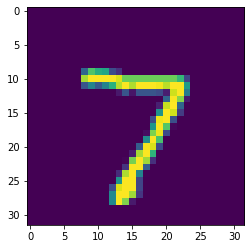

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
  
# Input image for analysis
input_img = next(iter(test_loader))[0][0].squeeze(0)
plt.imshow(input_img)

# Modifying the input image for analysis
input_img = input_img.unsqueeze(0).unsqueeze(0)
# savemat('input_img.mat', {'input_img':input_img})
# files.download('input_img.mat')

In [ ]:
from scipy.io import savemat, loadmat
from google.colab import files

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

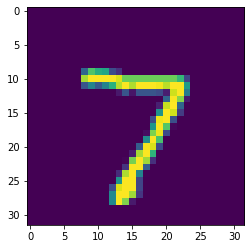

In [ ]:
temp_2 = input_img.detach().numpy()
print(temp_2)
print(temp_2.squeeze(0).squeeze(0))
input_image = temp_2.squeeze(0).squeeze(0)
# print(input_image.shape)
plt.imshow(input_image)
savemat('input_image.mat',{'input_image':input_image})
files.download('input_image.mat')

In [ ]:
from google.colab import files
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
%matplotlib inline

## Conv1 Feature Maps

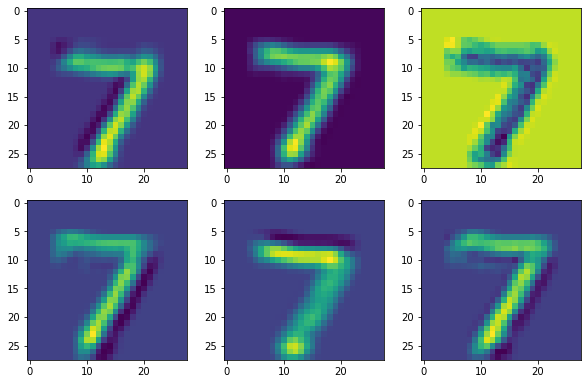

In [ ]:
plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output_fm = model.conv1.forward(input_img)[0][i].detach().numpy()
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output_fm)

In [ ]:
savemat('output_fm_conv1.mat', {'output_fm_conv1':output_fm})
files.download('output_fm_conv1.mat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

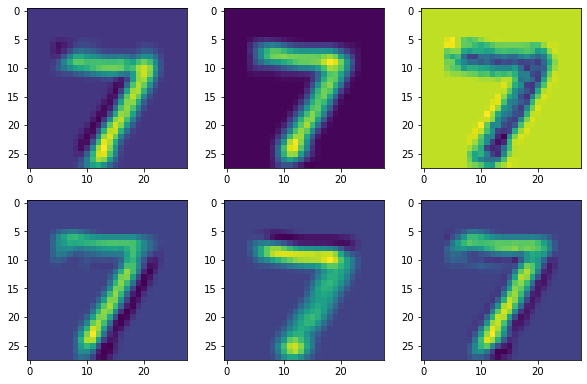

In [ ]:
plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.conv1.forward(input_img)[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)

In [ ]:
# print(output)
savemat('quantized_output_conv1.mat', {'quantized_output_conv1':output})
files.download('quantized_output_conv1.mat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conv1 Weights

In [ ]:
weights = []
bias = []
for i in range(6):
  print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[0][i].data.numpy()), np.max(param[0][i].data.numpy())))
  w = param[0][i].data.detach().numpy()
  print(w.shape)
  w = w.squeeze(0)
  print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L1'
  print(name)
  savemat(name+'.mat', {name:w})
  files.download(name+'.mat')


tensor([[[ 0.3295,  0.2608,  0.2362,  0.5247,  0.2085],
         [ 0.4223,  0.6543,  0.6660,  0.2627,  0.0707],
         [ 0.6179,  0.5050,  0.3053,  0.0551, -0.1393],
         [ 0.2131,  0.2595,  0.2511, -0.1212, -0.2286],
         [ 0.1533,  0.0773,  0.1953, -0.2377, -0.2318]]]), Bias: 0.001000289455987513

Min: -0.23765547573566437, Max: 0.6659524440765381

(1, 5, 5)
(5, 5)
[[ 0.3295321   0.2608299   0.23619424  0.5246577   0.20849785]
 [ 0.4223087   0.6542523   0.66595244  0.26271367  0.07069427]
 [ 0.61792797  0.5049771   0.3053429   0.05505742 -0.13925943]
 [ 0.21307829  0.2594764   0.2510941  -0.12120903 -0.22858082]
 [ 0.15325221  0.07733375  0.19525717 -0.23765548 -0.23177962]]
W0_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0950, -0.1173, -0.0048,  0.0917,  0.2857],
         [ 0.2110,  0.3976,  0.4085,  0.4273,  0.2798],
         [ 0.2315,  0.6461,  0.4368,  0.6670,  0.1894],
         [ 0.0727,  0.4882,  0.5861,  0.3980,  0.4523],
         [ 0.2116,  0.0252,  0.2082,  0.3158,  0.3378]]]), Bias: -0.00013503940135706216

Min: -0.11727563291788101, Max: 0.6669894456863403

(1, 5, 5)
(5, 5)
[[-0.0950109  -0.11727563 -0.00475228  0.09165546  0.28565165]
 [ 0.2110457   0.39764112  0.40846777  0.4273193   0.27984768]
 [ 0.2314521   0.64613885  0.43682918  0.66698945  0.18943968]
 [ 0.07272909  0.48816803  0.58610845  0.39803538  0.45233646]
 [ 0.21158183  0.02517139  0.20816265  0.31581888  0.33780652]]
W1_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0534, -0.0692, -0.0018, -0.0701, -0.0744],
         [-0.0248, -0.0272, -0.1694,  0.1194, -0.0385],
         [-0.0768, -0.1364,  0.0052, -0.1111, -0.1295],
         [-0.0509, -0.1354,  0.0928,  0.1418, -0.1010],
         [ 0.0534, -0.0755, -0.1885, -0.0194,  0.1056]]]), Bias: -0.1438530534505844

Min: -0.18854205310344696, Max: 0.14180536568164825

(1, 5, 5)
(5, 5)
[[ 0.05342541 -0.06915405 -0.00175569 -0.07007138 -0.07435737]
 [-0.02478308 -0.02722526 -0.1693673   0.11937933 -0.03854901]
 [-0.07681352 -0.13641241  0.00522566 -0.11105461 -0.12950757]
 [-0.05085447 -0.13537873  0.09275986  0.14180537 -0.10098185]
 [ 0.05341562 -0.07548065 -0.18854205 -0.01935389  0.1056171 ]]
W2_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0067, -0.3040, -0.1237, -0.0971,  0.3068],
         [-0.2473, -0.1854,  0.0196,  0.1548,  0.4047],
         [-0.0833,  0.0488, -0.0084,  0.1851,  0.4340],
         [-0.1163,  0.1673,  0.1304,  0.2798,  0.3847],
         [ 0.1481,  0.3312,  0.3152,  0.4361,  0.4793]]]), Bias: 0.061553359031677246

Min: -0.30396872758865356, Max: 0.4793269634246826

(1, 5, 5)
(5, 5)
[[-0.00671837 -0.30396873 -0.12366709 -0.09713686  0.30683157]
 [-0.24731219 -0.18544428  0.01956396  0.15475033  0.40465486]
 [-0.08332132  0.04879627 -0.00843245  0.18508592  0.433993  ]
 [-0.11632185  0.16728526  0.13035446  0.27980146  0.3846812 ]
 [ 0.14808168  0.3312112   0.31521857  0.4360677   0.47932696]]
W3_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.4826,  0.1795,  0.4518,  0.4369,  0.0473],
         [ 0.5516,  0.6719,  0.9372,  0.7797,  0.3391],
         [ 0.3204,  0.6561,  0.6384,  0.4752,  0.5451],
         [-0.1856, -0.1175,  0.1143,  0.3972,  0.3734],
         [-0.4118, -0.4834, -0.1331, -0.2704, -0.0830]]]), Bias: 0.010549753904342651

Min: -0.4833517372608185, Max: 0.9371881484985352

(1, 5, 5)
(5, 5)
[[ 0.4825563   0.1794752   0.4517671   0.43690717  0.04726844]
 [ 0.5515638   0.67193645  0.93718815  0.7796648   0.33911714]
 [ 0.32043028  0.65606207  0.63842964  0.47515905  0.54514825]
 [-0.18558903 -0.11749567  0.11427677  0.39718673  0.37342876]
 [-0.41182643 -0.48335174 -0.13311747 -0.2704001  -0.08301937]]
W4_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.2059,  0.0661, -0.0276,  0.1272,  0.2178],
         [-0.1743, -0.1957, -0.0662, -0.0576,  0.0770],
         [-0.0559,  0.0943,  0.1416,  0.2039,  0.3846],
         [ 0.2020,  0.2328,  0.2530,  0.2713, -0.0224],
         [ 0.3061,  0.3404,  0.1192,  0.2205, -0.1367]]]), Bias: -0.00026931814500130713

Min: -0.20593465864658356, Max: 0.3846195936203003

(1, 5, 5)
(5, 5)
[[-0.20593466  0.06613883 -0.02764028  0.12722914  0.21784915]
 [-0.17433488 -0.19572103 -0.06619279 -0.05755237  0.07702333]
 [-0.05586287  0.09426662  0.14158987  0.20385574  0.3846196 ]
 [ 0.20200546  0.23275878  0.2530471   0.27130768 -0.02240225]
 [ 0.30612198  0.3403606   0.11917607  0.22051316 -0.13667075]]
W5_L1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Pool1 Feature Maps

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

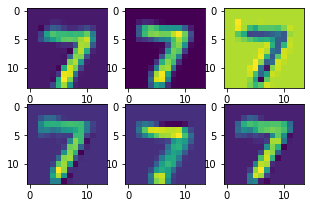

In [ ]:
param = list(model.parameters())
plt.figure(figsize=(5, 5))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.pool1.forward(
            model.conv1.forward(input_img))[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)
savemat('output_fm_pool1.mat', {'output_fm_pool1':output})
files.download('output_fm_pool1.mat')

## Conv2 Feature Maps

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

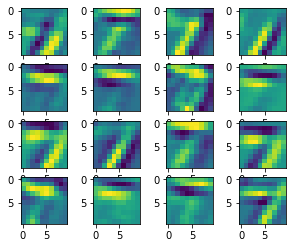

In [ ]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.conv2.forward(
            model.pool1.forward(
                model.conv1.forward(input_img)))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)
savemat('output_fm_conv2.mat', {'output_fm_conv2':output})
files.download('output_fm_conv2.mat')

## Conv2 Weights

In [ ]:
weights = []
bias = []
for i in range(16):
  print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[2][i].data.numpy()), np.max(param[2][i].data.numpy())))
  w = param[2][i].data.detach().numpy()
  print(w.shape)
  # w = w.squeeze(0)
  # print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L2'
  print(name)
  savemat(name+'.mat', {name:w})
  files.download(name+'.mat')

tensor([[[-0.0790, -0.0129,  0.0855,  0.0831,  0.0512],
         [-0.0681, -0.0581,  0.1041,  0.0084, -0.0220],
         [ 0.0552, -0.0512, -0.0385,  0.0703, -0.0506],
         [ 0.0639,  0.0524, -0.0586, -0.0586, -0.0957],
         [-0.0054,  0.0510, -0.0028, -0.0558, -0.0089]],

        [[-0.0158,  0.0133,  0.0168, -0.0605, -0.0566],
         [-0.0686,  0.0196, -0.0493, -0.0191, -0.0855],
         [ 0.0322,  0.0058,  0.0236,  0.0525, -0.0833],
         [-0.0701,  0.0066,  0.0159, -0.0166, -0.0162],
         [ 0.0519, -0.0795, -0.0108, -0.0424, -0.0076]],

        [[-0.0707, -0.0224,  0.0554, -0.0759,  0.0101],
         [-0.0371,  0.0314, -0.0240,  0.0706, -0.0474],
         [-0.0257,  0.0553, -0.0388,  0.0562, -0.0230],
         [ 0.0176, -0.0772, -0.0348, -0.0412,  0.0318],
         [ 0.0307, -0.0159,  0.0362,  0.0532, -0.0782]],

        [[ 0.0690, -0.0550,  0.0790, -0.0266,  0.0146],
         [ 0.0394, -0.0222,  0.0206,  0.0108,  0.0240],
         [ 0.0431, -0.0779,  0.0627,  0.06

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.1068,  0.0232, -0.0080, -0.0397, -0.0462],
         [-0.0931,  0.0531, -0.0060, -0.0577, -0.1123],
         [-0.1634, -0.0313, -0.1969, -0.1459, -0.0372],
         [-0.1598, -0.1530, -0.0855,  0.0461,  0.1772],
         [ 0.1114,  0.1420,  0.1904,  0.0570, -0.0452]],

        [[ 0.0110,  0.1134,  0.1368,  0.0531, -0.0934],
         [-0.0607,  0.0814, -0.0123, -0.0006,  0.0530],
         [-0.0705, -0.1921, -0.2284,  0.0506,  0.1833],
         [-0.0439,  0.0740,  0.0767,  0.1367,  0.0929],
         [ 0.1338,  0.1137,  0.2021,  0.1054,  0.0151]],

        [[-0.0583, -0.0400,  0.0384, -0.0039, -0.0706],
         [ 0.0326, -0.0106,  0.0230, -0.0791, -0.0801],
         [ 0.0813, -0.0273,  0.0735,  0.0620,  0.0150],
         [-0.0112, -0.0429,  0.0410,  0.0089, -0.0709],
         [-0.0637,  0.0664,  0.0627,  0.0392,  0.0473]],

        [[ 0.0544,  0.0878, -0.0562, -0.1191, -0.0708],
         [-0.1163, -0.0478, -0.0532, -0.0512, -0.0466],
         [-0.0217, -0.0455, -0.0510,  0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0256, -0.0275, -0.0546,  0.0185, -0.0761],
         [-0.1116,  0.0087, -0.0650,  0.0580,  0.1233],
         [-0.0221, -0.0212, -0.0265,  0.0328,  0.2052],
         [-0.0577, -0.1619, -0.2169,  0.1158,  0.2520],
         [-0.0158, -0.1555, -0.0860,  0.0131,  0.1660]],

        [[-0.0854, -0.0830,  0.0051,  0.1327,  0.0215],
         [ 0.0108, -0.0036,  0.1386,  0.1000,  0.0394],
         [-0.0148, -0.0025,  0.0113,  0.2101,  0.0572],
         [-0.1418, -0.2313,  0.0097,  0.1451,  0.0800],
         [-0.0764, -0.1560,  0.0829,  0.0822,  0.0674]],

        [[ 0.0026,  0.0217,  0.0229, -0.0661,  0.0180],
         [-0.0048,  0.0471,  0.0357,  0.0159,  0.0248],
         [ 0.0636, -0.0809,  0.0767,  0.0605, -0.0276],
         [ 0.0734, -0.0072, -0.0225, -0.0751, -0.0636],
         [ 0.0606, -0.0074, -0.0502, -0.0717, -0.0466]],

        [[-0.0627,  0.0348, -0.0086,  0.0159,  0.0463],
         [-0.0087,  0.0231, -0.0482,  0.0958, -0.0572],
         [-0.0350, -0.1102,  0.0420,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 8.6232e-02, -3.7583e-05, -9.1135e-02, -1.2336e-01,  2.7225e-01],
         [ 2.1591e-01,  4.2969e-02, -2.3858e-01, -1.1707e-01,  2.3060e-01],
         [ 1.7730e-01, -6.2860e-02, -1.6141e-01,  1.1879e-02,  2.3697e-01],
         [ 4.3501e-02, -1.8440e-01, -1.5856e-01,  1.3687e-01,  3.2570e-02],
         [ 2.3520e-02, -1.5612e-01,  3.8165e-02,  7.1759e-02, -7.8872e-02]],

        [[ 1.6101e-01, -1.2749e-02, -2.0148e-01,  3.6521e-02,  1.8239e-01],
         [ 4.6178e-02, -8.7906e-02, -1.5089e-01,  1.8242e-01,  1.9828e-01],
         [-5.4186e-03, -1.1066e-01,  4.1695e-02,  1.9311e-01,  9.9210e-02],
         [-4.8607e-02, -5.6923e-02,  4.7599e-02,  1.9265e-01, -5.2115e-02],
         [ 3.6341e-02,  1.0979e-02,  6.4588e-02,  5.8650e-02, -9.8725e-02]],

        [[-3.3583e-03, -1.0477e-02, -7.1532e-02,  9.1225e-03, -7.2393e-03],
         [-5.4900e-02, -7.3657e-02,  9.5864e-03, -1.7128e-02,  2.0214e-02],
         [ 3.0420e-02, -8.0671e-02, -1.3172e-02, -3.2991e-02, -5.3117e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0336, -0.1152, -0.1321, -0.1377, -0.0397],
         [-0.1147, -0.0043, -0.0845,  0.0593, -0.1093],
         [ 0.1734,  0.2123,  0.2088,  0.1325,  0.0257],
         [ 0.0743, -0.0761, -0.0796, -0.0263,  0.0650],
         [-0.2112, -0.1429, -0.0626, -0.0104, -0.0101]],

        [[-0.0261, -0.1148, -0.1153, -0.0754, -0.0684],
         [ 0.1022,  0.1493,  0.1509,  0.0214,  0.0486],
         [ 0.1179,  0.1489,  0.0718,  0.0146, -0.0187],
         [-0.2166, -0.2823, -0.1140, -0.1071,  0.0386],
         [-0.0662, -0.0978,  0.0344,  0.0684, -0.1097]],

        [[ 0.0421,  0.0085, -0.0021, -0.0742, -0.0348],
         [ 0.0715,  0.0161, -0.0742,  0.0514,  0.0500],
         [-0.0099,  0.0743,  0.0196,  0.0280, -0.0022],
         [-0.0616,  0.0114,  0.0696, -0.0511, -0.0544],
         [-0.0494, -0.0241, -0.0083,  0.0777, -0.0290]],

        [[ 0.0407,  0.0872,  0.0268, -0.0246,  0.0558],
         [ 0.1207,  0.1027,  0.0161,  0.0760,  0.0883],
         [-0.0328, -0.0159, -0.0015,  0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0441, -0.0050, -0.0685, -0.1171, -0.0651],
         [ 0.0520, -0.0226, -0.1579, -0.1794, -0.1388],
         [-0.0409, -0.0035,  0.0740,  0.0295, -0.0155],
         [ 0.1067,  0.0855,  0.2088,  0.2230,  0.0017],
         [ 0.0239, -0.0317, -0.0284, -0.0367, -0.0813]],

        [[-0.1150, -0.1866, -0.2576, -0.1945, -0.0025],
         [-0.0290, -0.1212, -0.0878, -0.0796, -0.0872],
         [ 0.1411,  0.2032,  0.2004,  0.1522,  0.1295],
         [ 0.0390,  0.1265,  0.0649,  0.0848,  0.0303],
         [-0.1767, -0.1672, -0.0878, -0.1342, -0.0742]],

        [[-0.0601,  0.0682,  0.0338, -0.0635,  0.0528],
         [ 0.0375,  0.0165,  0.0641, -0.0306,  0.0630],
         [ 0.0462,  0.0451, -0.0183, -0.0227, -0.0612],
         [-0.0017,  0.0201, -0.0465,  0.0762,  0.0654],
         [ 0.0058,  0.0080, -0.0789, -0.0648, -0.0426]],

        [[-0.0560, -0.0379, -0.1184, -0.0912, -0.1220],
         [-0.0633,  0.0533,  0.0928,  0.0225,  0.0780],
         [-0.0539,  0.0478,  0.0360,  0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0186,  0.0343, -0.0309, -0.0609, -0.0744],
         [-0.0314,  0.0667,  0.1033,  0.0230, -0.0381],
         [-0.0104, -0.0709, -0.0440,  0.0252, -0.0254],
         [-0.0506,  0.0299, -0.0604,  0.0822,  0.0207],
         [-0.0673, -0.0222,  0.0358,  0.0434,  0.0864]],

        [[-0.0481, -0.0748,  0.0553,  0.0621,  0.0478],
         [-0.0406, -0.0188,  0.0900,  0.0297, -0.0291],
         [ 0.0752, -0.0029, -0.0164, -0.0646, -0.0854],
         [-0.0755,  0.0969,  0.0900,  0.0635, -0.0074],
         [-0.0287, -0.0918, -0.0701,  0.0715, -0.0023]],

        [[ 0.0419, -0.0323, -0.0548,  0.0643,  0.0533],
         [ 0.0316,  0.0751, -0.0542, -0.0616, -0.0428],
         [ 0.0666, -0.0504, -0.0467, -0.0675,  0.0201],
         [-0.0751,  0.0328,  0.0266, -0.0805, -0.0169],
         [ 0.0250, -0.0242, -0.0007, -0.0137,  0.0028]],

        [[ 0.0526,  0.0150,  0.0205, -0.0129, -0.0708],
         [ 0.0523,  0.0090,  0.0446, -0.1115,  0.0706],
         [ 0.0505,  0.1037, -0.0789, -0.08

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0158, -0.0162, -0.1133,  0.0155, -0.1021],
         [-0.0013,  0.0789,  0.1846,  0.1855,  0.1715],
         [-0.1019, -0.0663, -0.0773, -0.1295, -0.1435],
         [-0.0537, -0.1535, -0.1543, -0.1898, -0.0556],
         [ 0.0571,  0.0317,  0.0243,  0.0190,  0.0102]],

        [[-0.0403,  0.0477,  0.1038,  0.1897,  0.2018],
         [-0.0221,  0.0203,  0.0887,  0.0329,  0.1738],
         [-0.1360, -0.2397, -0.3400, -0.2963, -0.1005],
         [-0.0836, -0.1635, -0.1060, -0.0628,  0.0598],
         [ 0.1532,  0.0456,  0.1467,  0.1594,  0.0914]],

        [[ 0.0337, -0.0413, -0.0717, -0.0344, -0.0217],
         [ 0.0101, -0.0387,  0.0590, -0.0440, -0.0325],
         [-0.0445,  0.0813, -0.0283, -0.0471,  0.0193],
         [-0.0437,  0.0237,  0.0226,  0.0131,  0.0750],
         [ 0.0322,  0.0174, -0.0259, -0.0471, -0.0127]],

        [[ 0.0737,  0.0161,  0.0651,  0.0475,  0.0690],
         [-0.1137, -0.1425, -0.0685, -0.0507,  0.0168],
         [-0.0933, -0.0762, -0.1765, -0.11

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0367, -0.0476,  0.0771,  0.1262,  0.0457],
         [-0.1241, -0.0280,  0.1675,  0.0656, -0.0634],
         [ 0.1193,  0.1489,  0.1044, -0.0180,  0.0186],
         [ 0.0178,  0.0558,  0.0555, -0.0812, -0.0508],
         [-0.1230, -0.0848, -0.1441, -0.1223, -0.1477]],

        [[-0.0601,  0.0506,  0.1067,  0.0522,  0.0069],
         [ 0.0024,  0.0300,  0.1859,  0.0727,  0.0719],
         [ 0.1631,  0.0672, -0.0093,  0.0132,  0.0155],
         [-0.0153,  0.0134, -0.1516, -0.0517, -0.1467],
         [-0.0207, -0.0973, -0.1137, -0.0853, -0.0398]],

        [[ 0.0370,  0.0772,  0.0114,  0.0428,  0.0380],
         [-0.0665, -0.0187,  0.0772, -0.0672, -0.0380],
         [ 0.0789, -0.0175, -0.0336, -0.0310,  0.0574],
         [-0.0805, -0.0688, -0.0565,  0.0093, -0.0423],
         [-0.0607, -0.0101, -0.0816, -0.0048, -0.0796]],

        [[ 0.0439,  0.1177,  0.0335, -0.0746, -0.0388],
         [ 0.1281,  0.0126,  0.0605, -0.0459,  0.0597],
         [ 0.0834, -0.0239, -0.0571,  0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.7934e-02,  6.2190e-02, -1.2129e-01, -7.9157e-02,  5.0833e-02],
         [-4.1129e-02, -6.4922e-02, -1.8861e-01,  8.4618e-03,  1.8856e-01],
         [ 2.2845e-02, -6.6031e-02, -1.4335e-01,  1.7666e-01,  1.6603e-01],
         [-1.3021e-01, -9.9678e-02,  1.8398e-01,  2.4268e-01,  8.8286e-02],
         [ 4.9095e-02,  1.4184e-01,  1.2339e-01,  8.3590e-02, -3.6995e-02]],

        [[ 1.2102e-02, -4.8598e-02, -9.8416e-02,  9.4680e-03,  1.2117e-01],
         [-6.8669e-02, -1.4292e-01, -4.5710e-02,  7.4034e-02,  1.3774e-01],
         [-9.5026e-02, -2.2525e-02,  1.3378e-01,  1.9199e-01,  1.0258e-01],
         [-1.1267e-01,  5.9493e-02,  2.2024e-01,  1.5036e-01, -6.4436e-02],
         [ 5.9526e-02,  8.4124e-02,  7.8461e-02, -5.7025e-02, -1.8474e-01]],

        [[ 6.0141e-02, -1.0988e-02, -5.7281e-02, -2.9862e-02, -5.9135e-03],
         [ 3.3018e-02,  7.4171e-02,  6.9367e-03, -5.9866e-02, -1.9383e-02],
         [ 4.5659e-02, -5.1479e-02, -4.0659e-02, -7.0293e-02, -3.2811e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-9.8728e-02,  1.6556e-02, -6.1624e-02,  7.8886e-03, -6.7360e-02],
         [-2.0144e-02, -2.3511e-02, -3.6378e-02,  3.6347e-02,  5.5358e-02],
         [-1.8314e-02, -1.2270e-01, -1.3303e-01, -1.2073e-01, -1.1145e-01],
         [-7.0880e-02, -1.8427e-02,  3.6044e-03, -5.3436e-02,  9.8224e-02],
         [-4.0490e-02,  6.7524e-02,  1.5183e-01,  1.3919e-01,  4.9008e-02]],

        [[ 2.4782e-03,  1.3524e-03,  7.0372e-02,  7.3451e-03, -3.0240e-02],
         [-4.9645e-02, -8.7059e-03, -1.0045e-01, -5.7717e-03, -9.9588e-02],
         [ 1.9771e-02, -1.3664e-01, -1.3971e-01, -3.1344e-02,  5.4617e-02],
         [-5.2153e-02,  8.6465e-02,  5.5831e-02,  8.9489e-02,  1.2547e-01],
         [-3.8020e-02,  3.0400e-02,  8.0160e-02,  1.3080e-01, -8.7661e-02]],

        [[ 2.1882e-02, -2.3147e-02, -1.1913e-02,  3.3882e-02,  1.7844e-02],
         [-3.0556e-02, -7.0818e-02, -2.7000e-02,  7.7646e-02, -5.1177e-03],
         [-4.8578e-03,  2.9801e-02, -3.7055e-02,  3.9689e-02, -8.3118e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0628, -0.0121, -0.0074,  0.0399,  0.1358],
         [-0.1031,  0.0482,  0.1888,  0.1894,  0.0519],
         [-0.0277,  0.1511,  0.1425,  0.0334, -0.1311],
         [-0.0431, -0.0560, -0.0633, -0.1017, -0.1045],
         [ 0.0046, -0.0540, -0.0703,  0.0201,  0.0202]],

        [[ 0.0004,  0.1190,  0.1554,  0.0569,  0.1515],
         [ 0.1128,  0.0424,  0.0622,  0.1045, -0.0724],
         [ 0.0562,  0.0611, -0.0977, -0.1833, -0.0776],
         [-0.0191, -0.1238, -0.0545, -0.1280, -0.1014],
         [-0.0437,  0.0275,  0.0840,  0.0110,  0.0395]],

        [[ 0.0281,  0.0352, -0.0556,  0.0350,  0.0617],
         [-0.0237, -0.0084, -0.0303, -0.0800, -0.0507],
         [-0.0600,  0.0535, -0.0522, -0.0129,  0.0028],
         [-0.0303,  0.0650,  0.0272,  0.0809, -0.0017],
         [ 0.0670,  0.0315, -0.0787,  0.0031, -0.0476]],

        [[ 0.1300,  0.0062,  0.0265, -0.0077,  0.0899],
         [ 0.0265,  0.0849, -0.0808, -0.0934, -0.1249],
         [-0.0201, -0.0599, -0.1716, -0.08

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.1245,  0.0548, -0.0363, -0.0659, -0.0484],
         [-0.0377, -0.0023, -0.0209, -0.0375, -0.1281],
         [-0.1154, -0.0023,  0.0070,  0.1026,  0.1148],
         [-0.0146, -0.0752, -0.1074, -0.0075,  0.1056],
         [ 0.0341,  0.0385, -0.0775, -0.0997,  0.1611]],

        [[ 0.0919,  0.1451,  0.0905, -0.0488, -0.1683],
         [-0.0136,  0.0841,  0.1042, -0.0067, -0.0932],
         [-0.0167, -0.0310,  0.1271,  0.2599,  0.1310],
         [-0.0614, -0.0882, -0.0113,  0.0819,  0.0624],
         [-0.0563, -0.1878, -0.2223, -0.0417,  0.0272]],

        [[ 0.0559,  0.0584,  0.0298,  0.0106,  0.0277],
         [-0.0040,  0.0454, -0.0347, -0.0793, -0.0746],
         [ 0.0056, -0.0142, -0.0682,  0.0208,  0.0270],
         [ 0.0406,  0.0066,  0.0753, -0.0429,  0.0394],
         [-0.0788,  0.0244,  0.0297, -0.0386, -0.0325]],

        [[ 0.0052,  0.0291, -0.0620,  0.0059, -0.0402],
         [-0.0141,  0.0969,  0.0915,  0.0488, -0.0433],
         [-0.1127,  0.0702, -0.1061,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-1.0796e-01, -2.2029e-02,  3.9807e-02,  5.9433e-02,  3.0991e-02],
         [-1.3293e-02,  5.8170e-02,  2.8925e-03, -5.0029e-02, -5.5238e-02],
         [-7.0438e-02, -5.8177e-02, -3.5020e-02, -7.0567e-02,  3.8640e-02],
         [-9.3550e-02, -1.2709e-01, -8.0347e-02, -1.4428e-02,  1.3081e-02],
         [-8.1074e-02,  9.2708e-02, -7.3613e-02, -7.0487e-02, -3.8127e-03]],

        [[-2.3051e-02,  9.8392e-02,  4.1782e-02,  8.9931e-02,  7.6861e-02],
         [ 1.2030e-01,  1.3003e-01,  1.7120e-01,  1.3103e-01,  9.0455e-02],
         [-6.6778e-02, -5.7585e-02, -6.0708e-02,  9.2101e-02,  9.2685e-02],
         [-1.7020e-01, -1.0524e-01, -1.9836e-01, -1.1020e-01, -7.5125e-02],
         [ 1.6483e-01,  1.4372e-01,  2.6453e-03, -5.3713e-02, -1.5703e-01]],

        [[-2.3907e-02, -5.6188e-02,  5.6454e-02,  3.2304e-02,  4.9867e-02],
         [-3.9825e-03,  6.7501e-02, -6.7321e-02, -7.8259e-02,  2.1370e-04],
         [-5.5420e-02,  4.4164e-02, -1.8361e-02,  7.9860e-02,  1.4621e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0107, -0.0101,  0.0812,  0.0717,  0.1134],
         [-0.0198, -0.0968, -0.0874, -0.0474, -0.0136],
         [-0.1337, -0.1022, -0.1527, -0.1492, -0.1221],
         [ 0.0451,  0.0814, -0.0251,  0.0755,  0.0229],
         [ 0.0803,  0.0415,  0.1107,  0.0489,  0.0842]],

        [[ 0.0582, -0.0663,  0.0434, -0.0306,  0.0828],
         [-0.1414, -0.0963, -0.1660,  0.0285,  0.0243],
         [ 0.0836, -0.0584, -0.0702, -0.0705, -0.1329],
         [ 0.0845,  0.1398,  0.0887, -0.0216, -0.0666],
         [ 0.0664, -0.0101,  0.0440,  0.1242, -0.0356]],

        [[ 0.0494,  0.0522, -0.0068,  0.0373,  0.0785],
         [ 0.0598,  0.0143,  0.0734, -0.0668,  0.0187],
         [ 0.0717, -0.0794,  0.0332, -0.0806,  0.0073],
         [-0.0018,  0.0147,  0.0119, -0.0246,  0.0383],
         [ 0.0486, -0.0061, -0.0749, -0.0622, -0.0541]],

        [[-0.0674, -0.0436, -0.0720,  0.0893,  0.0543],
         [ 0.0467, -0.0672, -0.0856, -0.0711, -0.0722],
         [ 0.0267, -0.0002, -0.0470, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.1307e-02, -8.3400e-02, -5.2076e-02, -1.2975e-01, -1.0512e-02],
         [-1.0155e-01, -1.1021e-02,  9.3247e-02,  2.9932e-02,  1.0572e-01],
         [-7.4690e-02,  1.6412e-01,  1.7377e-01,  1.0565e-01,  1.2004e-02],
         [ 7.9331e-02,  3.9697e-02, -1.1726e-02, -1.7585e-01, -1.3644e-03],
         [-5.9306e-02,  7.0721e-02, -7.9924e-02,  6.0088e-03,  9.0109e-02]],

        [[ 2.9422e-02, -1.0363e-01,  3.0406e-02,  3.3024e-02,  7.9838e-02],
         [ 4.0356e-02,  7.7835e-04,  1.9011e-02,  3.2882e-02,  6.8248e-02],
         [ 5.6677e-02,  7.6892e-02,  9.7259e-02, -1.0637e-01, -1.3666e-01],
         [ 9.8242e-02,  9.4105e-02, -8.2516e-02, -1.5682e-01, -5.6992e-02],
         [ 9.9366e-02, -6.5986e-02, -7.6888e-02,  2.4674e-02, -6.1508e-02]],

        [[ 4.2573e-02, -6.1497e-02,  3.6066e-02,  5.7956e-02,  7.4412e-02],
         [ 5.0755e-02,  3.5641e-02,  8.1886e-03,  3.7019e-02,  1.1198e-02],
         [-3.6855e-02,  7.7013e-02,  7.6825e-02, -1.9720e-02,  7.7328e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Pool2 Feature Maps

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

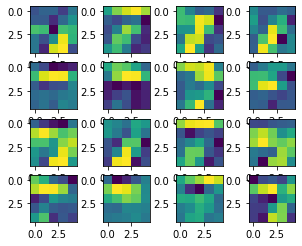

In [ ]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)
savemat('output_fm_pool2.mat', {'output_fm_pool2':output})
files.download('output_fm_pool2.mat')

## Conv3 Outputs

In [ ]:
param = list(model.parameters())

for i in range(120):
    output = model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img)))))[0][i].detach().numpy()
    print(output)
savemat('output_fm_conv3.mat', {'output_fm_conv3':output})
files.download('output_fm_conv3.mat')

[[-4.0821185]]
[[-6.3826985]]
[[-1.7227349]]
[[14.611475]]
[[-8.637173]]
[[7.6843476]]
[[3.6600442]]
[[0.6175798]]
[[20.168186]]
[[9.891682]]
[[-3.5959196]]
[[0.31154892]]
[[-0.67430997]]
[[3.9806643]]
[[-2.395441]]
[[6.6421676]]
[[-0.58447766]]
[[9.259758]]
[[4.1511216]]
[[-1.7416395]]
[[-5.769785]]
[[6.390707]]
[[0.38253146]]
[[-0.13644852]]
[[-6.7095985]]
[[3.218927]]
[[-1.0370909]]
[[-0.5177182]]
[[5.131935]]
[[1.2543992]]
[[7.871909]]
[[-3.6927848]]
[[2.9744635]]
[[3.7829883]]
[[-4.5057044]]
[[-15.524651]]
[[3.084178]]
[[1.2874943]]
[[-1.0547835]]
[[3.5137184]]
[[15.532871]]
[[5.2947183]]
[[1.1902802]]
[[7.9310436]]
[[-0.33499062]]
[[-4.3949103]]
[[-2.8284774]]
[[-0.12210961]]
[[2.447742]]
[[0.55305636]]
[[-2.8619685]]
[[12.977423]]
[[5.4072866]]
[[8.829887]]
[[3.4786348]]
[[1.8875291]]
[[-4.9788365]]
[[12.026643]]
[[5.807989]]
[[-3.767779]]
[[17.331215]]
[[6.3809786]]
[[-4.169556]]
[[-2.362881]]
[[-5.1726155]]
[[-3.2833462]]
[[5.340901]]
[[6.4697757]]
[[6.909781]]
[[-5.2200017]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conv3 Weights

In [ ]:
for i in range(120):
  print("{}, Bias: {}\n".format(param[4][i].data, param[5][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[4][i].data.numpy()), np.max(param[4][i].data.numpy())))
  w = param[4][i].data.detach().numpy()
  # print(w.shape)
  # w = w.squeeze(0)
  # print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L3'
  print(name)
  savemat(name+'.mat', {name:w})
  files.download(name+'.mat')

tensor([[[-1.3833e-02, -1.4651e-02,  3.9266e-02,  2.9442e-02, -4.6898e-02],
         [-3.4590e-02, -4.9677e-02,  2.9426e-02, -3.9866e-02,  6.5985e-03],
         [ 1.0706e-02,  4.1578e-02,  2.1470e-02, -9.4096e-03,  8.9598e-03],
         [-1.8275e-02, -5.5766e-03,  2.4253e-02,  1.8212e-02, -3.0987e-02],
         [ 4.1092e-02, -2.2571e-02, -2.0016e-02,  4.4895e-02, -1.2890e-02]],

        [[-2.5831e-02, -4.9816e-03, -2.2936e-02,  8.2622e-04, -1.3107e-02],
         [ 6.7448e-03, -1.1239e-02,  6.5732e-03, -3.0435e-02,  6.6828e-04],
         [ 1.8899e-02,  1.7736e-02,  5.8880e-03,  2.3159e-02,  3.2304e-02],
         [-3.3909e-02,  4.1085e-03, -1.2762e-02, -1.8391e-02, -2.6550e-02],
         [ 1.1036e-02,  1.0370e-02, -4.1730e-02, -1.9693e-02,  4.5738e-02]],

        [[-3.7115e-02, -4.4339e-02,  2.0732e-02,  1.1306e-02,  4.7171e-02],
         [-1.8587e-02, -9.4515e-04, -4.3497e-02,  3.3587e-02,  2.3365e-02],
         [-3.0734e-02, -5.7709e-03, -2.9850e-03, -4.3632e-02, -1.0440e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 3.4249e-02,  3.8758e-02,  2.6119e-02, -3.6855e-02, -4.8048e-02],
         [ 7.5890e-03, -5.6476e-03,  3.6101e-02,  2.5747e-03, -1.4470e-03],
         [ 2.3949e-02, -3.4058e-02, -3.0198e-02,  1.2843e-02, -3.7897e-02],
         [ 4.5174e-02,  2.4010e-02, -2.8263e-02,  4.2510e-02,  4.5114e-02],
         [-2.6858e-02,  4.7195e-02, -1.0546e-02,  2.6518e-02, -2.1321e-02]],

        [[ 1.9516e-02,  3.4025e-02,  3.7454e-02,  2.3962e-05, -1.4327e-02],
         [-2.9622e-03,  2.8179e-02, -4.5505e-02, -4.8888e-02, -5.0339e-02],
         [ 7.9203e-02, -4.2521e-02,  2.3305e-02, -1.3205e-02,  5.6408e-02],
         [ 1.1530e-03, -1.0628e-02, -3.6643e-02,  4.2126e-02,  3.4722e-02],
         [-2.5426e-02, -6.5619e-02,  2.6877e-03, -3.7572e-02,  2.5246e-02]],

        [[-3.1124e-02,  5.9338e-02, -1.3359e-02,  1.3949e-02,  4.0130e-02],
         [-1.3133e-02, -5.9660e-02,  9.6436e-04,  7.0330e-04,  8.8460e-03],
         [ 4.1980e-02,  2.9619e-03, -3.1274e-02, -5.5179e-02,  9.7039e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0050, -0.0206, -0.0013,  0.0138, -0.0130],
         [-0.0009, -0.0237,  0.0309, -0.0436,  0.0303],
         [ 0.0137, -0.0462,  0.0065, -0.0188, -0.0306],
         [ 0.0350, -0.0135,  0.0109,  0.0377,  0.0011],
         [-0.0085, -0.0154, -0.0061, -0.0253, -0.0026]],

        [[-0.0344, -0.0289, -0.0555,  0.0053,  0.0372],
         [-0.0399,  0.0022,  0.0068, -0.0481,  0.0265],
         [-0.0200,  0.0322,  0.0060, -0.0435,  0.0269],
         [-0.0112,  0.0617,  0.0173, -0.0395, -0.0403],
         [-0.0288, -0.0073,  0.0244,  0.0025, -0.0189]],

        [[-0.0346, -0.0044,  0.0412, -0.0224,  0.0189],
         [ 0.0195, -0.0121, -0.0565, -0.0233,  0.0290],
         [-0.0286,  0.0244, -0.0075, -0.0358, -0.0019],
         [-0.0013,  0.0501, -0.0309, -0.0034, -0.0043],
         [-0.0156,  0.0621,  0.0493,  0.0426, -0.0140]],

        [[-0.0052,  0.0228,  0.0166,  0.0188,  0.0188],
         [-0.0279, -0.0224, -0.0169, -0.0032,  0.0300],
         [ 0.0041,  0.0124,  0.0646, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0064, -0.0302, -0.0161, -0.0009, -0.0156],
         [-0.0089, -0.0269,  0.0465,  0.0389, -0.0092],
         [-0.0402,  0.0057,  0.0177,  0.0422,  0.0091],
         [-0.0283, -0.0477,  0.0329,  0.0214,  0.0158],
         [-0.0362, -0.0308, -0.0253,  0.0544, -0.0388]],

        [[-0.0031, -0.0520, -0.0165,  0.0497, -0.0039],
         [-0.0319, -0.0311, -0.0512, -0.0328, -0.0099],
         [-0.0017,  0.0271,  0.0188, -0.0245, -0.0367],
         [ 0.0137,  0.0043,  0.0847,  0.0271,  0.0228],
         [-0.0311,  0.0733,  0.0339,  0.0005,  0.0427]],

        [[-0.0133, -0.0164, -0.0601,  0.0484, -0.0182],
         [-0.0275,  0.0487, -0.0174, -0.0280, -0.0551],
         [-0.0220,  0.0151, -0.0314,  0.0409, -0.0687],
         [-0.0456,  0.0282,  0.0058, -0.0229,  0.0188],
         [ 0.0103, -0.0260, -0.0235,  0.0271, -0.0231]],

        [[-0.0076,  0.0090, -0.0092,  0.0237, -0.0417],
         [-0.0058, -0.0585,  0.0385, -0.0138,  0.0478],
         [-0.0571,  0.0015,  0.0039,  0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0136, -0.0294,  0.0248,  0.0054,  0.0215],
         [ 0.0051,  0.0066,  0.0442,  0.0496, -0.0448],
         [ 0.0365,  0.0214,  0.0275,  0.0406,  0.0416],
         [-0.0437, -0.0343, -0.0267,  0.0342, -0.0221],
         [-0.0430, -0.0378,  0.0358,  0.0303, -0.0403]],

        [[-0.0130, -0.0598, -0.0556,  0.0044, -0.0574],
         [-0.0194, -0.0050, -0.0102,  0.0869,  0.0862],
         [ 0.0440,  0.0988,  0.0348,  0.0345, -0.0447],
         [ 0.0269, -0.0107,  0.0425,  0.0435,  0.0188],
         [-0.0091, -0.0622,  0.0613, -0.0187,  0.0050]],

        [[ 0.0346,  0.0599,  0.0812, -0.0516, -0.0035],
         [-0.0162,  0.0185,  0.0165, -0.0904, -0.0368],
         [-0.0278,  0.0498,  0.0095, -0.0593, -0.0396],
         [ 0.0001,  0.0274, -0.0218, -0.0176, -0.0048],
         [-0.0181,  0.0027,  0.0083, -0.0131,  0.0093]],

        [[-0.0046, -0.0311,  0.0740, -0.0340,  0.0339],
         [-0.0327, -0.0536, -0.0053,  0.0366, -0.0140],
         [-0.0782, -0.0054,  0.0108, -0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.3788e-02, -1.4045e-02, -9.7269e-04, -7.5453e-03,  1.9416e-03],
         [-2.1261e-02,  2.6176e-02, -2.6533e-02, -5.0233e-02,  2.4665e-02],
         [ 1.0688e-02,  3.7683e-02, -3.9318e-02, -3.9817e-02, -2.6941e-02],
         [-4.7992e-02, -4.2619e-02, -3.5188e-02, -2.2700e-02,  9.9842e-03],
         [-4.8554e-02, -1.7852e-02,  9.8365e-03, -3.9851e-02, -2.4836e-02]],

        [[-4.9540e-02,  7.4706e-02,  6.8642e-02,  7.4078e-02,  5.9678e-02],
         [-3.5669e-03, -3.0013e-02,  2.8456e-02,  2.2338e-02, -1.3020e-03],
         [-3.3638e-02, -2.5099e-02,  5.0729e-02, -1.6720e-02, -1.0832e-02],
         [-2.7384e-02,  3.5100e-02, -4.7539e-03, -3.5109e-02, -6.5548e-02],
         [ 8.8250e-03,  8.3521e-03,  1.2432e-02,  5.2365e-03,  4.2760e-02]],

        [[-6.7589e-02, -2.1534e-02, -7.2389e-02, -3.5438e-02, -2.8845e-02],
         [-5.9605e-02,  9.8550e-03,  2.3287e-02, -2.0060e-02, -5.1175e-02],
         [ 2.7898e-02,  1.2712e-02,  2.4942e-02,  4.0205e-02, -2.9925e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0282,  0.0010,  0.0026,  0.0453, -0.0015],
         [ 0.0247,  0.0403,  0.0208, -0.0298,  0.0025],
         [-0.0292, -0.0145,  0.0203, -0.0425,  0.0109],
         [-0.0204,  0.0299,  0.0242, -0.0048,  0.0057],
         [-0.0278, -0.0341, -0.0157, -0.0178,  0.0351]],

        [[ 0.0131,  0.0475,  0.0685, -0.0305, -0.0839],
         [-0.0069,  0.0440,  0.0435,  0.0073, -0.0360],
         [ 0.0694,  0.0393, -0.0434, -0.0627,  0.0587],
         [-0.0128,  0.0130, -0.0410, -0.0019, -0.0206],
         [-0.0785, -0.0599,  0.0243,  0.0046,  0.0192]],

        [[-0.0268,  0.0138,  0.0122,  0.0497,  0.0381],
         [ 0.0128, -0.0334, -0.0073,  0.0096, -0.0254],
         [ 0.0031, -0.0605,  0.0243, -0.0682, -0.0657],
         [-0.0433, -0.0267, -0.0624, -0.0725,  0.0328],
         [-0.0465,  0.0074,  0.0229, -0.0312,  0.0083]],

        [[-0.0264, -0.0139, -0.0189, -0.0495, -0.0233],
         [ 0.0239,  0.0003, -0.0004,  0.0407,  0.0202],
         [ 0.0084, -0.0205,  0.0485,  0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.0217e-02,  3.3305e-02,  1.0020e-02, -1.0085e-02,  4.9108e-02],
         [ 3.2065e-02,  4.5468e-02,  5.0381e-04,  2.1203e-02, -2.4238e-02],
         [-2.8294e-03,  1.6109e-02, -1.9304e-03,  1.5334e-02,  2.9044e-02],
         [-4.2025e-02,  3.7437e-02,  1.8890e-05,  2.3336e-02,  5.0369e-03],
         [-2.8845e-02, -1.0736e-02, -4.8398e-02, -3.1739e-03,  1.3006e-04]],

        [[-3.8975e-02,  3.7504e-02,  5.8390e-02, -1.9869e-02, -4.8462e-02],
         [-2.0050e-02, -5.2938e-02,  5.1386e-03,  1.6901e-02,  2.4725e-02],
         [ 3.9503e-02,  3.2027e-02,  6.4651e-02,  6.0996e-02, -3.5921e-02],
         [-1.7389e-03, -6.9741e-02,  5.0203e-02,  2.8239e-02, -4.2023e-03],
         [ 2.0231e-02,  4.4401e-02,  6.1388e-03, -7.6692e-02, -8.5033e-03]],

        [[-3.5366e-02, -2.6127e-02,  4.5541e-02,  2.0656e-02, -9.1757e-03],
         [-5.0321e-03,  3.1791e-03,  1.8362e-02, -2.0001e-02, -4.2438e-02],
         [ 5.5397e-04, -3.2639e-02, -4.7538e-02,  3.6403e-02, -2.1455e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.4854e-02, -4.8248e-02, -4.9034e-02,  1.5197e-02, -9.0067e-03],
         [ 1.0127e-02,  2.1269e-02, -4.7043e-02,  8.8841e-03,  1.3142e-02],
         [ 1.6667e-02, -3.8203e-02, -1.6258e-02,  1.2746e-02,  2.1518e-02],
         [-1.4891e-02, -3.4681e-03,  1.2239e-04, -4.3567e-02, -1.6225e-02],
         [-3.6582e-02,  1.0869e-03,  2.6394e-02, -1.7732e-03,  7.1571e-03]],

        [[-4.1518e-03,  1.7137e-03,  5.0379e-02,  5.4989e-02, -3.3980e-02],
         [-4.5796e-02,  2.5628e-02,  5.3832e-02, -1.4541e-02, -6.4802e-03],
         [ 2.9047e-02,  3.0878e-02,  1.0179e-01, -8.5060e-02, -9.9692e-03],
         [ 2.9589e-02,  1.0319e-02,  1.2638e-02, -7.4674e-02, -4.2525e-02],
         [-4.9452e-02,  1.0284e-02,  2.9029e-02, -6.0287e-02,  1.6299e-02]],

        [[-1.6472e-03, -2.7799e-02, -7.4048e-02, -1.7664e-02, -3.1557e-02],
         [-4.5696e-02,  4.5380e-02,  7.7783e-02,  5.9736e-02,  1.4604e-02],
         [ 3.5026e-03,  3.3421e-02, -1.3726e-02,  4.9846e-03, -2.1367e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.7377e-02, -4.5990e-02, -4.6340e-02,  4.0352e-02,  3.1314e-02],
         [ 1.8278e-02, -1.3031e-02, -1.6407e-02,  2.7869e-02, -7.4277e-03],
         [ 1.9555e-02,  4.1498e-02, -1.5941e-02, -2.0146e-02,  4.7599e-02],
         [-8.2655e-03,  2.5314e-03, -2.2650e-02,  7.9494e-03, -1.2215e-02],
         [ 2.1030e-02,  3.1960e-02,  1.4750e-02, -3.6095e-02, -4.6367e-02]],

        [[ 6.4308e-02, -5.3591e-02, -3.6091e-02,  3.4457e-02,  1.0687e-01],
         [ 3.3833e-03, -3.2698e-02, -1.8868e-02, -5.2663e-02, -5.9548e-02],
         [ 1.1201e-02, -1.4601e-02,  5.6289e-02,  2.7105e-02, -4.8099e-02],
         [ 5.8092e-02,  3.3902e-02, -4.0670e-02, -7.5935e-02,  1.8935e-03],
         [-2.6676e-06, -3.1334e-02,  3.5223e-02,  1.8672e-03,  4.4251e-02]],

        [[-5.0549e-03,  2.4626e-02,  1.6821e-02, -2.6738e-02,  1.3989e-02],
         [ 1.7991e-02, -1.8109e-02,  1.4517e-03, -3.8972e-03,  2.8777e-02],
         [ 5.0292e-02, -2.3943e-02,  1.0567e-03,  3.2975e-02,  3.3655e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0026,  0.0077, -0.0015,  0.0317,  0.0317],
         [-0.0294, -0.0175, -0.0023, -0.0380,  0.0365],
         [ 0.0229,  0.0326,  0.0238, -0.0405,  0.0331],
         [ 0.0175,  0.0349, -0.0208,  0.0266,  0.0462],
         [ 0.0030,  0.0006, -0.0136, -0.0104,  0.0117]],

        [[-0.0303, -0.0356, -0.0248, -0.0122,  0.0027],
         [ 0.0010,  0.0198,  0.0174, -0.0232, -0.0267],
         [ 0.0128,  0.0426, -0.0341, -0.0475, -0.0290],
         [-0.0377,  0.0458,  0.0021,  0.0479,  0.0304],
         [ 0.0112,  0.0103, -0.0283,  0.0215,  0.0452]],

        [[-0.0016, -0.0104,  0.0053, -0.0079,  0.0453],
         [-0.0496,  0.0246, -0.0474,  0.0476,  0.0467],
         [ 0.0043, -0.0255, -0.0011,  0.0138,  0.0270],
         [-0.0266,  0.0369,  0.0163,  0.0449,  0.0055],
         [-0.0478, -0.0241, -0.0426,  0.0097, -0.0364]],

        [[-0.0414, -0.0395,  0.0405, -0.0461, -0.0492],
         [-0.0111, -0.0347,  0.0267, -0.0305,  0.0087],
         [-0.0018,  0.0058, -0.0053, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.0967e-02, -2.2967e-02,  2.9089e-02,  4.7167e-02, -1.0437e-02],
         [-2.9856e-02, -4.0075e-02,  7.5123e-03,  3.0754e-02, -4.3487e-02],
         [ 4.9089e-02,  1.0179e-03,  2.6870e-02, -4.3999e-02,  5.0294e-02],
         [-1.4491e-02,  2.8285e-02,  4.3396e-02,  3.3963e-02, -7.0139e-03],
         [ 4.5626e-02,  2.5050e-02,  9.2061e-03, -5.0378e-02, -4.7439e-02]],

        [[ 3.8371e-03, -1.3676e-02,  7.6851e-03,  2.3352e-04, -1.9348e-03],
         [-4.1452e-02,  5.9623e-02,  3.7740e-02, -4.7604e-02, -3.1260e-02],
         [-7.9850e-02,  2.1479e-02,  3.2538e-02, -2.6227e-02,  2.9253e-02],
         [ 4.3179e-02,  1.2357e-02,  4.7251e-02,  5.2419e-02, -6.7469e-03],
         [ 7.8578e-03,  1.8760e-02,  5.7530e-02, -2.1570e-02, -2.2890e-02]],

        [[-4.7607e-02, -8.6593e-03,  1.3184e-02, -1.3670e-02, -1.2656e-02],
         [-1.2593e-03,  9.7722e-02,  4.5123e-02, -5.7606e-02,  3.3603e-02],
         [-1.9919e-02,  9.3822e-02,  1.2906e-02, -2.1301e-03,  3.7554e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.7136e-02, -1.3812e-02, -5.9539e-04,  1.3242e-02, -1.2404e-02],
         [ 3.4988e-02, -5.2882e-03,  4.0348e-02,  3.0928e-02,  1.3308e-02],
         [ 4.5932e-02, -1.2962e-02, -1.7135e-02, -6.7666e-03, -8.5694e-03],
         [-4.1293e-02, -1.8801e-02, -1.9799e-02,  2.3549e-03, -1.8751e-02],
         [ 1.3523e-02,  4.0866e-02, -4.0957e-02, -3.2749e-02,  1.2792e-02]],

        [[-1.7480e-02, -1.7264e-02,  7.4933e-03,  3.5899e-02,  4.8753e-03],
         [ 1.3842e-02, -1.5312e-02, -7.3900e-02, -4.7668e-03, -2.4531e-02],
         [ 1.0802e-02,  4.1372e-02, -3.9513e-02, -1.5749e-02, -3.7166e-03],
         [ 4.7461e-02,  1.4789e-02, -3.2644e-02,  2.0176e-02, -2.3694e-02],
         [ 9.5647e-03, -6.4916e-02,  4.9933e-02,  1.3563e-02, -1.1140e-02]],

        [[ 1.1523e-02,  2.5555e-02,  4.2144e-02, -1.2733e-02,  4.3113e-02],
         [-2.7626e-02,  7.3647e-02, -6.0522e-02, -6.4295e-02, -4.7733e-02],
         [ 2.9302e-02,  9.0386e-02, -4.9213e-02, -2.4127e-03, -4.9485e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.3541e-02,  2.6080e-02, -1.1787e-02, -9.4969e-03, -7.7687e-03],
         [-1.3814e-02,  1.8248e-02, -4.1121e-02, -2.0079e-02, -9.3326e-03],
         [-2.0349e-02, -3.9416e-02, -3.6567e-02,  2.9838e-02,  1.0761e-02],
         [-2.0629e-02, -2.9260e-02, -2.5219e-02, -1.5996e-02, -1.5473e-02],
         [-1.6469e-02, -2.7797e-02,  1.8510e-02, -2.6900e-02,  5.4865e-03]],

        [[-3.9561e-03,  3.4402e-02,  3.6986e-02,  2.8687e-02, -7.1162e-04],
         [ 2.5979e-02, -1.2367e-02, -2.6849e-04,  4.6601e-02,  2.6657e-03],
         [ 2.3603e-02,  3.0309e-02,  4.4054e-03, -4.2990e-02, -4.5480e-02],
         [ 2.8799e-02,  1.5720e-02,  5.0994e-02,  1.7527e-02,  3.4140e-02],
         [-5.7748e-02, -1.2346e-02,  5.5458e-02, -2.2960e-03,  4.4528e-02]],

        [[ 6.1262e-02,  4.2847e-02, -8.3911e-02, -5.0402e-03, -3.9255e-02],
         [ 4.8608e-02,  6.6878e-02,  2.5437e-02, -4.0168e-04, -2.3477e-02],
         [ 7.9520e-03,  5.5664e-02, -2.3883e-02, -6.7969e-02, -5.9466e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0443,  0.0366, -0.0095, -0.0335,  0.0209],
         [ 0.0393,  0.0074, -0.0131, -0.0415,  0.0473],
         [ 0.0150,  0.0218, -0.0023,  0.0158,  0.0145],
         [-0.0288,  0.0425,  0.0030,  0.0017,  0.0213],
         [-0.0147,  0.0419, -0.0003,  0.0208, -0.0127]],

        [[ 0.0058,  0.0761, -0.0410, -0.0299, -0.0413],
         [-0.0163,  0.0385,  0.0354, -0.0365,  0.0156],
         [-0.0177,  0.0171,  0.0152,  0.0283, -0.0479],
         [-0.0302,  0.0420,  0.0486,  0.0181, -0.0245],
         [ 0.0033, -0.0479,  0.0448,  0.0890, -0.0091]],

        [[-0.0387, -0.0283,  0.0312, -0.0012, -0.0121],
         [ 0.0019,  0.0525,  0.0306, -0.0187,  0.0348],
         [-0.0853,  0.0034, -0.0480,  0.0028, -0.0304],
         [-0.0082, -0.0439,  0.0308, -0.0215, -0.0286],
         [-0.0131,  0.0189, -0.0394,  0.0207,  0.0157]],

        [[-0.0309, -0.0108, -0.0005, -0.0266,  0.0234],
         [-0.0060,  0.0231, -0.0429, -0.0225, -0.0177],
         [-0.0686, -0.0202,  0.0155, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0103,  0.0143,  0.0355, -0.0224, -0.0433],
         [-0.0503, -0.0349, -0.0123,  0.0363, -0.0388],
         [ 0.0325, -0.0384,  0.0330,  0.0368,  0.0082],
         [ 0.0234, -0.0039, -0.0171,  0.0380,  0.0473],
         [ 0.0322, -0.0460,  0.0418,  0.0381, -0.0017]],

        [[-0.0196, -0.0319,  0.0626, -0.0355, -0.0336],
         [ 0.0196,  0.0231,  0.0023, -0.0366, -0.0175],
         [ 0.0337,  0.0607, -0.0436, -0.0390, -0.0221],
         [-0.0158,  0.0388,  0.0115, -0.0006, -0.0039],
         [-0.0253, -0.0631,  0.0638, -0.0031, -0.0269]],

        [[ 0.0283,  0.0032,  0.0170,  0.0619, -0.0087],
         [ 0.0103, -0.0126,  0.0169,  0.0460, -0.0299],
         [-0.0021,  0.0058,  0.0048,  0.0212,  0.0308],
         [-0.0391, -0.0014, -0.0266, -0.0237, -0.0221],
         [ 0.0441,  0.0173, -0.0286,  0.0403,  0.0113]],

        [[ 0.0445,  0.0368,  0.0369, -0.0100, -0.0296],
         [ 0.0211,  0.0261, -0.0276,  0.0251,  0.0020],
         [-0.0349,  0.0372, -0.0126, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-1.0064e-02,  2.7638e-02, -1.8729e-02, -1.7355e-02, -2.5299e-02],
         [ 3.2396e-02, -6.7155e-03, -1.2589e-02,  1.6202e-02, -1.9391e-03],
         [ 4.5708e-03,  4.8883e-02, -3.6902e-02,  4.2568e-02,  9.9320e-03],
         [ 2.8272e-02, -3.5347e-02,  2.1679e-02, -4.9603e-02,  9.6782e-03],
         [-2.8420e-02,  2.2580e-02, -3.4031e-03,  4.7736e-02, -1.2372e-02]],

        [[-8.5708e-03,  6.4769e-03, -4.5259e-02, -2.6053e-03,  3.0459e-02],
         [-3.6570e-02,  6.7767e-03, -1.1277e-02, -4.9165e-02, -4.0430e-02],
         [-8.6543e-03,  4.1348e-02,  2.8206e-02, -2.8543e-02, -2.1717e-02],
         [-4.3891e-03,  5.3931e-02, -4.2568e-02, -5.0428e-02,  1.6054e-02],
         [-1.2092e-02,  4.0449e-03, -2.0589e-02,  3.7709e-02,  5.8091e-02]],

        [[-4.0770e-05, -1.7382e-02,  1.9212e-02, -1.7533e-02, -3.3575e-02],
         [-3.8960e-02, -4.4312e-02,  2.7224e-02,  5.0339e-02, -5.4257e-02],
         [-1.0614e-03, -7.8896e-02, -3.4810e-02,  8.9365e-03, -5.4660e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.6998e-02, -2.1489e-02, -2.0929e-02,  3.1663e-02, -9.8057e-03],
         [-4.9159e-02,  4.4312e-02,  8.8810e-03, -2.2756e-02, -3.3628e-02],
         [ 6.9237e-04,  1.0555e-03, -2.9846e-02,  4.6476e-02, -6.8025e-03],
         [ 1.0077e-02,  2.9374e-02, -1.3189e-02, -2.5634e-02, -3.8711e-03],
         [-4.0672e-02,  1.0964e-02,  2.8767e-02,  1.7002e-02,  1.8685e-02]],

        [[ 3.6871e-03, -2.3519e-02,  2.2069e-02,  8.7737e-03, -3.4802e-02],
         [ 4.6392e-04,  7.6594e-03, -9.9628e-03,  4.6553e-02, -9.2331e-03],
         [ 4.5400e-02, -6.5473e-02, -7.8474e-02,  3.5884e-03,  3.7404e-02],
         [ 4.6851e-02,  4.3637e-02,  5.2261e-02, -1.2298e-02, -4.4855e-02],
         [ 4.8280e-02,  8.3510e-02,  4.4901e-02, -4.2291e-02, -3.6021e-02]],

        [[ 4.3507e-02, -3.3992e-02,  2.8696e-02,  6.5211e-02, -3.8722e-03],
         [ 3.1226e-02,  4.1922e-02,  2.4718e-02,  1.2168e-02,  2.5132e-02],
         [ 3.2822e-02, -4.2924e-02,  8.5148e-03,  4.2713e-02,  1.2638e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.7300e-02,  1.2205e-02, -3.4665e-03, -4.3503e-02,  2.4157e-02],
         [ 2.4184e-02, -9.2575e-03, -3.6386e-02, -2.5518e-02, -3.6721e-02],
         [-3.5168e-02, -2.5387e-02, -4.6959e-02, -1.3126e-02, -2.5526e-03],
         [ 3.2037e-02, -2.4505e-02,  2.6354e-02,  1.7288e-03,  2.2730e-03],
         [-4.4105e-02,  3.9440e-03,  9.2106e-03,  2.1813e-02,  2.1694e-02]],

        [[ 3.9055e-02,  2.5302e-02,  4.2197e-02, -4.4229e-02,  1.9698e-02],
         [ 2.1842e-02,  6.5193e-02,  5.1388e-02,  5.4092e-02, -1.1419e-02],
         [-4.2870e-02,  6.0703e-02, -1.4249e-03, -1.7500e-02,  3.5854e-02],
         [-4.3253e-02, -2.8707e-03, -1.9921e-02,  3.8992e-02, -4.1225e-02],
         [-3.1870e-02,  4.6548e-02,  4.8801e-02,  9.6759e-03,  6.8050e-03]],

        [[ 1.4202e-02,  3.5572e-02,  3.6147e-02, -2.2827e-04,  3.9382e-02],
         [-5.4109e-02,  1.7274e-02,  1.2558e-01,  2.6204e-02,  1.3397e-02],
         [-8.3311e-02,  4.8254e-02,  5.7627e-02, -7.3211e-02,  3.3254e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0412, -0.0246, -0.0013,  0.0213,  0.0275],
         [-0.0155,  0.0402, -0.0349, -0.0144,  0.0060],
         [ 0.0488,  0.0297,  0.0018, -0.0079, -0.0036],
         [-0.0100, -0.0120,  0.0322, -0.0251,  0.0454],
         [-0.0186, -0.0171, -0.0455,  0.0196,  0.0301]],

        [[ 0.0097, -0.0300, -0.0335, -0.0263,  0.0427],
         [ 0.0464,  0.0271,  0.0453, -0.0427,  0.0506],
         [-0.0026, -0.0013, -0.0315,  0.0428, -0.0175],
         [-0.0292,  0.0227, -0.0028, -0.0226,  0.0110],
         [ 0.0423, -0.0082,  0.0314,  0.0474,  0.0455]],

        [[ 0.0247, -0.0327,  0.0143, -0.0163, -0.0178],
         [ 0.0089, -0.0172,  0.0292, -0.0107, -0.0070],
         [-0.0286, -0.0247,  0.0307, -0.0431, -0.0429],
         [-0.0057, -0.0165,  0.0339,  0.0304,  0.0418],
         [-0.0317,  0.0107, -0.0071,  0.0372, -0.0225]],

        [[ 0.0224,  0.0028, -0.0401, -0.0079,  0.0403],
         [ 0.0240, -0.0420, -0.0363,  0.0367,  0.0236],
         [-0.0308, -0.0379,  0.0422,  0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 5.1650e-03, -2.0065e-02,  2.4985e-02, -4.0899e-02, -2.9664e-02],
         [ 1.5266e-02,  4.4251e-02,  4.6133e-02, -2.1416e-02, -1.0519e-02],
         [-3.9069e-02, -4.1694e-02,  3.3483e-02, -4.5249e-02,  4.5327e-02],
         [ 4.3116e-02,  4.6418e-02,  5.0837e-03, -4.3979e-02, -2.0200e-02],
         [-1.2300e-02,  4.7775e-02, -2.8607e-02,  3.8087e-02, -3.2204e-02]],

        [[ 2.9421e-02, -2.7990e-02,  3.7708e-02, -1.8017e-02, -2.2778e-02],
         [-2.3470e-02,  4.6516e-02, -7.8897e-03,  4.0889e-02, -6.2514e-03],
         [ 4.0130e-02, -2.9911e-02, -1.5843e-02,  1.2519e-02,  2.8965e-02],
         [ 3.2842e-02,  8.3676e-03,  2.7474e-02, -3.4995e-02, -1.5988e-04],
         [ 1.2786e-02,  4.8263e-02, -1.2533e-02, -1.8430e-02, -3.3514e-02]],

        [[-4.7772e-02,  3.3702e-02, -9.3423e-03,  3.1626e-02, -4.9780e-02],
         [ 4.0270e-02,  2.0439e-02,  1.7009e-02,  3.5240e-03, -1.6642e-02],
         [-1.3643e-02, -5.8919e-03, -1.7877e-02, -4.9173e-02, -2.1341e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0464, -0.0148, -0.0016, -0.0346, -0.0328],
         [ 0.0306,  0.0112, -0.0256,  0.0310,  0.0124],
         [-0.0179, -0.0417,  0.0015,  0.0541,  0.0017],
         [ 0.0205, -0.0020,  0.0203, -0.0007,  0.0055],
         [-0.0283, -0.0410, -0.0388,  0.0472, -0.0233]],

        [[-0.0373,  0.0481,  0.0525,  0.0013, -0.0094],
         [ 0.0147,  0.0253,  0.0409, -0.0829,  0.0259],
         [-0.0124, -0.0004, -0.0142, -0.0783, -0.0240],
         [-0.0457,  0.0612,  0.0060, -0.0101, -0.0361],
         [ 0.0234, -0.0150, -0.0052, -0.0449,  0.0438]],

        [[-0.0781,  0.0174,  0.0296,  0.0183, -0.0455],
         [-0.0308,  0.0520,  0.0293,  0.0614, -0.0371],
         [ 0.0108, -0.0293, -0.0495, -0.0139, -0.0056],
         [-0.0213, -0.0286,  0.0197,  0.0527,  0.0322],
         [-0.0076, -0.0388, -0.0164,  0.0319, -0.0197]],

        [[-0.0373, -0.0550,  0.0169, -0.0421,  0.0056],
         [ 0.0093,  0.0082,  0.0176,  0.0254,  0.0254],
         [-0.0065, -0.0021,  0.0429,  0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.1741e-02, -2.2220e-02,  1.8550e-02, -5.3059e-03, -4.6088e-03],
         [ 4.1350e-02, -3.2638e-02,  1.0314e-03,  4.7234e-02,  4.7195e-02],
         [ 4.6335e-03,  4.8359e-02, -7.2069e-03, -2.3032e-02,  4.2421e-02],
         [ 1.3665e-02,  3.8821e-02, -5.9751e-03,  8.9715e-04,  3.1250e-03],
         [-3.6029e-02,  5.7551e-06, -4.4893e-02,  1.0919e-02, -1.8463e-02]],

        [[ 1.0961e-02,  8.2900e-03, -5.3669e-03, -2.8547e-02,  1.7189e-02],
         [-2.1094e-04, -1.7796e-02, -2.7251e-02, -8.8711e-02, -3.0141e-02],
         [-1.6412e-02, -1.0933e-02, -6.3086e-02, -4.4274e-02, -1.6193e-02],
         [ 5.7485e-02, -4.2630e-03,  1.7610e-02,  1.8829e-02, -1.9310e-02],
         [ 1.9212e-02,  1.1673e-02, -1.3495e-02,  3.0114e-02, -6.7668e-03]],

        [[ 2.5081e-02,  2.3912e-02,  1.7320e-02, -1.9176e-02, -3.4266e-02],
         [ 3.7926e-02,  3.8802e-02, -5.5219e-02, -2.2007e-02, -3.9985e-02],
         [ 4.0588e-02,  3.4139e-02, -1.5580e-02,  2.1181e-02,  7.6766e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 3.5446e-02,  4.0996e-02, -8.5858e-03, -2.7411e-02, -2.5412e-02],
         [-1.2835e-03, -6.6500e-03,  3.6301e-02,  6.4890e-03,  3.3644e-02],
         [ 2.0932e-02,  1.5701e-02,  4.6718e-02, -1.1876e-03, -1.9571e-02],
         [-1.8723e-03, -2.8467e-02,  5.4899e-03, -1.6470e-02, -1.9752e-02],
         [-1.3818e-02,  5.2625e-03, -4.3018e-02,  4.4874e-02,  3.8964e-02]],

        [[-4.8003e-02, -4.0953e-02, -4.7258e-02, -3.1115e-02,  3.2662e-02],
         [ 2.5193e-02, -4.2168e-02, -4.9716e-02,  4.1089e-02,  4.4404e-02],
         [-5.9978e-03,  1.8653e-02, -4.8431e-02,  5.6192e-03,  3.5009e-02],
         [-2.9428e-02, -1.9004e-02,  2.2020e-02, -1.9074e-02, -3.3903e-03],
         [ 3.8678e-02,  3.8739e-02, -5.9386e-04,  1.9945e-02,  1.8616e-02]],

        [[-1.0069e-02,  1.8736e-02, -3.3484e-02,  9.9595e-03,  3.4908e-02],
         [ 3.4394e-02, -5.1035e-02,  3.5211e-02, -1.8052e-02, -2.7305e-02],
         [-1.5378e-02,  3.5569e-02, -1.0727e-02,  6.6525e-03,  4.4209e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0410,  0.0494,  0.0250,  0.0463, -0.0266],
         [ 0.0487, -0.0051,  0.0264,  0.0336,  0.0114],
         [ 0.0019, -0.0023,  0.0425, -0.0335, -0.0167],
         [-0.0153,  0.0074,  0.0055,  0.0262, -0.0391],
         [ 0.0430,  0.0134,  0.0230, -0.0303,  0.0219]],

        [[-0.0150,  0.0548, -0.0105,  0.0264, -0.0118],
         [ 0.0046, -0.0208, -0.0444,  0.0530, -0.0068],
         [-0.0044,  0.0670, -0.0594,  0.0099, -0.0302],
         [-0.0296,  0.0910,  0.1033,  0.0895, -0.0079],
         [ 0.0404,  0.0084,  0.0358,  0.0921, -0.0131]],

        [[-0.0182, -0.0687,  0.0095, -0.0764,  0.0086],
         [-0.0295,  0.0466, -0.0657, -0.0226, -0.0210],
         [-0.0399,  0.0767, -0.0737, -0.0233, -0.0227],
         [-0.0053, -0.0364, -0.0345,  0.0083, -0.0386],
         [-0.0163,  0.0146, -0.0476, -0.0393,  0.0418]],

        [[ 0.0543, -0.0329,  0.0341, -0.0266, -0.0610],
         [ 0.0072, -0.0313,  0.0141, -0.0681, -0.0597],
         [-0.0395,  0.0391, -0.1092, -0.10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 5.7440e-03,  4.1162e-02, -4.1533e-02, -2.1265e-02,  1.0163e-02],
         [-3.2548e-02,  4.3261e-02,  4.2832e-02, -8.8008e-04, -8.3335e-03],
         [-3.7132e-02, -6.1918e-03, -6.3695e-04, -2.8845e-02,  4.4683e-02],
         [ 3.1209e-03, -5.0243e-02,  1.3520e-02,  2.6093e-02, -2.2544e-02],
         [-4.6809e-02,  3.1285e-02,  4.0706e-02,  2.0690e-02,  3.5673e-02]],

        [[ 2.6094e-02,  7.6179e-02,  9.6528e-03,  2.7823e-02,  6.7762e-02],
         [-6.3073e-02, -6.8202e-02, -1.7679e-02, -9.8896e-03,  4.3105e-02],
         [ 4.1068e-03, -2.0208e-02, -3.1826e-02, -1.8478e-02, -8.6990e-03],
         [ 3.6442e-02, -9.0847e-03,  3.2492e-02,  6.4289e-02, -4.0396e-02],
         [ 2.9325e-02,  1.4441e-03,  5.6467e-02,  7.3245e-02, -3.5474e-02]],

        [[ 4.6498e-02, -3.5818e-02, -6.1136e-02, -4.4143e-02,  2.0873e-02],
         [ 1.1198e-02,  8.5168e-03,  1.5050e-02, -3.5929e-02,  1.0993e-02],
         [-4.2976e-03,  2.4746e-02, -9.7334e-03,  1.3044e-02,  7.5110e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.5551e-02,  3.3374e-02,  2.7915e-02,  3.8958e-02,  1.4060e-02],
         [ 3.4253e-02,  1.0690e-02, -2.5397e-02,  3.9738e-02,  2.9095e-02],
         [-3.1780e-02, -2.0566e-02,  1.5010e-02,  3.1652e-03, -5.0238e-02],
         [-2.7719e-02,  2.0344e-02,  2.2118e-03, -5.2141e-02,  2.0310e-02],
         [-1.9362e-02,  3.6959e-02, -3.8676e-02, -4.8799e-02, -4.3102e-02]],

        [[-2.4940e-02,  5.1486e-02, -1.5705e-02, -8.0108e-03,  2.5915e-02],
         [ 4.6253e-02, -6.2225e-02, -5.7273e-04, -3.5615e-02, -2.9959e-02],
         [-3.2767e-02, -1.2244e-01,  4.6380e-03,  1.8855e-02,  4.2715e-03],
         [-6.8304e-03, -7.1838e-02, -2.0694e-02,  1.3262e-02, -2.7293e-02],
         [ 5.5353e-02,  3.7831e-02, -8.1535e-02, -4.7710e-02,  2.3995e-03]],

        [[ 2.3189e-02, -7.4283e-02, -2.0743e-02,  2.8021e-02,  1.6761e-02],
         [ 4.1712e-03, -9.5721e-02,  4.2766e-02,  9.5600e-03,  5.1686e-02],
         [ 9.3099e-02, -5.6153e-02,  2.7650e-02,  1.6488e-01,  6.4321e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.3351e-02, -8.7486e-03, -4.2380e-02,  3.2580e-02, -2.0163e-02],
         [ 2.5039e-02, -1.0578e-02, -2.8619e-03, -2.5747e-02,  4.8657e-03],
         [-4.1682e-03, -1.0042e-02,  4.5550e-03,  2.3594e-02,  9.7366e-03],
         [ 2.4526e-02, -2.1544e-02, -2.9065e-02, -1.6341e-02, -1.0058e-02],
         [ 1.3845e-02,  2.6219e-02,  1.4014e-02, -4.0635e-02,  4.6856e-02]],

        [[-3.6496e-02,  1.5812e-02,  3.8165e-02, -4.9066e-02, -8.2730e-03],
         [-2.1419e-02, -5.0448e-02, -3.9502e-02, -4.7733e-02,  2.8243e-02],
         [ 1.0993e-02, -1.9976e-03,  1.4203e-02, -1.6026e-02,  8.1852e-03],
         [ 6.8556e-03, -4.8865e-02, -3.3130e-02,  2.7784e-02,  7.1841e-03],
         [-3.3664e-03,  1.4183e-02,  4.0544e-02,  8.8302e-03, -1.3364e-02]],

        [[-2.8406e-02,  1.2347e-02, -4.2581e-02, -2.5136e-02, -1.1837e-02],
         [ 2.6865e-02,  4.8973e-02, -3.1304e-02, -3.9135e-02,  3.5104e-02],
         [-4.6461e-02, -3.4506e-02,  2.8264e-02, -2.2230e-02,  3.5686e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0419, -0.0237,  0.0275, -0.0439, -0.0096],
         [ 0.0442,  0.0023, -0.0219,  0.0505,  0.0287],
         [-0.0103,  0.0203,  0.0138, -0.0323,  0.0188],
         [-0.0099, -0.0017, -0.0508,  0.0441, -0.0199],
         [-0.0074, -0.0292, -0.0293,  0.0393, -0.0054]],

        [[-0.0383, -0.0038, -0.0028,  0.0206,  0.0424],
         [-0.0185,  0.0442,  0.0210, -0.0202, -0.0066],
         [ 0.0318,  0.0732, -0.0191, -0.0428, -0.0547],
         [ 0.0343,  0.0306,  0.0691, -0.0005,  0.0006],
         [ 0.0181,  0.0072,  0.0551,  0.0710, -0.0333]],

        [[ 0.0097,  0.0427, -0.0028, -0.0083,  0.0126],
         [ 0.0133,  0.0438, -0.0054,  0.0408, -0.0054],
         [-0.0699,  0.0013, -0.0569, -0.0089, -0.0189],
         [ 0.0266,  0.0287, -0.0254, -0.0019, -0.0148],
         [-0.0365,  0.0437, -0.0033, -0.0175,  0.0053]],

        [[-0.0280, -0.0267,  0.0681,  0.0008,  0.0423],
         [-0.0104, -0.0368,  0.0204, -0.0519, -0.0233],
         [-0.0427, -0.0183, -0.0466, -0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.2703e-02,  1.9572e-02,  2.5780e-02,  8.6266e-03,  4.3139e-02],
         [-4.3048e-02, -8.4091e-03, -2.5241e-02, -2.3675e-02,  2.6828e-02],
         [ 3.2164e-02,  1.9309e-02,  1.5092e-02,  2.5616e-02,  1.3033e-02],
         [ 1.5093e-02, -1.3783e-02, -1.6610e-02, -2.3425e-02, -2.9139e-02],
         [-2.6993e-02,  5.1639e-02,  3.1004e-02, -3.1346e-03,  2.5249e-02]],

        [[-1.6964e-04, -5.6274e-02, -1.0700e-02, -9.6927e-02, -7.5678e-02],
         [-2.6831e-03, -2.1352e-02,  4.2393e-02, -3.7913e-02, -6.2473e-02],
         [ 3.5358e-02, -1.6417e-02, -3.4616e-02,  3.7915e-03,  3.0315e-02],
         [-1.6741e-02, -5.6073e-02,  3.3072e-02,  3.5457e-02, -5.1541e-02],
         [ 2.2578e-03,  3.3948e-02, -1.6099e-02,  1.8051e-02, -2.4985e-02]],

        [[ 9.9394e-04,  2.8847e-02,  8.3413e-02,  2.5989e-02,  4.4177e-03],
         [ 4.7744e-02,  7.4849e-02,  1.5118e-02, -1.5256e-02,  7.6972e-03],
         [-5.1578e-02, -4.8040e-02, -4.5543e-02,  2.9298e-02,  1.9763e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0282, -0.0456, -0.0122, -0.0207, -0.0097],
         [ 0.0298, -0.0195,  0.0005, -0.0428,  0.0110],
         [-0.0497, -0.0217, -0.0029, -0.0043,  0.0135],
         [-0.0496, -0.0281,  0.0197, -0.0112,  0.0289],
         [-0.0256,  0.0474,  0.0312,  0.0119,  0.0234]],

        [[-0.0189,  0.0801,  0.0281,  0.0669,  0.0272],
         [ 0.0141, -0.0019,  0.0175, -0.0405,  0.0029],
         [-0.0139,  0.0055,  0.0157, -0.0264, -0.0146],
         [ 0.0003,  0.0086,  0.0106, -0.0397,  0.0136],
         [-0.0183,  0.0461, -0.0336,  0.0220, -0.0197]],

        [[-0.0260, -0.0194,  0.0294, -0.0304,  0.0157],
         [ 0.0222, -0.0413,  0.1105,  0.0840,  0.0022],
         [-0.0002,  0.0177, -0.0051,  0.0862,  0.0740],
         [ 0.0351,  0.0298,  0.0010, -0.0202,  0.0330],
         [-0.0032, -0.0005, -0.0707, -0.0370,  0.0318]],

        [[-0.0375, -0.0357,  0.0021, -0.0190, -0.0349],
         [-0.0631,  0.0191,  0.0015, -0.0420, -0.0353],
         [ 0.0621,  0.0356,  0.0503,  0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.0808e-02,  3.7275e-02,  4.6536e-02, -1.0990e-02,  3.3101e-02],
         [-3.7664e-02,  4.8800e-02, -4.5392e-02,  4.0558e-02, -2.8759e-02],
         [ 1.3544e-02, -2.1149e-02,  2.2788e-02, -9.8764e-03, -1.2859e-02],
         [-3.8778e-02, -3.4207e-02,  4.3737e-02, -2.6190e-02, -2.7761e-02],
         [ 3.9805e-03, -1.8412e-03,  3.7786e-02, -2.6398e-02,  2.9530e-02]],

        [[ 2.6984e-02,  1.4095e-02, -2.8815e-02, -2.7858e-02,  8.8991e-03],
         [ 4.2685e-02, -2.1980e-02,  5.3766e-03,  3.7321e-02,  7.1986e-03],
         [ 1.4074e-02,  4.6727e-02,  7.5112e-04,  2.3851e-02, -1.0271e-02],
         [-3.2845e-02, -2.2193e-02,  4.3456e-02, -1.2191e-02, -2.4959e-02],
         [-2.2148e-02, -9.2358e-04,  2.7850e-02, -8.7921e-03,  9.5943e-03]],

        [[ 8.6319e-03,  9.8607e-03,  2.2494e-02, -2.7883e-02,  7.0716e-04],
         [-2.8217e-02,  3.2899e-02,  1.7591e-02, -4.0573e-02, -3.7124e-02],
         [ 2.1559e-02, -2.8523e-02, -1.2866e-02, -3.7180e-02, -3.9717e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0268, -0.0096,  0.0101,  0.0383,  0.0507],
         [ 0.0337, -0.0017, -0.0260, -0.0066, -0.0339],
         [-0.0304,  0.0317,  0.0268,  0.0479, -0.0474],
         [ 0.0469,  0.0046,  0.0353,  0.0174,  0.0435],
         [ 0.0152, -0.0311,  0.0361,  0.0431, -0.0430]],

        [[-0.0010,  0.0598, -0.0034, -0.0412, -0.0184],
         [-0.0142,  0.0178, -0.0287, -0.0270, -0.0316],
         [ 0.0005,  0.0075,  0.0058,  0.0019, -0.0280],
         [ 0.0010,  0.0513,  0.0162,  0.0596,  0.0566],
         [-0.0364, -0.0184, -0.0075,  0.0227,  0.0135]],

        [[ 0.0024,  0.0592, -0.0293, -0.0258,  0.0392],
         [ 0.0730,  0.0241,  0.0030, -0.0234, -0.0068],
         [-0.0528,  0.0446,  0.0226, -0.0304, -0.0454],
         [-0.0434, -0.0143,  0.0109,  0.0258,  0.0304],
         [-0.0351,  0.0471,  0.0439, -0.0124, -0.0046]],

        [[-0.0095,  0.0310, -0.0207,  0.0204, -0.0172],
         [-0.0041,  0.0438,  0.0076,  0.0163,  0.0417],
         [-0.0374, -0.0083, -0.0446, -0.06

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0016,  0.0302,  0.0205,  0.0491, -0.0127],
         [-0.0402, -0.0187,  0.0352,  0.0375, -0.0027],
         [-0.0006, -0.0344,  0.0086, -0.0489, -0.0119],
         [ 0.0438, -0.0025,  0.0272, -0.0196,  0.0251],
         [ 0.0349, -0.0051,  0.0125,  0.0404,  0.0463]],

        [[ 0.0807,  0.0192, -0.0392,  0.0401,  0.0717],
         [-0.0349,  0.0023,  0.0061,  0.0446,  0.0602],
         [-0.0020,  0.0468, -0.0108, -0.0245, -0.0399],
         [-0.0226,  0.0192, -0.0084,  0.0333, -0.0375],
         [ 0.0020,  0.0081,  0.0335, -0.0241, -0.0321]],

        [[-0.0014,  0.0003, -0.0671, -0.0044, -0.0506],
         [ 0.0265, -0.0509, -0.0767, -0.0216,  0.0178],
         [ 0.0480,  0.0678,  0.0018, -0.0313, -0.0157],
         [ 0.0044,  0.0359, -0.0535, -0.0317, -0.0291],
         [-0.0011,  0.0660,  0.0324, -0.0463,  0.0257]],

        [[ 0.0340,  0.0753, -0.0189,  0.0278,  0.0411],
         [ 0.0445,  0.0623, -0.0412, -0.0283, -0.0127],
         [-0.0004,  0.0768, -0.0088, -0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-9.7427e-03,  4.5220e-02,  2.3797e-02, -2.7616e-02, -1.0259e-02],
         [-2.4440e-02, -4.3928e-03, -4.4688e-03,  1.2668e-02, -4.1559e-02],
         [-3.7208e-02, -3.8207e-02, -4.5884e-02,  1.0534e-02, -2.0374e-02],
         [ 4.9688e-02, -1.3981e-02,  2.8466e-02, -2.5577e-02, -4.6421e-02],
         [ 3.9460e-02,  9.8489e-03,  9.7381e-03,  1.1911e-03,  1.7997e-02]],

        [[-4.9993e-02, -2.0622e-02, -3.9631e-03, -4.3416e-02,  5.9201e-02],
         [ 4.8556e-03,  1.5046e-02, -4.0251e-02, -1.9677e-02,  3.7947e-02],
         [ 3.0308e-02, -4.7085e-02, -1.3224e-02, -3.4530e-02,  3.3663e-02],
         [-2.7136e-02,  3.2849e-02,  5.3810e-02,  7.2638e-02, -2.7082e-02],
         [ 1.4387e-02,  8.3863e-04, -1.8206e-02, -3.6549e-02,  4.9498e-02]],

        [[ 1.9545e-02,  5.9398e-03,  8.8908e-03,  2.6547e-02,  2.6838e-02],
         [-1.9327e-02, -1.8470e-02, -6.3013e-02, -7.2683e-02, -4.8658e-02],
         [-2.4569e-02,  3.1579e-02,  4.9912e-02, -2.8673e-02,  4.1541e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0155, -0.0418,  0.0126,  0.0252,  0.0416],
         [ 0.0128,  0.0004,  0.0337, -0.0211,  0.0170],
         [ 0.0439, -0.0418, -0.0128,  0.0250, -0.0177],
         [-0.0470, -0.0380,  0.0102,  0.0136, -0.0051],
         [-0.0426, -0.0332,  0.0194,  0.0427,  0.0194]],

        [[-0.0114, -0.0682,  0.0033, -0.0022, -0.0393],
         [-0.0166, -0.0396, -0.0412, -0.0245,  0.0359],
         [ 0.0241,  0.0064, -0.0445, -0.0055,  0.0513],
         [-0.0504, -0.0537,  0.0443,  0.0338, -0.0116],
         [-0.0073, -0.0054,  0.0093,  0.0118, -0.0075]],

        [[ 0.0229,  0.0052,  0.0226, -0.0122, -0.0171],
         [-0.0194, -0.0433, -0.0562, -0.0570, -0.0238],
         [ 0.0298, -0.0353,  0.0133, -0.0415, -0.0110],
         [ 0.0512,  0.0210,  0.0284,  0.0406,  0.0058],
         [-0.0120, -0.0197,  0.0230,  0.0257,  0.0525]],

        [[-0.0635, -0.0219,  0.0458, -0.0004, -0.0448],
         [ 0.0131,  0.0445,  0.0506, -0.0232, -0.0527],
         [ 0.0362,  0.0058, -0.0586, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 8.9749e-03, -3.1492e-02, -1.4129e-02,  8.1534e-03,  8.0694e-03],
         [-1.6514e-02, -1.0725e-03,  8.4929e-03,  6.9559e-03,  4.4712e-02],
         [ 4.0428e-02,  2.4838e-04, -3.4695e-02, -4.8987e-02,  4.4705e-03],
         [-2.9338e-03, -3.9069e-02, -3.9910e-02, -4.7365e-03, -4.0886e-02],
         [ 1.9719e-02,  2.8620e-02,  2.7699e-02,  1.2962e-03,  2.6232e-02]],

        [[-1.7663e-02, -5.0768e-02, -8.4751e-03,  5.7728e-02, -2.9082e-03],
         [-5.5692e-03,  2.2745e-02, -3.7212e-02,  5.8129e-02, -4.5589e-02],
         [ 5.1376e-02,  1.8565e-02,  3.4745e-02, -4.6937e-02,  2.5113e-02],
         [ 4.4111e-02, -6.6663e-03,  1.7045e-02, -1.9883e-02, -2.5148e-02],
         [-1.3384e-02,  3.1212e-02,  3.2922e-02,  1.9755e-02, -1.2392e-02]],

        [[-2.5525e-02, -1.6844e-02, -1.2074e-03, -2.3882e-02, -2.4319e-02],
         [ 8.0041e-03, -1.5851e-02, -4.0137e-02,  2.2873e-02,  1.9409e-02],
         [ 3.1951e-02,  4.5363e-02,  2.5114e-02,  5.9564e-03,  2.9089e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0249,  0.0218, -0.0005, -0.0400, -0.0418],
         [ 0.0130, -0.0449, -0.0264,  0.0111,  0.0264],
         [-0.0345, -0.0203, -0.0137,  0.0404,  0.0288],
         [-0.0032,  0.0169, -0.0135, -0.0081, -0.0348],
         [-0.0077, -0.0185, -0.0487, -0.0394,  0.0264]],

        [[-0.0319,  0.0017,  0.0225, -0.0298, -0.0492],
         [-0.0127, -0.0097,  0.0021, -0.0536, -0.0088],
         [-0.0324, -0.0308,  0.0231,  0.0121, -0.0130],
         [ 0.0130,  0.0333, -0.0028,  0.0027,  0.0277],
         [-0.0377, -0.0519, -0.0043,  0.0071,  0.0070]],

        [[-0.0167,  0.0266,  0.0257,  0.0273, -0.0214],
         [-0.0473, -0.0319,  0.0046, -0.0468, -0.0195],
         [-0.0216, -0.0509, -0.0332, -0.0166,  0.0434],
         [-0.0390, -0.0427,  0.0150, -0.0090, -0.0196],
         [-0.0372, -0.0520,  0.0437, -0.0170,  0.0316]],

        [[ 0.0289, -0.0323, -0.0444,  0.0138,  0.0101],
         [ 0.0254,  0.0219, -0.0429,  0.0372, -0.0262],
         [-0.0153, -0.0459,  0.0093, -0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0232, -0.0268,  0.0304,  0.0136, -0.0344],
         [ 0.0007,  0.0134, -0.0453, -0.0455, -0.0457],
         [-0.0435, -0.0348,  0.0321,  0.0433, -0.0437],
         [ 0.0066,  0.0554,  0.0294, -0.0330,  0.0080],
         [-0.0366, -0.0060,  0.0195,  0.0183,  0.0257]],

        [[-0.0662, -0.0978, -0.0321, -0.0165, -0.0156],
         [-0.0282,  0.0014,  0.0267,  0.0002, -0.0097],
         [ 0.0927, -0.0520, -0.0193, -0.0188,  0.0208],
         [-0.0531, -0.0478, -0.0043, -0.0840, -0.0460],
         [-0.0478, -0.0128, -0.0632, -0.0467, -0.0106]],

        [[ 0.0295,  0.0027, -0.0100, -0.0202, -0.0225],
         [-0.0407,  0.0433, -0.0007, -0.0935, -0.0297],
         [-0.0124,  0.0148,  0.0691, -0.0103,  0.0058],
         [ 0.0142,  0.0832,  0.0454, -0.0517, -0.0075],
         [-0.0278, -0.0068,  0.0038, -0.0440,  0.0352]],

        [[ 0.0157, -0.0322, -0.0316,  0.0078,  0.0723],
         [-0.0369, -0.0006,  0.0540,  0.0313, -0.0080],
         [-0.0586,  0.0251, -0.0157,  0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0395,  0.0410, -0.0383, -0.0187, -0.0331],
         [ 0.0201, -0.0222, -0.0427,  0.0131, -0.0394],
         [-0.0349,  0.0059,  0.0284,  0.0133,  0.0454],
         [-0.0394, -0.0119, -0.0113,  0.0297,  0.0064],
         [-0.0250,  0.0436,  0.0193,  0.0273, -0.0473]],

        [[ 0.0190, -0.0291, -0.0072,  0.0037,  0.0514],
         [-0.0240,  0.0753, -0.0848, -0.0274,  0.0173],
         [ 0.0146, -0.0019,  0.0157, -0.0517, -0.0313],
         [-0.0067,  0.0273,  0.0956,  0.0284,  0.0501],
         [ 0.0453,  0.0505,  0.0376,  0.0306, -0.0424]],

        [[-0.0416,  0.0152, -0.0745, -0.0080, -0.0263],
         [-0.0143,  0.1047, -0.0385, -0.0114, -0.0696],
         [-0.0602,  0.0550, -0.0763,  0.0482, -0.0079],
         [-0.0017, -0.0242, -0.0357, -0.0080,  0.0137],
         [-0.0635,  0.0001, -0.0271, -0.0197, -0.0193]],

        [[ 0.0116, -0.0415,  0.0173, -0.0063,  0.0508],
         [ 0.0020, -0.0023, -0.0458, -0.0357, -0.0002],
         [-0.0168,  0.0425, -0.0152, -0.09

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0481, -0.0338, -0.0244,  0.0205, -0.0245],
         [-0.0371,  0.0088,  0.0326, -0.0142,  0.0252],
         [-0.0181,  0.0059, -0.0478,  0.0187,  0.0462],
         [-0.0058,  0.0214,  0.0060, -0.0393,  0.0094],
         [ 0.0447,  0.0425,  0.0269,  0.0108, -0.0165]],

        [[-0.0054,  0.0025,  0.0229,  0.0400,  0.1063],
         [-0.0041, -0.0164, -0.0434,  0.0504,  0.0508],
         [-0.0544,  0.0221,  0.0452, -0.0504,  0.0290],
         [-0.0110,  0.0600, -0.0096, -0.0010,  0.0003],
         [ 0.0070,  0.0037,  0.0058,  0.0321,  0.0233]],

        [[ 0.0725,  0.0271, -0.0310, -0.0794,  0.0179],
         [ 0.0563,  0.0660,  0.0234, -0.0491, -0.0012],
         [-0.0021,  0.0400,  0.0418,  0.0628, -0.0220],
         [ 0.0416, -0.0405,  0.0455,  0.0118,  0.0412],
         [-0.0324, -0.0287, -0.0316,  0.0569,  0.0210]],

        [[ 0.0181,  0.0312, -0.0081,  0.0011,  0.0536],
         [-0.0262, -0.0149,  0.0098,  0.0130,  0.0010],
         [-0.0290, -0.0099,  0.0458,  0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-1.5517e-02,  1.4786e-02, -2.4724e-02, -4.0431e-02, -1.2195e-02],
         [-4.0691e-02, -1.2181e-02,  4.9124e-02,  4.4264e-02,  3.1445e-02],
         [ 3.7805e-02,  1.6163e-02, -3.0288e-02, -3.3228e-03,  1.4743e-02],
         [ 3.1892e-03, -1.5704e-02, -4.3407e-02, -6.8461e-03,  4.3847e-02],
         [ 1.1307e-02, -2.2410e-02, -3.5335e-02,  2.5594e-02, -7.2792e-03]],

        [[ 3.6921e-02,  5.9412e-02,  6.0045e-02,  6.7972e-03,  2.6654e-02],
         [-3.5263e-02,  6.8521e-02,  4.2223e-02,  1.1589e-03,  1.8835e-03],
         [-3.5338e-02,  1.9589e-02,  2.7066e-02, -3.3420e-02, -4.8507e-02],
         [ 2.7069e-03,  3.4916e-02, -6.2641e-02, -4.5487e-02, -4.5492e-02],
         [-5.4773e-02,  2.5378e-02,  8.1902e-02, -3.4943e-03,  1.0788e-03]],

        [[ 1.2296e-03, -6.9815e-03,  2.1138e-02, -7.6528e-04,  3.2327e-02],
         [-7.4779e-02,  4.7928e-02,  1.0586e-02, -1.4831e-02, -1.0433e-02],
         [-8.7192e-03,  1.3416e-02,  6.7335e-02, -3.6303e-02,  5.0754e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0424, -0.0490, -0.0023, -0.0245, -0.0465],
         [-0.0446, -0.0186,  0.0244,  0.0057, -0.0381],
         [-0.0300, -0.0311,  0.0361, -0.0039, -0.0090],
         [ 0.0494,  0.0183, -0.0240, -0.0153,  0.0153],
         [-0.0318,  0.0240, -0.0315, -0.0473, -0.0504]],

        [[ 0.0013,  0.0282,  0.0056,  0.0563,  0.0960],
         [-0.0215, -0.0087, -0.0107, -0.0706,  0.0590],
         [ 0.0738, -0.0160,  0.0091, -0.0263,  0.0526],
         [-0.0219,  0.0526,  0.0270, -0.0337,  0.0341],
         [-0.0619, -0.0126, -0.0096,  0.0444,  0.0263]],

        [[ 0.0556,  0.0960, -0.0391, -0.0098,  0.0427],
         [-0.0317, -0.0191, -0.0338, -0.0285, -0.0134],
         [-0.0372, -0.0646,  0.0183, -0.0073,  0.0177],
         [-0.0351, -0.0231, -0.0186, -0.0040, -0.0498],
         [-0.0282, -0.0018, -0.0225,  0.0486, -0.0008]],

        [[ 0.0465,  0.0544,  0.0547,  0.0813,  0.0737],
         [ 0.0206,  0.1162,  0.0628, -0.0225,  0.0278],
         [ 0.0236,  0.0175,  0.0857, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0130,  0.0352,  0.0335, -0.0323, -0.0485],
         [-0.0131, -0.0349,  0.0137,  0.0078,  0.0306],
         [-0.0308,  0.0123, -0.0021,  0.0378, -0.0166],
         [ 0.0202, -0.0277,  0.0205, -0.0153, -0.0254],
         [ 0.0007,  0.0036, -0.0302,  0.0431, -0.0029]],

        [[ 0.0073,  0.0444, -0.0084, -0.0611, -0.0216],
         [ 0.0210, -0.0218,  0.0148,  0.0128, -0.0324],
         [-0.0763,  0.0707,  0.0326,  0.0173, -0.0383],
         [-0.0619,  0.0667, -0.0157, -0.0310, -0.0083],
         [ 0.0148, -0.0247, -0.0161, -0.0285,  0.0175]],

        [[-0.0485,  0.0283, -0.0173, -0.0452, -0.0080],
         [-0.0633,  0.0501,  0.0699, -0.0148, -0.0675],
         [-0.0315, -0.0038, -0.0014, -0.0392, -0.0834],
         [-0.0416,  0.0459,  0.0759,  0.0358,  0.0301],
         [-0.0062, -0.0535,  0.0533,  0.0187, -0.0212]],

        [[-0.0316, -0.0081, -0.0558, -0.0550,  0.0160],
         [ 0.0403, -0.0014, -0.0549,  0.0368,  0.0293],
         [-0.0397, -0.0177,  0.0395, -0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.4055e-02,  4.9392e-04,  3.3873e-02, -4.5364e-02,  1.3515e-02],
         [ 1.8096e-02,  6.2067e-03,  1.8253e-02,  3.7855e-02,  3.1936e-02],
         [-2.5765e-02, -1.0433e-02, -3.9583e-02,  3.6127e-02,  1.1724e-02],
         [-3.9637e-02, -1.4415e-02, -3.7690e-02, -3.1079e-02,  2.8870e-02],
         [ 3.7109e-02,  1.1264e-02,  4.3686e-02, -2.8732e-02,  2.6881e-02]],

        [[-3.5188e-02, -1.0540e-03, -2.2252e-02,  1.9354e-02, -3.0747e-02],
         [-1.0187e-02, -4.4838e-02,  2.3412e-02,  2.6933e-02, -8.0248e-03],
         [ 4.6586e-02,  5.6886e-02,  2.1547e-02,  2.1653e-02, -1.8918e-02],
         [-1.3013e-02, -3.2039e-02, -4.1533e-02,  2.3307e-02,  6.6443e-02],
         [ 2.5382e-02, -5.7965e-02,  3.3056e-02, -1.8676e-02, -2.7036e-02]],

        [[ 3.0347e-02, -7.3259e-02,  1.8112e-02,  2.8856e-02, -3.4283e-02],
         [-1.8739e-02,  2.6133e-02,  2.5223e-02,  6.1617e-02, -1.3837e-02],
         [-4.2394e-02,  6.2725e-02, -5.5514e-02,  1.5923e-03,  3.9109e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0236, -0.0462, -0.0185,  0.0389,  0.0168],
         [ 0.0381,  0.0239,  0.0061, -0.0435,  0.0397],
         [-0.0154,  0.0183,  0.0370, -0.0109, -0.0030],
         [ 0.0153, -0.0463,  0.0030,  0.0426, -0.0278],
         [-0.0148, -0.0210,  0.0452,  0.0333, -0.0110]],

        [[ 0.0466,  0.0057, -0.0151, -0.0061, -0.0425],
         [ 0.0452, -0.0118,  0.0383, -0.0292,  0.0364],
         [-0.0220,  0.0127, -0.0131, -0.0395,  0.0106],
         [ 0.0486, -0.0240, -0.0312,  0.0440,  0.0353],
         [-0.0482, -0.0402, -0.0483,  0.0197, -0.0401]],

        [[-0.0166, -0.0270,  0.0210, -0.0363,  0.0201],
         [-0.0071,  0.0288,  0.0395,  0.0305, -0.0083],
         [ 0.0067,  0.0306, -0.0149,  0.0195, -0.0049],
         [ 0.0216,  0.0223, -0.0420,  0.0375, -0.0161],
         [-0.0358, -0.0461,  0.0452,  0.0150, -0.0277]],

        [[-0.0402, -0.0449,  0.0384, -0.0156, -0.0260],
         [ 0.0269,  0.0380, -0.0292, -0.0161,  0.0264],
         [-0.0039,  0.0405,  0.0352, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.7963e-02, -4.7510e-02, -3.3194e-03,  4.8685e-02, -2.8301e-02],
         [-1.9503e-02,  2.3374e-02,  4.6667e-02, -3.6004e-02,  3.9081e-02],
         [-3.7673e-02,  2.5470e-02,  3.6625e-02,  1.3835e-02,  4.7744e-02],
         [ 4.2040e-02, -3.0170e-02, -1.7182e-02, -2.6285e-02, -2.4981e-02],
         [-1.9704e-02,  4.2964e-02, -1.5201e-03, -2.4939e-02,  7.5466e-03]],

        [[ 1.2215e-02, -2.3379e-02, -2.8462e-02, -4.8497e-02, -2.3091e-02],
         [ 5.1474e-02, -2.4596e-02,  6.7971e-02,  3.6512e-02, -2.0054e-02],
         [ 7.3500e-03,  1.3257e-02,  3.6786e-02,  7.0787e-03, -1.7219e-02],
         [-1.0250e-02, -3.2088e-02, -5.3575e-02,  2.0679e-02,  1.0663e-02],
         [-2.7303e-02, -5.8893e-03, -1.6882e-02,  3.2481e-02,  1.4645e-02]],

        [[-3.7115e-02,  4.7322e-03,  4.0471e-02,  8.2829e-02,  1.8436e-02],
         [ 8.0596e-03,  5.1518e-03,  8.8304e-02,  1.5918e-02,  5.0824e-02],
         [-9.6641e-03, -1.3926e-02,  6.5957e-02, -4.2138e-03, -3.8856e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-1.6565e-02, -4.0512e-03,  3.0108e-02, -1.6959e-02,  3.0042e-02],
         [ 8.0502e-04,  2.4287e-02, -2.1973e-02, -4.0010e-02,  3.1906e-02],
         [ 4.4114e-02, -2.4109e-02,  2.9970e-02,  1.5590e-02, -4.0319e-02],
         [-4.1624e-02, -3.5035e-02, -4.8025e-03,  7.5194e-03, -3.5638e-02],
         [ 2.5643e-02,  1.8944e-02, -1.3648e-03,  3.8930e-02,  3.2249e-02]],

        [[ 1.7312e-02, -3.6856e-02, -1.6816e-03, -9.1684e-03, -2.5820e-02],
         [ 2.0184e-02, -2.4462e-02, -1.1879e-02, -1.9942e-02, -1.8683e-02],
         [ 1.0969e-02, -2.7888e-03,  3.3582e-02,  2.0020e-02,  2.3791e-02],
         [ 1.1908e-02, -8.2292e-03, -5.3610e-03, -2.0101e-02,  4.9120e-02],
         [ 1.4503e-02, -3.5481e-02,  1.7683e-02, -3.3323e-02,  3.1355e-02]],

        [[ 4.7587e-02, -4.3797e-02, -9.1556e-03,  3.2115e-02, -3.1680e-02],
         [ 1.1861e-03,  2.0968e-02, -3.6124e-02, -9.8661e-03,  1.7136e-02],
         [ 1.7476e-02,  5.5333e-02, -8.8146e-03,  1.5483e-02,  3.5204e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0234,  0.0400, -0.0217, -0.0136,  0.0091],
         [-0.0349,  0.0374,  0.0227, -0.0450,  0.0318],
         [-0.0358, -0.0102, -0.0256,  0.0353, -0.0213],
         [-0.0311, -0.0359, -0.0543, -0.0106, -0.0006],
         [ 0.0050,  0.0290,  0.0074,  0.0324,  0.0411]],

        [[ 0.0151,  0.0011, -0.0007, -0.0338,  0.0128],
         [-0.0112, -0.0136,  0.0288,  0.0489,  0.0271],
         [ 0.0682, -0.0059, -0.0819,  0.0566,  0.0029],
         [-0.0197, -0.0146,  0.0412,  0.0676, -0.0421],
         [ 0.0280, -0.0223, -0.0369, -0.0489,  0.0081]],

        [[ 0.0488, -0.0123, -0.0285, -0.0002,  0.0295],
         [ 0.0460,  0.0314, -0.0607,  0.0154, -0.0130],
         [ 0.0621, -0.0067, -0.0488,  0.0121,  0.0694],
         [-0.0085,  0.0755,  0.0458,  0.0559, -0.0082],
         [ 0.0337,  0.0110,  0.0553, -0.0681, -0.0290]],

        [[-0.0615, -0.0562,  0.0077,  0.0425,  0.0726],
         [-0.0554,  0.0555,  0.0809, -0.0360, -0.0008],
         [ 0.0019,  0.0399, -0.0484, -0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0005,  0.0295,  0.0278,  0.0323, -0.0090],
         [-0.0272, -0.0435, -0.0396, -0.0360,  0.0269],
         [-0.0387,  0.0371, -0.0275, -0.0090, -0.0444],
         [-0.0012, -0.0328, -0.0194,  0.0007,  0.0464],
         [-0.0225,  0.0093,  0.0430,  0.0471,  0.0425]],

        [[ 0.0127, -0.0230,  0.0049, -0.0183,  0.0014],
         [ 0.0553,  0.0146,  0.0690, -0.0475, -0.0293],
         [ 0.0070,  0.0406,  0.0310, -0.0108,  0.0348],
         [ 0.0201, -0.0344,  0.0547,  0.0008,  0.0057],
         [-0.0089,  0.0378, -0.0577, -0.0046, -0.0043]],

        [[ 0.0389, -0.0031,  0.0368,  0.0121, -0.0346],
         [-0.0163, -0.0238,  0.0032,  0.0244,  0.0043],
         [-0.0367,  0.0031, -0.0319, -0.0060, -0.0286],
         [-0.0017,  0.0583, -0.0121,  0.0314, -0.0226],
         [ 0.0051, -0.0024,  0.0117, -0.0086,  0.0441]],

        [[-0.0307,  0.0138,  0.0194,  0.0026,  0.0190],
         [-0.0368, -0.0371, -0.0037,  0.0149, -0.0529],
         [ 0.0026,  0.0284, -0.0091,  0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.2182e-02, -4.3780e-02, -2.2884e-02, -1.4429e-02, -2.7204e-02],
         [ 4.8136e-02, -7.3056e-03,  3.1359e-02, -4.1601e-02,  3.2781e-02],
         [-2.1997e-02, -1.0484e-02,  2.8009e-02, -3.2725e-02,  2.5269e-02],
         [-1.2796e-02,  7.8613e-03,  3.7064e-02,  3.1489e-03,  1.9630e-02],
         [-6.1192e-03, -6.8020e-03,  3.9812e-02,  3.7376e-02, -3.5710e-02]],

        [[ 5.9550e-02, -1.5501e-02, -7.4769e-02,  4.7961e-02,  2.8065e-02],
         [ 3.6815e-03, -3.4680e-02, -4.9342e-02, -1.1270e-02,  7.4380e-02],
         [-3.8043e-03, -8.0952e-02, -1.0731e-02,  8.0527e-02,  4.2296e-02],
         [ 6.0511e-02, -8.7302e-03, -3.0242e-03,  7.3011e-02,  2.7836e-02],
         [-5.0760e-03, -3.7920e-02,  2.3687e-02, -2.6782e-02,  3.5629e-02]],

        [[ 1.9352e-02, -2.2081e-02, -5.6751e-02, -1.0329e-02,  2.6134e-02],
         [ 8.7224e-02, -4.4238e-02, -4.4378e-02, -9.2520e-02,  5.5656e-03],
         [ 8.1435e-02, -2.1173e-02,  2.2943e-02,  6.0681e-02, -6.6464e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0021,  0.0280, -0.0174,  0.0464,  0.0324],
         [ 0.0148,  0.0241, -0.0335,  0.0376, -0.0080],
         [-0.0222, -0.0396, -0.0002,  0.0467, -0.0305],
         [-0.0461,  0.0266, -0.0162,  0.0354,  0.0142],
         [ 0.0021,  0.0008, -0.0231,  0.0144,  0.0170]],

        [[ 0.0138,  0.0169,  0.0129,  0.0738, -0.0054],
         [ 0.0171,  0.0031, -0.0645,  0.0133, -0.0260],
         [-0.0014, -0.0414,  0.0387, -0.0239,  0.0234],
         [ 0.0292,  0.0139, -0.0010,  0.0131, -0.0187],
         [ 0.0014,  0.0380,  0.0246, -0.0096,  0.0085]],

        [[ 0.0252,  0.0185, -0.0230, -0.0656,  0.0313],
         [ 0.0544, -0.0131, -0.0339,  0.0120,  0.0067],
         [ 0.0176,  0.0244, -0.0096,  0.0613, -0.0320],
         [-0.0189,  0.0250, -0.0030, -0.0123, -0.0355],
         [-0.0371,  0.0370, -0.0319, -0.0609, -0.0431]],

        [[-0.0200, -0.0337, -0.0639, -0.0184,  0.0040],
         [-0.0142,  0.0134, -0.0138, -0.0296,  0.0302],
         [ 0.0279,  0.0221,  0.0197, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0181,  0.0120, -0.0496,  0.0280,  0.0273],
         [-0.0370,  0.0070,  0.0074, -0.0205,  0.0446],
         [ 0.0022,  0.0358,  0.0078, -0.0103,  0.0090],
         [ 0.0146,  0.0221, -0.0411,  0.0481,  0.0305],
         [-0.0272, -0.0220,  0.0498,  0.0026,  0.0132]],

        [[ 0.0270, -0.0233, -0.0524,  0.0269,  0.0247],
         [-0.0441, -0.0531,  0.0314,  0.0656,  0.0287],
         [ 0.0019, -0.0049,  0.0199, -0.0051, -0.0035],
         [-0.0066,  0.0277,  0.0383, -0.0280,  0.0070],
         [ 0.0014,  0.0341, -0.0172, -0.0187,  0.0159]],

        [[ 0.0263, -0.0587,  0.0103, -0.0575, -0.0155],
         [ 0.0322,  0.0123, -0.0136,  0.0424,  0.0135],
         [-0.0305, -0.0192, -0.0277,  0.0399, -0.0019],
         [ 0.0235, -0.0222,  0.0328,  0.0339,  0.0486],
         [-0.0317,  0.0119, -0.0559,  0.0545, -0.0234]],

        [[-0.0073, -0.0520,  0.0201, -0.0258,  0.0295],
         [-0.0353, -0.0171, -0.0396, -0.0459, -0.0633],
         [ 0.0269,  0.0072,  0.0267, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 3.3239e-02,  1.1033e-03, -4.1070e-02, -1.9219e-02, -6.6401e-03],
         [ 4.9854e-03, -3.2669e-03, -4.1044e-02,  1.6570e-02,  3.7031e-02],
         [-4.4270e-02,  2.4518e-02, -3.7986e-02,  1.4931e-02,  4.1128e-02],
         [-3.9403e-02,  3.4529e-02,  1.7110e-02, -3.0590e-02, -9.4380e-03],
         [ 3.6763e-02, -2.4036e-05,  4.1771e-02, -4.5432e-03, -1.6414e-02]],

        [[-1.3091e-02, -5.8850e-02, -2.1577e-02,  5.8337e-02, -5.7710e-02],
         [ 2.0437e-03, -5.3987e-03,  4.8752e-02, -1.7367e-02, -1.0083e-01],
         [ 4.5556e-02, -5.2564e-03, -1.4495e-02, -6.2113e-02,  1.9387e-02],
         [ 5.4971e-02,  3.1921e-02, -2.5311e-02, -3.0442e-02,  2.5314e-02],
         [-1.1208e-02, -3.2229e-03, -3.9369e-03, -1.2424e-02,  5.1524e-02]],

        [[-1.3232e-02, -3.0078e-02,  6.4593e-02,  1.3416e-02, -3.3720e-02],
         [ 3.8720e-02, -2.4220e-02,  6.0359e-03,  4.0269e-02, -3.7770e-02],
         [-3.3205e-02, -4.1831e-02,  1.2568e-02, -1.4920e-02, -7.9493e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 3.6632e-02,  4.3574e-02,  1.6075e-02,  2.4487e-02,  2.8266e-03],
         [ 4.5570e-02,  2.9201e-02, -3.6675e-02,  2.3793e-03,  3.4797e-02],
         [ 1.5268e-02,  4.4481e-02, -3.6846e-02,  3.7009e-02,  4.0883e-02],
         [ 2.6662e-02,  2.3707e-02,  3.8201e-02, -3.3207e-02,  2.6863e-02],
         [ 2.0585e-02, -4.6572e-02,  3.7502e-02, -1.5378e-03, -2.3984e-03]],

        [[-2.0664e-02, -8.0754e-03,  1.1340e-02,  3.3586e-02, -4.3040e-02],
         [-2.2363e-02,  3.8026e-02,  2.3935e-02, -4.3089e-02,  7.9860e-05],
         [ 6.2180e-02,  6.7359e-02,  3.8356e-03,  4.0092e-02, -1.7519e-02],
         [-3.6796e-02,  1.0432e-03,  7.9291e-02,  6.9755e-02,  4.0864e-02],
         [ 1.6496e-02,  7.7386e-03,  6.6412e-02,  7.7350e-02, -2.7624e-02]],

        [[ 1.2288e-02,  2.2776e-02,  1.0504e-02, -2.3400e-02, -5.2195e-02],
         [ 2.1426e-02,  4.7067e-02, -6.3101e-02,  4.1628e-02, -5.3498e-02],
         [-5.6285e-02,  4.1892e-02, -2.2644e-02,  5.7596e-03, -2.2975e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0296, -0.0160, -0.0238, -0.0188, -0.0152],
         [ 0.0115, -0.0467,  0.0388, -0.0120, -0.0102],
         [-0.0109, -0.0061,  0.0097,  0.0058, -0.0098],
         [-0.0058,  0.0506,  0.0358, -0.0319, -0.0124],
         [-0.0450,  0.0116,  0.0055,  0.0265, -0.0413]],

        [[-0.0039,  0.0319, -0.0310, -0.0040,  0.0396],
         [-0.0383,  0.0026, -0.0029,  0.0381,  0.0041],
         [-0.0495, -0.0870,  0.0289,  0.0212,  0.0329],
         [-0.0394,  0.0274, -0.0373,  0.0059,  0.0309],
         [ 0.0299,  0.0521,  0.0003,  0.0004, -0.0472]],

        [[ 0.0446, -0.0383,  0.0090,  0.0004, -0.0149],
         [-0.0039, -0.0306, -0.0255, -0.0067,  0.0396],
         [ 0.0555, -0.0632,  0.0090, -0.0051, -0.0390],
         [ 0.0004,  0.0486, -0.0192, -0.0392, -0.0545],
         [-0.0060,  0.0270,  0.0437,  0.0553,  0.0421]],

        [[ 0.0171,  0.0541,  0.0567,  0.0607, -0.0027],
         [ 0.0295, -0.0156,  0.0395, -0.0020,  0.0272],
         [-0.0192, -0.0188,  0.0716,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.2509e-02,  3.5175e-02, -4.3398e-02,  2.5941e-02, -2.3685e-02],
         [-4.1143e-02,  5.1710e-02,  5.0921e-03,  4.9545e-02, -3.4403e-02],
         [ 2.2185e-02,  1.4463e-02, -1.9711e-02,  1.3127e-02, -4.5944e-02],
         [-3.8582e-02, -3.3874e-02, -3.4582e-02, -2.3698e-02, -3.2909e-02],
         [-1.0650e-02, -2.2996e-02,  3.1808e-02, -5.7767e-03,  1.0170e-02]],

        [[-4.2502e-02, -1.1707e-04, -8.1701e-03, -5.4740e-02, -2.4481e-02],
         [ 2.7920e-02, -3.8463e-02,  3.9292e-02,  2.3939e-02,  1.9754e-02],
         [-9.2469e-03, -4.3511e-02, -4.3550e-02, -2.6071e-02,  5.2916e-02],
         [-1.9631e-02, -3.8824e-02, -9.6424e-03,  5.2429e-02,  5.9232e-02],
         [ 1.0545e-02, -2.2305e-02, -2.4428e-02, -1.0582e-03,  3.0582e-02]],

        [[-4.5854e-02,  2.3562e-02,  9.0116e-03,  4.2734e-02,  4.0284e-02],
         [ 1.6645e-02, -9.1998e-02, -1.0874e-02,  3.4405e-02,  5.6251e-02],
         [ 5.5247e-02, -3.4355e-02, -4.8354e-02, -3.7376e-02,  2.1305e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 1.0938e-02,  2.3469e-02,  2.2674e-02, -6.0729e-03,  2.5080e-03],
         [-4.0523e-02,  3.1252e-02, -2.9210e-02,  1.8633e-02,  2.5543e-02],
         [-3.5542e-02,  3.0809e-02, -2.1570e-02,  5.9978e-03,  3.4385e-02],
         [ 4.5517e-02,  3.2328e-02,  4.0053e-02, -1.4401e-02,  3.1708e-02],
         [ 1.2489e-02, -3.7533e-02, -6.4761e-03,  3.5934e-02,  1.5078e-02]],

        [[ 7.1294e-03, -1.0638e-02,  1.5357e-02, -1.6194e-02, -1.0491e-02],
         [-6.2540e-02,  5.0539e-02, -8.6104e-02,  5.3022e-03,  3.4759e-02],
         [ 7.5043e-02,  5.1460e-02,  3.4117e-02, -5.2705e-04, -3.8763e-02],
         [ 3.2105e-02,  2.6249e-02, -1.1390e-01, -9.3647e-02,  1.5653e-02],
         [-3.3775e-02, -1.4506e-02,  2.8551e-02,  5.2976e-02,  1.4763e-02]],

        [[-1.9007e-02,  1.5951e-02, -7.2072e-03,  1.5137e-02, -2.2938e-02],
         [ 1.2022e-02, -5.2933e-02,  2.8436e-02,  2.6586e-02, -2.7108e-02],
         [-5.9082e-02, -4.9481e-02,  1.3495e-02, -4.0585e-02, -7.7894e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0404,  0.0362, -0.0218, -0.0267,  0.0316],
         [-0.0499, -0.0313, -0.0261,  0.0124,  0.0452],
         [-0.0203,  0.0080,  0.0352,  0.0247,  0.0322],
         [ 0.0366,  0.0194,  0.0428,  0.0013, -0.0044],
         [ 0.0246, -0.0418, -0.0275, -0.0393, -0.0433]],

        [[ 0.0275, -0.0280,  0.0413,  0.0473,  0.0588],
         [ 0.0198, -0.0045, -0.0742,  0.0108, -0.0454],
         [ 0.0530,  0.0368, -0.0056, -0.0598,  0.0397],
         [-0.0545, -0.0228,  0.0478, -0.0507, -0.0058],
         [ 0.0391, -0.0298, -0.0277, -0.0045, -0.0094]],

        [[-0.0193,  0.0484, -0.0026,  0.0205, -0.0409],
         [ 0.0578,  0.0238,  0.0106, -0.0055, -0.0431],
         [ 0.0560,  0.0421, -0.0251, -0.0271, -0.0104],
         [ 0.0173, -0.0149,  0.0344, -0.0379, -0.0342],
         [ 0.0098,  0.0267,  0.0061,  0.0192,  0.0007]],

        [[-0.0317,  0.0537,  0.0192, -0.0415,  0.0509],
         [-0.0361,  0.0067,  0.0127,  0.0170,  0.0094],
         [ 0.0619,  0.0397, -0.0160, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 3.1273e-03,  3.4963e-02,  1.7288e-02, -8.2256e-03,  2.6636e-02],
         [-9.0498e-03, -2.9568e-02,  1.9625e-02, -2.7246e-02,  4.8362e-02],
         [-1.1552e-03,  3.4880e-02, -1.1866e-02,  1.5461e-02,  3.8633e-02],
         [-4.2089e-02,  5.1456e-02,  5.4907e-03, -1.2924e-02,  5.0423e-03],
         [-3.2355e-02,  4.9004e-04,  4.8379e-02, -4.9330e-02, -2.5282e-02]],

        [[ 4.5365e-02, -1.8410e-02, -1.0632e-03, -2.3572e-02, -5.5578e-02],
         [ 4.7556e-02,  1.5000e-02,  3.6016e-02,  6.1887e-03,  2.6227e-02],
         [ 4.5563e-02,  1.1723e-04, -2.7486e-02,  3.3544e-02, -5.1560e-02],
         [ 4.1915e-02, -9.3907e-02, -1.6918e-02, -1.1591e-02, -4.3329e-02],
         [-5.0586e-03,  3.6005e-03, -1.1460e-02, -9.6699e-03, -6.0691e-02]],

        [[-2.2761e-02,  6.7168e-02,  4.1882e-02,  1.9491e-02,  3.4257e-02],
         [ 4.9310e-02, -2.7436e-03, -5.6068e-03,  1.4371e-02, -1.7288e-02],
         [ 5.1370e-02,  1.5199e-02,  4.9130e-02,  9.3884e-03,  6.9529e-04],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0037,  0.0228,  0.0234,  0.0189,  0.0138],
         [-0.0098,  0.0305,  0.0242, -0.0304,  0.0036],
         [ 0.0201,  0.0093, -0.0405, -0.0255, -0.0246],
         [ 0.0215,  0.0510,  0.0189, -0.0125, -0.0401],
         [ 0.0104,  0.0144,  0.0234, -0.0229,  0.0100]],

        [[ 0.0356,  0.0490,  0.0447,  0.0802,  0.0444],
         [ 0.0061,  0.0485, -0.0019, -0.0133,  0.0590],
         [ 0.0046,  0.0088,  0.0296, -0.0744, -0.0190],
         [ 0.0317, -0.0302, -0.0619, -0.0166, -0.0348],
         [-0.0030,  0.0850,  0.0173, -0.0941, -0.0111]],

        [[-0.0410, -0.0213,  0.0125,  0.0504, -0.0353],
         [ 0.0150, -0.0351,  0.0653,  0.0629, -0.0317],
         [-0.0269, -0.0318, -0.0310, -0.0030, -0.0176],
         [-0.0816,  0.0168,  0.0224, -0.0038,  0.0026],
         [-0.0561,  0.0055,  0.0642,  0.0321, -0.0679]],

        [[ 0.0359, -0.0134,  0.0281, -0.0193,  0.0292],
         [ 0.0167, -0.0599, -0.0077,  0.0757, -0.0315],
         [-0.0050,  0.0175,  0.0544,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0325, -0.0155, -0.0116,  0.0102, -0.0394],
         [ 0.0204, -0.0298, -0.0235,  0.0497,  0.0176],
         [ 0.0291, -0.0064, -0.0401,  0.0172,  0.0463],
         [ 0.0019, -0.0362, -0.0387,  0.0192, -0.0324],
         [-0.0408,  0.0069,  0.0103, -0.0460, -0.0241]],

        [[-0.0398,  0.0490,  0.0270,  0.0360,  0.0524],
         [-0.0498,  0.0649, -0.0015,  0.0307, -0.0123],
         [ 0.0096,  0.0109,  0.0095, -0.0068,  0.0212],
         [ 0.0260, -0.0446, -0.0069, -0.0766, -0.0148],
         [ 0.0219, -0.0087, -0.0363, -0.0419, -0.0231]],

        [[ 0.0001, -0.0323,  0.0237,  0.0040, -0.0411],
         [ 0.0184,  0.0676,  0.0603,  0.0430,  0.0035],
         [-0.0122,  0.0574,  0.0694, -0.0178, -0.0136],
         [ 0.0348,  0.0262, -0.0009, -0.0129,  0.0205],
         [ 0.0402, -0.0326, -0.0148,  0.0131,  0.0292]],

        [[-0.0235,  0.0112, -0.0237, -0.0656, -0.0355],
         [-0.0530,  0.0229, -0.0609, -0.0220, -0.0150],
         [-0.0488,  0.0583,  0.0365,  0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.2672e-02, -4.8892e-02, -1.7103e-02, -6.6655e-03, -1.1636e-02],
         [-4.5217e-02, -2.6116e-02, -3.0832e-02,  1.8492e-02,  6.8356e-03],
         [-3.0430e-02, -4.4577e-02, -4.2424e-02, -9.7840e-03,  3.6361e-02],
         [ 4.3124e-02, -4.7042e-02,  3.8467e-02, -3.1107e-02,  3.1161e-02],
         [-8.5659e-03,  4.4299e-02,  1.7863e-02, -2.0106e-02, -2.0071e-02]],

        [[-1.9557e-02,  1.2425e-02,  1.1447e-02,  3.9669e-02,  3.6346e-02],
         [ 4.3545e-02,  1.9850e-02, -4.6273e-02,  1.5397e-02,  2.6306e-02],
         [ 2.6484e-02, -3.5136e-02,  5.0195e-03, -3.0423e-03, -2.5587e-02],
         [ 1.5666e-02,  1.0815e-02, -2.6486e-02,  4.5424e-02, -7.3994e-03],
         [-3.5186e-02, -1.1771e-02, -3.1210e-02, -3.9384e-02,  2.8854e-02]],

        [[-3.8098e-02,  1.4389e-02,  6.0139e-04,  4.5307e-02,  2.9491e-02],
         [ 2.5808e-02, -1.6205e-02, -9.9546e-03, -1.7518e-02, -4.6507e-02],
         [-4.4921e-02,  4.2983e-02, -3.4843e-02, -4.6024e-02,  3.9780e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0343, -0.0419,  0.0473,  0.0456,  0.0391],
         [ 0.0414, -0.0091, -0.0035,  0.0443,  0.0410],
         [-0.0469, -0.0070, -0.0059,  0.0305, -0.0151],
         [-0.0345, -0.0052, -0.0474,  0.0434,  0.0267],
         [-0.0130,  0.0411,  0.0073,  0.0429, -0.0005]],

        [[ 0.0343,  0.0516, -0.0391, -0.0131,  0.0297],
         [-0.0233, -0.0073, -0.0293,  0.0770,  0.0236],
         [ 0.0197, -0.0337, -0.0326, -0.0106,  0.0362],
         [-0.0044, -0.0308,  0.0380,  0.0038,  0.0031],
         [-0.0388,  0.0153, -0.0021, -0.0156, -0.0530]],

        [[ 0.0484,  0.0121,  0.0367,  0.0263, -0.0167],
         [-0.0341, -0.0159, -0.0186, -0.0199, -0.0250],
         [ 0.0159,  0.0402,  0.0403, -0.0255, -0.0293],
         [ 0.0362, -0.0672, -0.0032, -0.0331, -0.0254],
         [ 0.0291,  0.0203,  0.0131, -0.0210, -0.0176]],

        [[-0.0110,  0.0294, -0.0262,  0.0029, -0.0032],
         [-0.0041, -0.0115,  0.0326, -0.0199, -0.0263],
         [ 0.0146,  0.0267, -0.0081,  0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.3281e-02, -2.4565e-02, -2.3070e-02,  6.4329e-04,  9.0344e-04],
         [-4.5445e-02,  1.6095e-02,  5.8211e-04,  9.5749e-03,  1.1175e-02],
         [-4.7194e-02, -3.1343e-04, -2.6108e-03, -2.0503e-02,  3.9633e-02],
         [-2.8622e-02,  5.3593e-02, -3.5623e-02, -1.0639e-02, -3.1810e-02],
         [-4.1728e-02, -1.0467e-04,  4.8519e-02,  2.8644e-02, -2.0793e-02]],

        [[ 1.5540e-02, -7.9140e-02, -1.0242e-03, -6.5897e-03,  1.3180e-02],
         [ 6.7272e-03,  1.6097e-02,  5.4513e-02, -3.4700e-02,  5.5242e-02],
         [ 2.1642e-02,  7.0066e-02, -2.9104e-02, -3.3597e-02,  6.4266e-02],
         [ 1.4217e-02,  3.6748e-02, -4.8424e-02,  5.8150e-04,  1.0498e-02],
         [-1.8826e-02, -6.6941e-02, -4.0134e-02,  2.0205e-02, -2.0593e-02]],

        [[ 4.9086e-02,  8.3122e-02,  6.9899e-02,  6.5337e-03, -3.3803e-02],
         [-6.5819e-02, -5.4881e-02,  9.4026e-03, -4.7282e-02,  1.5374e-02],
         [-8.6366e-02,  5.7512e-03,  6.7735e-02, -7.1201e-02, -2.8121e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.5076e-02,  3.2048e-02,  4.8503e-02,  2.8884e-02, -2.6576e-02],
         [ 5.6897e-03, -4.8643e-02, -2.5406e-02,  2.5122e-02,  3.3886e-02],
         [-3.5792e-02,  3.4382e-03,  4.7094e-02, -3.2897e-02, -4.0463e-02],
         [ 1.9287e-02,  1.6018e-02, -6.1492e-03, -2.3322e-02, -4.9327e-02],
         [-2.2536e-02, -4.9175e-02, -4.8493e-02, -6.2691e-03, -1.4434e-02]],

        [[ 5.3343e-02, -4.0773e-02, -1.1675e-02,  4.1305e-03,  4.5126e-02],
         [ 1.7195e-02, -2.5823e-02, -3.4668e-02,  2.8704e-02,  1.3542e-02],
         [-4.8963e-03, -2.8091e-02,  9.1238e-03, -5.2664e-02, -6.3298e-05],
         [ 2.1967e-02, -4.4358e-04,  3.2083e-02, -1.5947e-02, -2.4625e-02],
         [ 3.0025e-03, -2.8697e-02, -6.2128e-03, -1.4366e-02, -2.5730e-02]],

        [[-9.7681e-03,  2.8561e-02, -1.1315e-02, -7.1107e-02,  1.7888e-02],
         [ 4.0575e-02, -7.2480e-03, -5.2473e-02, -4.3851e-02,  3.7622e-02],
         [ 2.4518e-02,  3.5279e-02, -5.7372e-02, -4.7231e-02, -2.8688e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.9345e-02,  1.7311e-02, -4.2910e-02,  4.2973e-02,  8.4313e-03],
         [-3.3532e-02, -1.3301e-02, -5.0247e-02, -4.9672e-03, -1.7593e-02],
         [-2.7845e-02,  7.3446e-03,  8.5776e-03,  1.9178e-02, -4.4405e-02],
         [ 3.9491e-02,  3.8411e-02, -8.1046e-03,  1.5213e-02,  3.5288e-02],
         [ 4.4432e-02,  2.4616e-02, -2.9353e-02,  3.7654e-03,  3.3545e-02]],

        [[-1.7132e-02,  6.6903e-03,  2.0944e-02,  3.5682e-02,  2.0920e-02],
         [ 2.7721e-03,  7.4374e-03,  3.3776e-02, -1.4553e-04,  2.3711e-02],
         [-2.1751e-02, -4.0544e-02, -5.4268e-02, -3.4729e-02,  1.1063e-02],
         [-3.8132e-02,  8.1654e-02,  3.5239e-02, -5.7963e-03, -4.6342e-02],
         [ 1.5369e-02, -8.2327e-03,  3.2269e-02, -5.7831e-02, -5.0838e-02]],

        [[-4.3972e-02,  2.0423e-02,  5.8798e-02,  2.5252e-02,  4.3609e-02],
         [-9.9797e-03,  4.3297e-02, -6.0377e-03, -2.3753e-04, -1.9290e-02],
         [-1.9453e-02,  3.6678e-02,  4.2429e-02,  2.0346e-02,  3.9478e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0235,  0.0474,  0.0088,  0.0443,  0.0088],
         [ 0.0337, -0.0502, -0.0125, -0.0311, -0.0303],
         [ 0.0091,  0.0474,  0.0431,  0.0270,  0.0229],
         [-0.0286,  0.0337,  0.0367,  0.0018, -0.0043],
         [ 0.0510, -0.0247, -0.0459, -0.0511,  0.0446]],

        [[ 0.0670,  0.0653,  0.0909,  0.0415,  0.0220],
         [ 0.0292,  0.0837, -0.0090,  0.0486,  0.0385],
         [-0.0034,  0.0744,  0.0327,  0.0310, -0.0351],
         [ 0.0284,  0.0107, -0.0133, -0.0579, -0.0242],
         [-0.0184,  0.0100,  0.1060,  0.0763, -0.0263]],

        [[ 0.0144,  0.0106,  0.0175,  0.0099,  0.0313],
         [-0.0516,  0.0458,  0.0263,  0.0810,  0.0762],
         [-0.0200,  0.0682, -0.0360, -0.0468,  0.0180],
         [ 0.0190, -0.0419, -0.0696,  0.0401,  0.0304],
         [ 0.0255,  0.0573, -0.0106,  0.0023, -0.0247]],

        [[-0.0066,  0.0039, -0.0114,  0.0022, -0.0232],
         [ 0.0322, -0.0540, -0.0080, -0.0116, -0.0187],
         [ 0.0170,  0.0622, -0.0317,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.9451e-02, -1.1966e-02, -4.8759e-02, -4.3243e-02, -3.0642e-02],
         [ 2.2925e-02,  4.4411e-03,  4.2876e-02,  2.3176e-03,  4.1644e-02],
         [-3.7320e-02,  2.6838e-03,  2.9256e-02, -4.9331e-02, -2.3804e-02],
         [ 3.2521e-02, -9.4510e-03,  6.1603e-03, -4.5224e-02, -1.2458e-02],
         [ 3.4946e-02, -7.1170e-03,  2.7572e-02,  1.0909e-02,  1.0543e-02]],

        [[ 4.5160e-02, -4.5538e-02,  1.1794e-03, -1.4134e-03, -4.8828e-02],
         [-9.9569e-03, -3.8035e-02, -4.6138e-03,  3.2708e-02,  3.8816e-03],
         [-2.8227e-03,  6.0910e-03, -1.2580e-02,  8.4741e-02,  1.4798e-02],
         [-6.0661e-02, -5.7685e-02,  1.4105e-02,  2.2554e-02,  1.4320e-02],
         [ 1.9164e-02,  3.8839e-02, -9.4516e-03, -8.7079e-02, -2.0945e-02]],

        [[ 2.4725e-02, -2.7010e-02,  2.5044e-02, -1.0943e-02, -3.6661e-02],
         [-4.0806e-03,  1.2588e-02, -3.7353e-02,  1.4388e-02,  2.2352e-02],
         [ 2.1592e-02,  3.4118e-02,  3.6033e-02,  3.4479e-02,  4.5942e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.1125e-03, -3.6166e-02, -4.2172e-02,  3.5493e-02,  5.8509e-03],
         [-4.3751e-02, -3.3810e-02, -4.5171e-02, -3.2310e-02, -1.5398e-02],
         [ 1.6420e-02, -8.0750e-03,  4.8187e-02,  8.6422e-03,  2.4466e-02],
         [-2.7280e-02, -3.5748e-02,  4.0860e-03,  6.3453e-03,  1.2360e-02],
         [-3.2770e-02,  6.0485e-03,  1.2025e-02, -3.2973e-02, -2.9638e-02]],

        [[ 2.7168e-02,  4.2431e-02, -3.0230e-02, -2.6232e-02,  2.0348e-02],
         [-2.1142e-02, -1.8097e-02, -5.5663e-03, -3.0124e-02,  1.4742e-02],
         [-4.9472e-02, -1.2894e-02, -1.2350e-02, -2.2953e-02,  1.0316e-02],
         [-1.7696e-02,  2.6435e-02,  2.5321e-02, -4.6803e-02,  2.4431e-02],
         [ 3.6586e-03,  5.4512e-03, -4.9135e-02,  2.6723e-02,  3.7185e-02]],

        [[ 9.5692e-03, -4.2909e-02, -3.4084e-02, -4.3838e-02,  4.3725e-02],
         [ 1.1344e-02,  2.6323e-02, -3.3605e-02, -4.5361e-02,  1.4925e-02],
         [ 2.2381e-03, -4.5127e-03, -3.1815e-02,  3.9792e-02, -1.9200e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 5.1283e-03, -2.8086e-02,  3.4492e-02,  4.8306e-02, -1.4220e-02],
         [-4.2125e-02, -3.3582e-02, -4.4230e-02,  1.6881e-02, -2.4434e-02],
         [ 5.4324e-02, -2.9410e-02,  1.6901e-02, -1.8295e-02, -2.2101e-02],
         [-3.3797e-02,  3.8198e-02,  3.0585e-02, -3.5845e-02,  1.4587e-02],
         [ 4.6606e-02,  4.0240e-02, -3.4798e-02, -2.4451e-02, -2.5721e-02]],

        [[ 4.6983e-02,  1.9303e-02, -1.1886e-02,  4.2794e-02,  3.2020e-03],
         [ 2.1472e-02, -4.7587e-02, -6.5984e-02,  8.4069e-02,  2.9298e-02],
         [-7.8538e-02, -2.9242e-02,  2.2725e-02,  5.6915e-02, -2.7307e-02],
         [ 3.8312e-02, -7.2899e-02, -1.7902e-02, -4.5532e-03, -5.1343e-02],
         [-2.2353e-02, -6.7327e-02,  5.3509e-02,  7.7328e-02, -4.6810e-02]],

        [[ 7.1050e-02,  7.3281e-02,  7.7540e-03, -1.1654e-01, -3.2928e-02],
         [ 2.8685e-02, -5.0713e-03, -4.5357e-02, -1.0323e-01,  6.8795e-02],
         [ 2.8255e-02,  5.1500e-06,  4.2772e-02,  5.3245e-02,  4.2129e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0400,  0.0118,  0.0068,  0.0476,  0.0042],
         [ 0.0141,  0.0265,  0.0175,  0.0202,  0.0416],
         [-0.0322, -0.0236, -0.0256,  0.0152,  0.0443],
         [ 0.0359,  0.0293,  0.0481, -0.0350,  0.0216],
         [ 0.0403,  0.0019,  0.0177,  0.0499, -0.0448]],

        [[ 0.0415,  0.0405,  0.0028, -0.0232,  0.0038],
         [ 0.0066, -0.0162, -0.0299, -0.0470, -0.0015],
         [ 0.0329,  0.0226, -0.0077, -0.0220, -0.0501],
         [ 0.0459,  0.0144, -0.0213, -0.0201,  0.0083],
         [ 0.0451,  0.0388,  0.0027, -0.0365,  0.0009]],

        [[-0.0119,  0.0080,  0.0270, -0.0267,  0.0303],
         [ 0.0407, -0.0194, -0.0205, -0.0254, -0.0433],
         [-0.0270,  0.0444, -0.0030,  0.0339,  0.0175],
         [-0.0121, -0.0290, -0.0336,  0.0100, -0.0491],
         [-0.0046, -0.0283,  0.0439, -0.0105,  0.0356]],

        [[ 0.0377, -0.0221, -0.0187,  0.0182, -0.0349],
         [-0.0303, -0.0435,  0.0087,  0.0273, -0.0223],
         [-0.0083,  0.0319, -0.0297, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-9.3841e-03, -4.8004e-02, -4.8110e-02,  2.2387e-02, -3.5902e-02],
         [-2.7104e-02,  3.9617e-02, -1.3028e-02,  4.2366e-02,  2.3963e-02],
         [-3.8977e-02,  4.0683e-02, -3.9962e-02, -1.5038e-02, -2.6742e-02],
         [-1.9954e-03, -7.1839e-03, -3.5840e-02, -3.7548e-02, -6.9536e-03],
         [ 2.2700e-02, -1.6050e-02,  2.7738e-03,  4.4574e-02, -4.9677e-02]],

        [[-7.3203e-03, -2.1727e-02,  2.5843e-02, -4.3999e-02, -4.3120e-02],
         [ 1.3035e-02, -8.1706e-03,  4.5380e-02,  3.1687e-02, -4.3070e-02],
         [ 6.4827e-02, -2.3065e-03,  3.1700e-02,  6.9715e-02, -2.2324e-02],
         [-7.2518e-03,  1.3394e-02, -7.6184e-03,  6.2582e-02,  3.3229e-02],
         [-1.2010e-02, -7.3677e-02, -4.8604e-03, -3.0745e-02, -5.4654e-02]],

        [[-2.6457e-02,  6.4476e-02,  2.9617e-02,  8.8155e-02, -1.5790e-02],
         [-4.9330e-02, -2.0016e-02,  2.4199e-02,  2.5558e-02, -2.2460e-05],
         [-1.4213e-02, -1.0422e-02, -3.6017e-02, -6.0727e-02, -8.1697e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0374, -0.0317, -0.0404,  0.0423,  0.0047],
         [ 0.0080, -0.0410, -0.0482, -0.0199, -0.0172],
         [-0.0419, -0.0394,  0.0203,  0.0251, -0.0390],
         [-0.0452,  0.0382,  0.0222,  0.0203, -0.0234],
         [-0.0334, -0.0306,  0.0401, -0.0102,  0.0334]],

        [[-0.0233,  0.0259, -0.0365,  0.0221, -0.0171],
         [ 0.0155, -0.0075, -0.0248,  0.0040, -0.0013],
         [ 0.0408,  0.0072,  0.0268,  0.0391, -0.0280],
         [-0.0209, -0.0164,  0.0260, -0.0447, -0.0040],
         [-0.0294, -0.0434,  0.0502, -0.0366, -0.0409]],

        [[ 0.0006,  0.0463, -0.0221, -0.0387,  0.0191],
         [-0.0169, -0.0179,  0.0112,  0.0433,  0.0491],
         [-0.0184, -0.0037, -0.0321, -0.0219,  0.0126],
         [ 0.0175,  0.0083, -0.0038, -0.0705,  0.0455],
         [-0.0409,  0.0306, -0.0095,  0.0227,  0.0363]],

        [[-0.0432, -0.0311,  0.0042,  0.0358,  0.0388],
         [-0.0237,  0.0298,  0.0505,  0.0207, -0.0278],
         [ 0.0418,  0.0740,  0.0415, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.5589e-02, -1.0013e-02,  6.7203e-04, -3.6376e-02,  4.3889e-02],
         [ 4.9933e-02, -3.4770e-02, -2.1624e-02,  3.9449e-02, -3.2940e-02],
         [-3.4587e-02, -6.9371e-03, -3.3035e-03,  2.6751e-03, -3.3822e-02],
         [ 4.2263e-02, -2.8724e-02,  2.6938e-02, -3.9833e-02,  3.3530e-02],
         [ 2.1089e-03, -1.8115e-02,  3.6736e-02, -1.1659e-02,  2.2836e-02]],

        [[-2.8046e-02, -1.3117e-02,  1.6757e-02,  1.2891e-02,  7.0713e-02],
         [-3.1599e-02,  7.7230e-03, -8.7327e-02, -7.9581e-02,  4.6546e-02],
         [ 6.2759e-02, -2.4819e-02, -2.3360e-02,  1.3045e-02, -4.2278e-02],
         [-5.2510e-02,  6.4646e-02,  1.8927e-02,  3.1444e-02,  7.0297e-02],
         [ 3.7011e-02, -1.7633e-02, -2.9613e-02, -1.1550e-02,  5.3619e-02]],

        [[-1.1591e-02,  2.8903e-02, -5.1501e-02, -1.0686e-01, -1.4985e-02],
         [-2.2890e-02,  8.3044e-02, -7.3535e-02,  1.0533e-02, -4.0145e-02],
         [-5.8469e-02,  2.3642e-02, -1.1322e-02,  1.4594e-02,  2.7425e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0299,  0.0088,  0.0292, -0.0136,  0.0232],
         [ 0.0500, -0.0240,  0.0377, -0.0141,  0.0259],
         [ 0.0294,  0.0041, -0.0313, -0.0071,  0.0182],
         [ 0.0161, -0.0090,  0.0053,  0.0368,  0.0483],
         [ 0.0219,  0.0215, -0.0423,  0.0308, -0.0507]],

        [[-0.0462,  0.0142, -0.0640,  0.0098, -0.0032],
         [-0.0142, -0.0323,  0.0020,  0.0491,  0.0189],
         [ 0.0198,  0.0044, -0.0018,  0.0555, -0.0067],
         [ 0.0641,  0.0259, -0.0070, -0.0127, -0.0431],
         [-0.0228, -0.0096, -0.0016, -0.0339, -0.0185]],

        [[ 0.0413,  0.0004, -0.0726, -0.0942,  0.0153],
         [-0.0401,  0.0069,  0.0336, -0.0859, -0.0406],
         [-0.0247,  0.0122,  0.0191, -0.0102,  0.0003],
         [ 0.0520, -0.0175, -0.0098, -0.0564, -0.0035],
         [ 0.0521,  0.0089, -0.0129, -0.0252,  0.0168]],

        [[ 0.0115,  0.0258, -0.0070, -0.0708, -0.0435],
         [ 0.0634, -0.0182, -0.0666, -0.0699, -0.0569],
         [ 0.0255, -0.0433, -0.0482, -0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0226,  0.0123, -0.0437,  0.0395, -0.0433],
         [ 0.0211,  0.0500,  0.0284,  0.0407,  0.0470],
         [ 0.0378,  0.0263, -0.0169, -0.0422, -0.0240],
         [-0.0089, -0.0311,  0.0492, -0.0329, -0.0135],
         [-0.0004,  0.0257, -0.0028, -0.0148, -0.0381]],

        [[ 0.0295, -0.0304,  0.0069, -0.0274,  0.0073],
         [ 0.0225, -0.0130, -0.0312, -0.0339,  0.0214],
         [-0.0178, -0.0309,  0.0155, -0.0134, -0.0426],
         [ 0.0261,  0.0124, -0.0264, -0.0102,  0.0105],
         [-0.0216,  0.0355,  0.0045, -0.0081,  0.0074]],

        [[ 0.0290,  0.0066,  0.0275, -0.0383, -0.0406],
         [ 0.0348,  0.0092, -0.0606,  0.0102,  0.0119],
         [ 0.0011, -0.0179, -0.0248, -0.0091, -0.0164],
         [-0.0184,  0.0430, -0.0216, -0.0018,  0.0362],
         [ 0.0520,  0.0085, -0.0361, -0.0056, -0.0056]],

        [[-0.0031,  0.0356, -0.0030,  0.0417,  0.0359],
         [-0.0193, -0.0101,  0.0272, -0.0281,  0.0414],
         [ 0.0096, -0.0080, -0.0067, -0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0488, -0.0453,  0.0420, -0.0431, -0.0452],
         [-0.0453,  0.0419,  0.0495, -0.0231, -0.0178],
         [-0.0143, -0.0029,  0.0275,  0.0336,  0.0164],
         [ 0.0464,  0.0305, -0.0119,  0.0079,  0.0289],
         [ 0.0391,  0.0314,  0.0005, -0.0404,  0.0213]],

        [[-0.0332,  0.0241, -0.0308, -0.0436, -0.0348],
         [-0.0302, -0.0418,  0.0400, -0.0262, -0.0017],
         [-0.0313,  0.0459, -0.0389, -0.0306, -0.0393],
         [ 0.0225, -0.0233, -0.0457,  0.0372,  0.0262],
         [-0.0020, -0.0230,  0.0287,  0.0273,  0.0268]],

        [[-0.0313,  0.0011, -0.0017, -0.0337,  0.0420],
         [ 0.0208, -0.0393, -0.0096,  0.0254, -0.0422],
         [-0.0329, -0.0267, -0.0116,  0.0182,  0.0038],
         [-0.0349,  0.0132,  0.0229, -0.0188, -0.0217],
         [-0.0410,  0.0207, -0.0089, -0.0288, -0.0241]],

        [[ 0.0341,  0.0163,  0.0036,  0.0224, -0.0162],
         [ 0.0028,  0.0107, -0.0409, -0.0495,  0.0083],
         [-0.0436, -0.0108,  0.0015, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.4014e-02,  1.1101e-02, -4.4226e-04, -1.2441e-02, -2.3933e-02],
         [ 4.6700e-02,  2.9995e-02,  3.8577e-03,  3.4111e-02, -1.3221e-02],
         [ 3.4504e-03, -4.9838e-02, -2.0242e-02,  1.0086e-02,  3.6172e-02],
         [ 5.0508e-03, -2.8434e-02,  4.5257e-03,  3.8599e-02, -1.9441e-02],
         [ 6.4890e-03,  3.0006e-02, -1.3505e-02,  1.4735e-02,  3.2835e-02]],

        [[-2.9778e-02, -3.4930e-02,  1.7506e-02, -3.8876e-02,  7.7695e-05],
         [-4.4507e-02,  4.3262e-02, -1.0379e-02,  4.4204e-02, -1.8432e-02],
         [ 1.2679e-02,  4.9651e-03,  6.7877e-03, -1.9278e-02, -2.6102e-02],
         [-2.5596e-02,  4.4632e-02,  1.8527e-03, -2.0063e-02, -8.5527e-03],
         [-4.0149e-02,  5.4194e-03,  1.4251e-02,  4.9163e-03, -9.8815e-04]],

        [[-9.0993e-03,  8.4455e-03, -2.7211e-02,  3.9742e-02,  2.4251e-02],
         [-3.2948e-02,  4.8739e-02,  2.4817e-02, -3.5472e-02, -1.9893e-02],
         [-2.1481e-02,  5.0460e-02,  2.9786e-02, -5.1765e-02,  1.6896e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0282, -0.0118, -0.0134,  0.0240, -0.0032],
         [-0.0021, -0.0014, -0.0475,  0.0453, -0.0064],
         [-0.0187,  0.0117, -0.0480,  0.0080, -0.0052],
         [ 0.0090,  0.0005, -0.0365, -0.0282, -0.0138],
         [-0.0446, -0.0549, -0.0283, -0.0314, -0.0214]],

        [[ 0.0432,  0.0835,  0.0878,  0.0918, -0.0167],
         [ 0.0793,  0.0683,  0.0256,  0.0358, -0.0107],
         [ 0.0727, -0.0270, -0.0375, -0.0255,  0.0432],
         [ 0.0562, -0.0560, -0.0272, -0.0281, -0.0195],
         [-0.0470,  0.0031,  0.0020, -0.0533,  0.0194]],

        [[-0.0710, -0.0004, -0.0400,  0.0354, -0.0022],
         [ 0.0278, -0.0610,  0.0588,  0.1138,  0.0845],
         [ 0.0767, -0.0143,  0.0617,  0.0824,  0.0693],
         [ 0.0563, -0.0319, -0.0760, -0.0493,  0.0050],
         [ 0.0063,  0.0026, -0.0134, -0.0396,  0.0075]],

        [[ 0.0053, -0.0263,  0.0097, -0.0875, -0.0430],
         [-0.0197, -0.0352,  0.0409, -0.0895,  0.0055],
         [ 0.0442,  0.0283,  0.0497,  0.07

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0093, -0.0015, -0.0327, -0.0460, -0.0119],
         [-0.0441,  0.0457,  0.0045,  0.0016,  0.0262],
         [-0.0291, -0.0379, -0.0328, -0.0380, -0.0471],
         [ 0.0037,  0.0234,  0.0188, -0.0062, -0.0230],
         [-0.0395, -0.0054,  0.0443,  0.0471, -0.0456]],

        [[ 0.0037, -0.0249, -0.0306, -0.0145,  0.0249],
         [ 0.0363,  0.0101, -0.0158,  0.0462,  0.0369],
         [-0.0319,  0.0045, -0.0089,  0.0295, -0.0266],
         [-0.0507,  0.0417, -0.0010, -0.0202, -0.0424],
         [-0.0439,  0.0088, -0.0344,  0.0372,  0.0353]],

        [[ 0.0152,  0.0218, -0.0373,  0.0269, -0.0392],
         [ 0.0043,  0.0246, -0.0464, -0.0308,  0.0352],
         [ 0.0246, -0.0492,  0.0340,  0.0051, -0.0478],
         [ 0.0026,  0.0103,  0.0256, -0.0055,  0.0239],
         [-0.0047, -0.0198,  0.0449,  0.0263,  0.0057]],

        [[ 0.0017, -0.0202, -0.0341,  0.0265,  0.0162],
         [-0.0339, -0.0235, -0.0016,  0.0066,  0.0319],
         [ 0.0189, -0.0090,  0.0140, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-8.2249e-04,  4.6494e-02,  3.1230e-02,  2.8925e-02, -3.1911e-02],
         [-4.2773e-04, -2.4712e-02, -3.0540e-02, -3.7814e-02,  4.0863e-02],
         [ 3.6424e-02, -1.1417e-02, -2.4830e-02,  5.5098e-03,  8.5979e-03],
         [-3.9477e-03, -1.4852e-02, -1.7073e-02, -3.8484e-02,  4.0487e-02],
         [ 1.8860e-02, -2.5202e-02,  2.9867e-02,  2.1610e-02, -6.2743e-03]],

        [[ 4.3097e-03, -3.8202e-03,  1.9614e-02, -1.2769e-02, -2.8652e-02],
         [ 4.1661e-02,  5.1048e-02, -5.6855e-03, -6.5164e-02, -2.9287e-02],
         [ 5.7002e-02,  2.8534e-02,  2.5053e-02, -2.0334e-02,  2.6277e-02],
         [-2.9876e-02,  2.4487e-02, -5.4204e-02, -3.0871e-02, -2.1944e-02],
         [ 5.4608e-02,  4.3959e-02,  6.1553e-03, -8.0510e-02, -4.5909e-02]],

        [[-1.3450e-02,  9.1078e-02,  6.1984e-02,  3.4536e-02,  3.8439e-02],
         [-1.9469e-02,  2.1899e-02,  7.9704e-03, -5.6146e-02, -6.4745e-02],
         [-4.2797e-02,  2.9734e-02, -1.7713e-02, -5.9636e-02,  4.2893e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0125, -0.0097,  0.0101,  0.0359, -0.0104],
         [ 0.0412,  0.0134,  0.0272, -0.0254,  0.0029],
         [ 0.0211,  0.0400,  0.0239, -0.0333, -0.0061],
         [-0.0430,  0.0461, -0.0149,  0.0344, -0.0225],
         [-0.0359,  0.0411, -0.0062, -0.0344,  0.0413]],

        [[-0.0479,  0.0015,  0.0291, -0.0108,  0.0358],
         [-0.0272,  0.0316, -0.0052, -0.0359, -0.0134],
         [ 0.0608,  0.0132,  0.0413, -0.0319, -0.0233],
         [ 0.0294,  0.0495, -0.0396,  0.0153,  0.0492],
         [ 0.0264, -0.0146, -0.0053, -0.0080,  0.0366]],

        [[-0.0113,  0.0357,  0.0385,  0.0384,  0.0004],
         [ 0.0314,  0.0524,  0.0247, -0.0450, -0.0453],
         [-0.0281,  0.0449,  0.0578, -0.0347, -0.0254],
         [ 0.0023,  0.0344, -0.0120, -0.0200, -0.0487],
         [ 0.0091,  0.0080,  0.0308,  0.0383, -0.0142]],

        [[-0.0122, -0.0043,  0.0185,  0.0918,  0.0311],
         [ 0.0075,  0.0100,  0.0661,  0.0204,  0.0002],
         [-0.0003,  0.0532,  0.0628,  0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0251, -0.0343,  0.0463,  0.0173,  0.0198],
         [ 0.0068, -0.0238,  0.0131, -0.0291, -0.0101],
         [ 0.0300,  0.0456,  0.0166, -0.0299, -0.0528],
         [-0.0298, -0.0182,  0.0036, -0.0025, -0.0114],
         [ 0.0391, -0.0206, -0.0454, -0.0428,  0.0346]],

        [[ 0.0357, -0.0364,  0.0344,  0.0730,  0.0723],
         [-0.0413,  0.0037, -0.0260,  0.0406,  0.0993],
         [-0.0628,  0.0316, -0.0322, -0.0192, -0.0191],
         [-0.0438,  0.0451,  0.0993,  0.0711,  0.0137],
         [ 0.0145, -0.0114,  0.0173,  0.0725,  0.0105]],

        [[-0.0293,  0.0087, -0.0447, -0.1043, -0.0475],
         [ 0.0250, -0.0140, -0.0232, -0.1017,  0.0390],
         [ 0.0459,  0.0036, -0.0379,  0.0188,  0.0450],
         [ 0.0608, -0.0364,  0.0057,  0.0423,  0.0263],
         [ 0.0506,  0.0372, -0.0277, -0.0384, -0.0492]],

        [[ 0.0364, -0.0278, -0.0140,  0.0419,  0.0454],
         [ 0.0071, -0.0311, -0.0418, -0.1119, -0.0335],
         [-0.0067,  0.0201, -0.0563, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-8.9797e-03, -2.3023e-02, -4.6892e-02, -1.2374e-02, -7.7372e-03],
         [-3.9938e-02,  2.9584e-02, -1.5937e-02,  2.4752e-02, -3.0226e-02],
         [-4.1345e-02,  2.0459e-02, -3.0655e-02,  4.5759e-02,  3.0859e-02],
         [-2.0836e-02,  2.4060e-02, -4.3971e-02,  7.9839e-03,  9.5403e-03],
         [ 1.5791e-03,  2.5446e-02, -4.6800e-02,  6.4773e-03, -3.5902e-02]],

        [[-3.9206e-02,  1.6064e-02, -4.5215e-02,  7.1703e-03, -8.2527e-03],
         [-1.7243e-02,  3.2955e-02,  4.3168e-03,  2.4061e-02, -2.7480e-02],
         [ 2.1335e-02,  4.8705e-03, -5.4763e-02, -5.0702e-02,  1.8561e-02],
         [ 4.5982e-02, -2.5359e-02,  6.5626e-03, -3.3906e-02,  1.3850e-02],
         [-3.2474e-04, -3.8481e-02,  2.6678e-02,  1.7099e-03,  4.0395e-02]],

        [[ 4.1547e-02, -3.6673e-02, -3.2265e-04,  3.3388e-02, -3.5181e-02],
         [ 3.9859e-03, -9.1631e-04, -3.9907e-03,  6.5634e-04, -3.8191e-02],
         [ 5.0888e-02, -2.5502e-02, -5.3832e-02, -3.8220e-02, -2.9239e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-7.8102e-03,  2.0391e-02,  2.8581e-02,  2.1697e-02,  3.9703e-02],
         [-2.6595e-02,  1.1277e-02,  4.6926e-02, -4.6872e-02,  3.8886e-02],
         [-2.1044e-02,  3.2910e-03,  4.4704e-02,  4.6601e-02, -2.4684e-03],
         [ 1.4389e-02, -9.4921e-03,  2.5463e-02,  2.4194e-02,  3.9335e-02],
         [ 1.9329e-02,  4.4826e-02, -1.8472e-03,  3.6308e-02,  2.1471e-02]],

        [[-1.7549e-02,  5.0846e-03,  8.1491e-03, -1.5153e-03, -6.2069e-03],
         [ 2.2646e-02, -6.2235e-02, -6.5392e-02,  2.9519e-02,  3.7979e-03],
         [-1.5269e-02, -4.4968e-02,  5.5599e-03,  6.6738e-02,  8.6349e-03],
         [-4.7376e-03,  2.9094e-02, -4.3882e-02, -6.9877e-03, -3.3923e-02],
         [-2.2348e-02, -5.4570e-02, -1.1452e-02, -5.2840e-02, -2.0812e-03]],

        [[-2.6705e-02,  3.8307e-02,  5.3716e-02,  6.3537e-02,  2.8115e-02],
         [ 3.9020e-02, -1.2356e-02,  1.7483e-02,  1.4644e-02, -6.9263e-02],
         [-3.5905e-02, -6.7846e-02,  1.4637e-02, -4.3409e-03, -3.7460e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0115, -0.0275,  0.0248,  0.0418,  0.0038],
         [-0.0317, -0.0291, -0.0214,  0.0396, -0.0409],
         [ 0.0298, -0.0138, -0.0274, -0.0199, -0.0345],
         [-0.0052,  0.0246, -0.0281, -0.0228, -0.0341],
         [-0.0141,  0.0065, -0.0153, -0.0136, -0.0488]],

        [[-0.0116,  0.0522,  0.0094, -0.0041,  0.0145],
         [-0.0105, -0.0495, -0.0680, -0.0434,  0.0732],
         [-0.0052, -0.0240,  0.0430,  0.0004, -0.0257],
         [ 0.0683,  0.0471,  0.0537,  0.0174, -0.0101],
         [ 0.0471,  0.0085, -0.0008,  0.0422, -0.0389]],

        [[ 0.0132,  0.0421, -0.0594, -0.0679, -0.0230],
         [-0.0062,  0.0623, -0.0614, -0.0106,  0.0649],
         [ 0.0067,  0.0623, -0.0200,  0.0086,  0.0083],
         [-0.0101, -0.0385,  0.0414, -0.0176,  0.0280],
         [-0.0172, -0.0102,  0.0408, -0.0818, -0.0097]],

        [[-0.0219,  0.0094, -0.0004, -0.0586, -0.0518],
         [ 0.0583,  0.0086,  0.0042, -0.0662, -0.0526],
         [-0.0267,  0.0301, -0.0362, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-7.8869e-04,  1.5441e-02,  9.5238e-03,  2.5191e-02,  2.8130e-02],
         [ 7.3590e-03, -3.7608e-02, -3.5844e-02,  4.5743e-02, -1.0760e-02],
         [-3.1786e-02, -1.3875e-02,  3.1625e-02, -2.0003e-02, -4.5146e-02],
         [ 1.2911e-02, -6.1316e-03, -2.0808e-02, -3.9727e-02,  4.2409e-02],
         [-1.1639e-02,  4.9855e-02, -2.7809e-02,  1.0709e-02, -3.9134e-02]],

        [[ 9.2743e-03, -3.2869e-02, -5.9289e-02,  1.3811e-02,  2.2034e-02],
         [-4.8349e-02, -2.8528e-02, -4.9765e-03, -1.0514e-02, -1.2302e-02],
         [ 8.8744e-03,  1.4849e-02,  1.5439e-02,  1.7355e-02,  8.5876e-03],
         [ 6.0189e-03, -2.9267e-02, -1.9231e-02,  5.6072e-02,  4.8351e-02],
         [-1.6111e-02, -2.6237e-02,  3.9282e-02,  5.7699e-02,  1.1150e-02]],

        [[-4.1824e-02,  4.9352e-02,  5.9227e-02, -5.0082e-02,  3.0008e-02],
         [-3.7091e-02, -5.2740e-03,  1.9257e-02,  2.4724e-02, -4.0626e-02],
         [ 4.6403e-02, -1.8663e-02, -7.3809e-03,  1.4466e-02,  3.6391e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0205, -0.0240,  0.0028, -0.0350, -0.0263],
         [-0.0115, -0.0446,  0.0512,  0.0343,  0.0067],
         [ 0.0178, -0.0174, -0.0323, -0.0019, -0.0486],
         [-0.0440, -0.0396, -0.0230,  0.0272, -0.0311],
         [-0.0159,  0.0148,  0.0441,  0.0314, -0.0054]],

        [[ 0.0830,  0.0667, -0.0365,  0.0799,  0.0610],
         [ 0.0148, -0.0157,  0.0110,  0.0288,  0.0374],
         [-0.0183, -0.0021,  0.0290,  0.0603, -0.0165],
         [ 0.0797, -0.0537, -0.0558,  0.0054,  0.0119],
         [-0.0270, -0.0024,  0.0487, -0.0185, -0.0109]],

        [[ 0.0122, -0.0397, -0.0830, -0.0716,  0.0595],
         [ 0.0073, -0.0791, -0.0224,  0.0005,  0.0394],
         [ 0.1040,  0.0191,  0.0728,  0.0225, -0.0274],
         [ 0.0318, -0.0522, -0.0199,  0.0014,  0.0324],
         [ 0.0293,  0.0305, -0.0548, -0.0327,  0.0017]],

        [[ 0.0692,  0.0650, -0.0585,  0.0121, -0.0582],
         [ 0.0496, -0.0520, -0.1111, -0.1033, -0.0132],
         [ 0.0253, -0.0096, -0.0018,  0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0395, -0.0305, -0.0248, -0.0268,  0.0085],
         [ 0.0020,  0.0200, -0.0270,  0.0054,  0.0442],
         [ 0.0029, -0.0229, -0.0032, -0.0382, -0.0461],
         [ 0.0340,  0.0133,  0.0026, -0.0154,  0.0343],
         [ 0.0170,  0.0038,  0.0203, -0.0442,  0.0044]],

        [[ 0.0023,  0.0516,  0.0459, -0.0629, -0.0114],
         [ 0.0251,  0.0556, -0.0197, -0.0755, -0.0776],
         [-0.0587,  0.0083,  0.0203,  0.0028,  0.0259],
         [-0.0025,  0.0075, -0.0528, -0.0102, -0.0431],
         [-0.0155, -0.0078, -0.0603,  0.0166, -0.0042]],

        [[ 0.0133,  0.0018, -0.0038,  0.0436, -0.0160],
         [ 0.0118,  0.0201,  0.0428,  0.1046,  0.0252],
         [ 0.0499, -0.0571,  0.0382,  0.0464, -0.0615],
         [-0.0227, -0.0325, -0.0153,  0.0296, -0.0438],
         [-0.0374, -0.0321, -0.0385,  0.0110,  0.0532]],

        [[ 0.0082, -0.0062, -0.0422, -0.0392, -0.0308],
         [ 0.0154, -0.0226, -0.0660,  0.0479,  0.0457],
         [-0.0048, -0.0411, -0.0319,  0.09

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.1714e-02, -1.4961e-02, -3.5556e-02, -3.2981e-02,  1.3642e-02],
         [-2.1466e-02,  1.7899e-02, -2.3061e-02,  1.1303e-02, -2.7157e-03],
         [ 3.9923e-02,  1.8464e-02, -2.0389e-02,  4.3657e-03, -4.7093e-02],
         [-4.1718e-02, -3.4238e-02, -4.4416e-02,  6.6768e-03, -6.7764e-05],
         [-3.0487e-02, -2.4962e-04,  3.4291e-02,  2.5902e-02, -3.1333e-02]],

        [[ 4.7491e-02, -2.9560e-02, -2.8960e-03, -4.1228e-03,  6.2703e-02],
         [ 9.8022e-03,  1.1610e-02,  6.6212e-02,  7.1103e-02,  1.0436e-01],
         [ 1.3398e-02, -1.7337e-02, -3.7446e-02, -5.0059e-02, -5.7478e-02],
         [ 4.0928e-02,  1.1079e-02,  7.1815e-03,  6.5446e-03, -5.7621e-02],
         [ 4.1810e-03, -3.5485e-02, -6.3784e-02, -5.0010e-02, -4.6551e-02]],

        [[ 2.6088e-02,  1.6551e-02, -8.9602e-02, -7.2747e-02,  2.4334e-02],
         [ 5.7663e-02, -4.1646e-02, -5.9065e-02, -9.6463e-02, -2.1258e-02],
         [-5.5070e-05,  1.1922e-02,  2.9076e-02,  7.1889e-02,  7.1804e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.5544e-02,  3.5322e-02,  9.7679e-03,  2.4497e-02,  1.5709e-02],
         [-2.6804e-02, -2.4334e-02,  2.8409e-02, -1.3719e-02,  6.8317e-03],
         [-2.0365e-02,  2.4170e-02,  3.7092e-02, -2.5943e-02,  1.1660e-02],
         [-3.4236e-02, -4.5043e-03,  5.2292e-02, -2.6988e-02,  2.5665e-02],
         [ 7.4923e-03,  1.1637e-02,  3.2672e-02, -3.3577e-02, -4.4881e-02]],

        [[ 2.0845e-02,  5.0913e-03,  3.5776e-02,  4.0133e-03, -5.4751e-02],
         [ 8.8837e-02,  1.4099e-02,  3.3898e-03,  7.0538e-02,  2.6918e-02],
         [ 6.9441e-02,  4.0342e-02, -2.1309e-03,  3.8629e-02,  2.2991e-02],
         [ 3.6217e-02, -4.6888e-02, -1.1972e-01, -1.6800e-02,  8.1036e-03],
         [-7.2344e-02, -8.7476e-02, -2.7525e-02, -5.0150e-02, -5.3283e-03]],

        [[ 2.1620e-02,  8.5386e-02,  4.6860e-02,  2.7894e-02, -2.3932e-02],
         [ 5.2713e-02, -1.0734e-01,  2.8595e-03,  1.2447e-02, -5.2415e-02],
         [ 1.2087e-02,  6.6696e-03, -1.1833e-02, -1.1858e-01, -5.9378e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0339, -0.0240,  0.0279,  0.0024, -0.0019],
         [ 0.0426,  0.0262, -0.0073,  0.0103, -0.0124],
         [-0.0113, -0.0329, -0.0124,  0.0325,  0.0373],
         [ 0.0263,  0.0452, -0.0084, -0.0376,  0.0327],
         [ 0.0160,  0.0460,  0.0318, -0.0405, -0.0111]],

        [[-0.0265, -0.0570,  0.0444,  0.0387, -0.0207],
         [-0.0498, -0.0122,  0.0188, -0.0289, -0.0256],
         [ 0.0284,  0.0212, -0.0050, -0.0547, -0.0453],
         [-0.0265, -0.0274, -0.0613, -0.0155,  0.0426],
         [-0.0034, -0.0042, -0.0227,  0.0191, -0.0390]],

        [[ 0.0109, -0.0212,  0.0258,  0.0408,  0.0334],
         [ 0.0200, -0.0033,  0.0479, -0.0005,  0.0219],
         [ 0.0323,  0.0340,  0.0110,  0.0017, -0.0370],
         [-0.0319,  0.0813, -0.0704, -0.0039, -0.0469],
         [ 0.0127, -0.0034, -0.0705,  0.0004, -0.0057]],

        [[-0.0217,  0.0041,  0.0330, -0.0049,  0.0188],
         [ 0.0181, -0.0312,  0.0444,  0.0382, -0.0184],
         [ 0.0015,  0.0384,  0.0240, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 8.2054e-03,  2.9242e-02, -1.9616e-02,  4.6245e-02, -4.9322e-02],
         [-1.4511e-02, -4.2271e-02, -3.2985e-02,  4.6882e-02, -2.2673e-02],
         [-6.4659e-03, -1.2870e-02,  6.0744e-03,  1.3772e-02,  3.3967e-02],
         [-4.8809e-02,  2.5375e-02, -6.9538e-03,  8.4513e-03,  2.8062e-02],
         [ 1.2942e-02, -2.3863e-02,  2.0695e-02, -6.1873e-03,  2.4599e-02]],

        [[-3.0865e-02,  7.9677e-03,  8.6136e-03, -5.0027e-03,  3.1311e-02],
         [ 3.1706e-02,  1.4193e-02,  2.6740e-02,  1.5936e-02,  8.8622e-04],
         [ 7.8763e-03, -4.7069e-02,  1.7039e-02,  4.8910e-02, -3.3292e-02],
         [ 2.9228e-02, -1.6648e-02, -3.2157e-02,  2.9309e-02, -4.5670e-02],
         [-3.9804e-03,  2.2796e-03, -7.6855e-03,  1.6182e-02, -3.5084e-02]],

        [[-1.3652e-02, -3.9263e-02,  3.7522e-02, -1.6932e-02,  3.0831e-02],
         [-1.2679e-02, -3.5923e-02, -1.3913e-02, -4.9436e-02,  4.3095e-02],
         [-1.4105e-03, -8.9462e-03, -2.4644e-02,  2.0667e-02,  1.1497e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0288, -0.0356,  0.0014, -0.0183, -0.0222],
         [ 0.0477, -0.0396, -0.0243,  0.0258,  0.0010],
         [ 0.0219,  0.0494,  0.0025,  0.0327, -0.0050],
         [ 0.0119,  0.0445, -0.0039, -0.0376,  0.0454],
         [ 0.0265, -0.0105, -0.0392, -0.0323,  0.0288]],

        [[ 0.0001, -0.0208,  0.0346,  0.0342, -0.0357],
         [ 0.0419, -0.0201,  0.0344,  0.0142, -0.0152],
         [ 0.0037,  0.0372, -0.0122,  0.0082, -0.0442],
         [-0.0282,  0.0150,  0.0330, -0.0480, -0.0477],
         [-0.0310, -0.0521, -0.0142,  0.0070, -0.0191]],

        [[-0.0476,  0.0315, -0.0157,  0.0330, -0.0206],
         [-0.0396, -0.0449, -0.0009, -0.0060,  0.0494],
         [-0.0291, -0.0213,  0.0430,  0.0158,  0.0013],
         [-0.0020, -0.0071, -0.0417, -0.0031,  0.0162],
         [-0.0058, -0.0059,  0.0347, -0.0116,  0.0209]],

        [[ 0.0476, -0.0331, -0.0012,  0.0427,  0.0419],
         [ 0.0460,  0.0313, -0.0337,  0.0092, -0.0043],
         [ 0.0318,  0.0302, -0.0331, -0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0317, -0.0401,  0.0489,  0.0257,  0.0140],
         [ 0.0309,  0.0385,  0.0189, -0.0154,  0.0295],
         [ 0.0345,  0.0393,  0.0071, -0.0011,  0.0210],
         [-0.0348,  0.0048, -0.0261,  0.0404,  0.0389],
         [-0.0142,  0.0077, -0.0085,  0.0441,  0.0418]],

        [[-0.0293, -0.0090, -0.0590, -0.0472, -0.0716],
         [-0.0128, -0.0298,  0.0037,  0.0534, -0.0504],
         [-0.0134, -0.0805,  0.0368, -0.0069, -0.0567],
         [-0.0009, -0.0578,  0.0841,  0.0429, -0.0176],
         [ 0.0118, -0.0359, -0.0027, -0.0076, -0.0452]],

        [[ 0.0316,  0.0079,  0.0499, -0.0566, -0.0293],
         [ 0.0456,  0.0213,  0.0689,  0.0186, -0.0619],
         [-0.0411, -0.0269, -0.0044,  0.0636,  0.0169],
         [-0.0488,  0.0184,  0.0038,  0.0570, -0.0364],
         [-0.0255, -0.0255, -0.0074,  0.0233, -0.0395]],

        [[ 0.0117,  0.0520,  0.0225,  0.0270, -0.0056],
         [ 0.0531, -0.0275,  0.0360,  0.0292, -0.0089],
         [-0.0624, -0.0105, -0.0336,  0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0205,  0.0055, -0.0512,  0.0329, -0.0027],
         [ 0.0359,  0.0423, -0.0408,  0.0051, -0.0344],
         [-0.0538,  0.0083, -0.0344,  0.0521, -0.0208],
         [ 0.0023, -0.0462, -0.0335,  0.0273, -0.0282],
         [-0.0310,  0.0302,  0.0139, -0.0052,  0.0339]],

        [[-0.0487,  0.0484,  0.0569, -0.0244, -0.0486],
         [ 0.0059,  0.0527,  0.0364, -0.0673, -0.1073],
         [ 0.0765,  0.0016, -0.0501,  0.0085,  0.0233],
         [-0.0303,  0.0063,  0.0404,  0.0249,  0.0541],
         [ 0.0579, -0.0133,  0.0174, -0.0428, -0.0455]],

        [[-0.0338, -0.0033, -0.0042,  0.0485, -0.0167],
         [ 0.0045,  0.0575,  0.0285,  0.0661, -0.0664],
         [-0.0184,  0.0334, -0.0568, -0.0092, -0.0585],
         [-0.0665,  0.0040, -0.0444, -0.0170,  0.0486],
         [-0.0211, -0.0283, -0.0263, -0.0333,  0.0604]],

        [[-0.0073, -0.0240, -0.0177, -0.0090, -0.0108],
         [-0.0672,  0.0353, -0.0181,  0.0587,  0.0018],
         [-0.0115,  0.0663,  0.0071,  0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0426, -0.0425, -0.0083,  0.0384, -0.0295],
         [-0.0305,  0.0016,  0.0112,  0.0440, -0.0257],
         [-0.0189, -0.0211,  0.0183,  0.0321,  0.0113],
         [ 0.0063, -0.0035, -0.0329,  0.0127,  0.0056],
         [ 0.0028, -0.0102,  0.0470,  0.0518,  0.0124]],

        [[-0.0256, -0.0151,  0.0198,  0.0487,  0.0250],
         [-0.0139,  0.0566,  0.0302, -0.0144,  0.0138],
         [ 0.0638, -0.0105, -0.0514,  0.0641, -0.0003],
         [-0.0306, -0.0622, -0.0474, -0.0536, -0.0089],
         [ 0.0122, -0.0094, -0.0048, -0.0135, -0.0287]],

        [[ 0.0317,  0.0362, -0.0134, -0.0091, -0.0109],
         [ 0.0039, -0.0636, -0.0010,  0.0040,  0.0122],
         [-0.0085, -0.0463,  0.0326, -0.0267, -0.0285],
         [-0.0056,  0.0150,  0.0489, -0.0140, -0.0446],
         [-0.0575,  0.0287,  0.0718, -0.0101, -0.0257]],

        [[ 0.0359, -0.0293,  0.0183, -0.0285,  0.0791],
         [-0.0849, -0.0404,  0.0211,  0.0022,  0.0495],
         [ 0.0379,  0.0243,  0.0518, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0108,  0.0420,  0.0135, -0.0263,  0.0338],
         [ 0.0010,  0.0415, -0.0216, -0.0265, -0.0077],
         [ 0.0304,  0.0444,  0.0382, -0.0146,  0.0386],
         [ 0.0372, -0.0111,  0.0397, -0.0243,  0.0416],
         [ 0.0424,  0.0391,  0.0123,  0.0388,  0.0376]],

        [[ 0.0422, -0.0026, -0.0212, -0.0283, -0.0134],
         [ 0.0109, -0.0068, -0.0758, -0.0463, -0.0047],
         [ 0.0139, -0.0364, -0.0293, -0.0209, -0.0314],
         [-0.0021,  0.0061,  0.0405, -0.0280, -0.0035],
         [ 0.0146,  0.0567,  0.0110,  0.0365, -0.0191]],

        [[ 0.0720,  0.0881, -0.0127, -0.0615, -0.0098],
         [ 0.0143,  0.0072, -0.0509,  0.0339,  0.0142],
         [ 0.0185,  0.0894, -0.0390, -0.0501,  0.0226],
         [-0.0590, -0.0119, -0.0260,  0.0594, -0.0011],
         [-0.0176, -0.0379,  0.0545, -0.0129,  0.0455]],

        [[ 0.0205,  0.0779, -0.0398,  0.0307,  0.0152],
         [ 0.0091,  0.0527, -0.0826,  0.0235, -0.0597],
         [ 0.0389,  0.0155,  0.0153, -0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0449,  0.0278,  0.0065,  0.0357, -0.0393],
         [ 0.0096,  0.0357,  0.0389,  0.0301,  0.0437],
         [ 0.0439,  0.0387,  0.0368, -0.0461,  0.0055],
         [ 0.0126, -0.0534, -0.0066,  0.0166,  0.0240],
         [-0.0441, -0.0491,  0.0145, -0.0459, -0.0419]],

        [[ 0.0589,  0.0879, -0.0205, -0.0046,  0.0070],
         [ 0.0217, -0.0313, -0.0140,  0.0087, -0.0478],
         [-0.0223,  0.0456, -0.0073,  0.0578, -0.0241],
         [-0.0202, -0.0166, -0.0066,  0.0288, -0.0513],
         [ 0.0223, -0.0088,  0.0596, -0.0012, -0.0114]],

        [[-0.0518,  0.0309, -0.0407, -0.0862,  0.0428],
         [ 0.0287,  0.0102,  0.0806, -0.0228, -0.0016],
         [-0.0300,  0.0386,  0.0038,  0.0137,  0.0512],
         [ 0.0117, -0.0376,  0.0223, -0.0346, -0.0146],
         [-0.0279,  0.0266, -0.0506, -0.0189,  0.0113]],

        [[ 0.0450,  0.0049, -0.0239, -0.0204,  0.0056],
         [ 0.0190,  0.0488, -0.0576, -0.0237, -0.0533],
         [ 0.0261,  0.0347, -0.0390, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.9448e-02, -4.1398e-02, -1.1118e-02,  1.2143e-02,  8.4771e-03],
         [-3.7334e-02, -2.3824e-02,  4.2990e-02, -4.5373e-02, -8.8702e-04],
         [-1.3571e-02, -2.1644e-03, -4.6410e-02, -4.1318e-02, -3.4499e-02],
         [-1.3704e-02,  1.9719e-02, -1.2478e-03, -1.8276e-02, -3.6604e-02],
         [-2.4185e-02,  4.5436e-02,  3.5684e-02,  4.3075e-02, -3.1613e-02]],

        [[-2.3005e-02,  3.6814e-02, -3.2797e-02, -2.0075e-02, -6.9896e-02],
         [ 8.7305e-02, -5.7646e-02, -2.0264e-02, -5.4700e-02, -2.7519e-02],
         [-1.9352e-02, -7.9202e-02,  4.0615e-02,  4.2698e-02, -3.6195e-02],
         [-5.4464e-02, -7.9299e-02, -7.2147e-02, -2.7695e-02,  2.3516e-02],
         [ 4.8215e-02, -3.1782e-02, -7.2636e-02, -1.7200e-02, -1.4327e-02]],

        [[-2.7756e-02,  2.0009e-02,  1.7625e-02, -5.2579e-02,  4.0774e-02],
         [ 6.2305e-02, -2.7070e-02,  1.9921e-02,  4.1029e-02,  9.8083e-04],
         [ 2.8084e-02, -1.8580e-04,  1.0084e-01,  1.0114e-02, -5.2263e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 1.0355e-02,  1.1975e-02, -1.2669e-02, -4.2446e-02, -2.1489e-02],
         [ 3.5333e-03, -3.5699e-02, -1.0138e-02,  1.8398e-02,  4.1819e-02],
         [-4.7459e-02,  4.8871e-03,  2.4352e-02,  2.9222e-02,  4.9751e-02],
         [ 2.4997e-02,  2.1523e-02, -2.4865e-02,  2.6605e-02, -1.5466e-02],
         [-1.3073e-02, -4.2418e-02,  2.0094e-02,  2.8178e-02, -3.8581e-02]],

        [[-3.4545e-02,  2.9110e-03,  3.5810e-02,  2.1425e-02, -5.0522e-02],
         [-1.6618e-02,  3.2155e-02,  2.6232e-02,  2.6035e-02,  2.3578e-02],
         [ 5.6890e-04, -5.0192e-02, -1.6232e-02,  1.5471e-02,  4.5620e-02],
         [ 4.1887e-02, -5.2168e-02, -1.9564e-02,  3.2853e-02, -1.4831e-02],
         [-4.6165e-02, -1.3250e-02, -1.7075e-02, -4.7910e-02, -8.9946e-05]],

        [[ 2.9850e-03,  4.8446e-02, -4.9739e-02,  4.6777e-02, -2.7639e-02],
         [ 2.3310e-02, -2.2890e-02,  1.8318e-02,  1.5008e-02,  2.4350e-02],
         [-3.6022e-02, -6.1118e-03, -1.4299e-02, -4.2162e-02,  1.8050e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.3771e-02,  2.4935e-02,  2.4407e-02,  3.8320e-03,  2.5687e-02],
         [ 7.7867e-03, -8.4518e-03, -3.5412e-02, -2.4508e-02,  1.0237e-02],
         [ 7.6886e-03, -2.8876e-02, -3.0698e-02, -1.7932e-02,  3.4141e-02],
         [-3.9519e-02,  2.4201e-02, -3.7217e-03, -6.0823e-03,  5.0174e-02],
         [ 3.7495e-02, -6.9190e-03, -3.3687e-02, -2.8292e-02,  3.1081e-02]],

        [[-3.8410e-02,  7.0845e-02, -1.3394e-02, -1.1894e-02, -2.7580e-02],
         [-2.7331e-02,  3.4165e-02, -4.2567e-02, -4.3024e-02, -3.8722e-02],
         [-9.1433e-02, -4.6810e-02,  2.8603e-02, -3.3350e-02, -3.8808e-02],
         [ 9.2714e-03, -2.3300e-02,  9.5635e-02,  1.3997e-02, -4.4337e-03],
         [ 6.5150e-02,  8.9458e-02,  2.6942e-02, -1.8919e-02, -1.4994e-02]],

        [[-2.2395e-02, -5.0233e-03, -7.8742e-02,  8.3704e-03,  3.7426e-03],
         [ 2.0288e-02,  9.1939e-02,  5.2136e-02,  5.0810e-02, -5.0701e-02],
         [-6.0638e-02,  2.5983e-02, -5.8565e-02, -8.3621e-04, -1.0829e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.4073e-03, -2.8822e-03, -7.0618e-03,  4.8027e-02,  3.8630e-02],
         [-1.1520e-02,  4.7220e-03,  3.1240e-02,  5.2248e-02, -2.6455e-02],
         [-2.1289e-02, -1.9768e-02, -4.4901e-03,  3.6626e-02, -9.5693e-04],
         [ 1.2420e-02, -3.9195e-02, -4.6258e-02, -2.5220e-02, -1.1919e-02],
         [-7.3770e-03, -3.9972e-02,  2.6474e-02,  3.2901e-02,  7.2337e-03]],

        [[ 3.2153e-02,  6.6287e-02,  3.6278e-02, -4.6954e-02,  1.0442e-02],
         [-1.2336e-02,  2.4906e-03,  4.3817e-02, -5.4199e-02, -5.0355e-02],
         [-1.0839e-02,  6.4760e-02, -4.2859e-02, -3.5287e-02,  4.8554e-02],
         [-9.2555e-03,  3.6221e-02,  4.8803e-02,  8.2422e-03,  5.0254e-02],
         [ 9.7479e-04, -3.1303e-02, -5.9786e-04, -1.2782e-02,  1.6913e-03]],

        [[-5.9962e-02,  6.1270e-02,  4.1141e-02,  5.9898e-02,  1.0217e-02],
         [-7.4997e-02,  3.5084e-02,  5.3262e-02, -4.0607e-02, -4.5452e-02],
         [ 6.1333e-03,  2.4913e-02, -3.1964e-02, -1.8450e-02,  6.3438e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0026, -0.0229, -0.0206,  0.0458,  0.0141],
         [-0.0401, -0.0016,  0.0140,  0.0461, -0.0236],
         [-0.0135, -0.0406, -0.0054, -0.0160, -0.0387],
         [ 0.0110,  0.0226,  0.0150,  0.0263,  0.0452],
         [ 0.0456, -0.0218,  0.0042, -0.0221, -0.0167]],

        [[ 0.0333,  0.0399, -0.0458,  0.0473, -0.0423],
         [ 0.0068, -0.0366, -0.0360,  0.0460, -0.0247],
         [ 0.0115,  0.0105, -0.0450,  0.0144,  0.0090],
         [-0.0474, -0.0278,  0.0438,  0.0382, -0.0418],
         [-0.0462, -0.0453, -0.0413, -0.0461,  0.0310]],

        [[ 0.0027, -0.0496,  0.0455,  0.0489,  0.0204],
         [-0.0052, -0.0229, -0.0203, -0.0217, -0.0007],
         [ 0.0105,  0.0313, -0.0095,  0.0270, -0.0183],
         [-0.0172, -0.0354, -0.0491, -0.0480, -0.0434],
         [-0.0257, -0.0428,  0.0095, -0.0283,  0.0421]],

        [[ 0.0420, -0.0264,  0.0253,  0.0428,  0.0488],
         [-0.0239,  0.0440,  0.0062, -0.0019,  0.0094],
         [-0.0032,  0.0491, -0.0265,  0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 4.5270e-02, -2.5828e-02, -2.8715e-02, -4.2625e-02,  3.4548e-02],
         [-3.4428e-02,  3.0677e-02, -2.2174e-02, -2.2859e-02, -2.8688e-02],
         [-4.6307e-02,  2.7143e-02,  1.9431e-02,  4.4465e-02,  2.4362e-02],
         [ 3.0930e-02,  3.9726e-02,  1.7843e-02,  4.4055e-02,  2.3675e-02],
         [-3.9345e-02,  2.7809e-02, -4.2722e-02,  2.6271e-03,  1.9847e-02]],

        [[ 5.0522e-02, -1.1276e-02,  5.3320e-02, -2.3445e-02, -4.6780e-02],
         [ 2.9412e-03,  7.7227e-02,  7.7183e-02,  4.6666e-02, -2.8792e-02],
         [ 4.4515e-02,  3.2672e-02, -3.5294e-02,  3.7399e-02,  3.9792e-02],
         [ 4.2512e-02, -1.2560e-02, -5.2582e-02, -6.4814e-02,  2.2392e-02],
         [ 1.5469e-02,  4.9875e-02,  2.0606e-02, -2.3192e-02,  2.0254e-02]],

        [[-6.1217e-02, -4.0681e-02,  4.2755e-02,  1.2334e-02,  5.8813e-02],
         [-8.8775e-03, -2.4316e-02,  6.3524e-02,  1.0559e-01, -2.9572e-02],
         [ 5.4472e-02,  2.5674e-03,  3.2355e-02,  2.1911e-02, -2.5258e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0009, -0.0416, -0.0122, -0.0408, -0.0132],
         [ 0.0274, -0.0317, -0.0305, -0.0098, -0.0517],
         [-0.0321,  0.0399,  0.0354,  0.0367,  0.0165],
         [-0.0493, -0.0129, -0.0352, -0.0306,  0.0340],
         [-0.0336, -0.0013,  0.0054, -0.0367, -0.0076]],

        [[-0.0558, -0.0090, -0.0064, -0.0156,  0.0130],
         [ 0.0085, -0.0379,  0.0089, -0.0161,  0.0538],
         [ 0.0128, -0.0111,  0.0352,  0.0724,  0.0178],
         [ 0.0076,  0.0127,  0.0325,  0.0553, -0.0500],
         [ 0.0005, -0.0525,  0.0104,  0.0407, -0.0256]],

        [[-0.0074, -0.0554, -0.0062, -0.0264,  0.0173],
         [-0.0348,  0.0674, -0.0044,  0.0073,  0.0659],
         [-0.0219,  0.0447, -0.0649,  0.0555,  0.0721],
         [ 0.0757, -0.0552,  0.0452,  0.0138,  0.0351],
         [-0.0115,  0.0445, -0.0410, -0.0542, -0.0251]],

        [[-0.0283,  0.0226,  0.0445, -0.0031, -0.0240],
         [-0.0107,  0.0123, -0.0100, -0.0956, -0.0346],
         [-0.0448, -0.0054, -0.0570, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0173,  0.0138,  0.0063,  0.0020, -0.0118],
         [ 0.0471, -0.0354, -0.0392,  0.0121, -0.0338],
         [ 0.0266,  0.0081, -0.0124, -0.0361, -0.0205],
         [-0.0355, -0.0214, -0.0396,  0.0031,  0.0235],
         [ 0.0121, -0.0392, -0.0420, -0.0092,  0.0002]],

        [[-0.0380,  0.0273, -0.0135, -0.0293, -0.0445],
         [-0.0661, -0.0049,  0.0518,  0.0251,  0.0103],
         [-0.0259,  0.1110,  0.0559,  0.0131, -0.0297],
         [-0.0025,  0.0775,  0.0469,  0.0575,  0.0229],
         [-0.0295, -0.0414,  0.0896, -0.0225, -0.0127]],

        [[-0.0504, -0.0033,  0.0099,  0.0389, -0.0215],
         [-0.0906,  0.0113, -0.0318,  0.0599, -0.0393],
         [-0.0871, -0.0256,  0.0075, -0.0720, -0.0248],
         [-0.0407, -0.0056, -0.0255, -0.0680,  0.0412],
         [ 0.0062,  0.0033,  0.0228, -0.0739, -0.0407]],

        [[ 0.0115, -0.0636,  0.0070, -0.0017, -0.0298],
         [-0.0346, -0.0901,  0.0244,  0.0679, -0.0333],
         [-0.0488,  0.0096,  0.0139, -0.06

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-3.6078e-02, -3.4015e-02,  1.5254e-02, -3.5025e-02, -3.1783e-02],
         [-6.4493e-03,  4.5787e-02,  5.0330e-02,  1.9079e-02,  3.6355e-02],
         [-1.0222e-02,  4.9428e-02,  3.6752e-02,  8.8340e-04,  3.7197e-02],
         [-1.2832e-02, -3.6301e-02,  1.7385e-02, -4.3604e-02, -2.5237e-02],
         [-1.3578e-02, -4.1126e-02, -1.6438e-02, -4.0140e-02, -1.7754e-02]],

        [[-6.4085e-02,  4.3107e-02,  4.0091e-02,  4.6260e-02,  1.2010e-03],
         [ 3.6387e-02,  6.1422e-02,  7.6878e-03,  9.7800e-03,  5.5811e-02],
         [-3.2261e-02,  4.6389e-02, -5.6396e-02, -2.3210e-02, -3.6896e-02],
         [-1.7120e-02,  4.9582e-02,  4.7353e-02,  3.3800e-02,  3.2525e-02],
         [-4.4014e-02, -2.1525e-02, -3.5101e-02,  3.6813e-02, -2.6609e-02]],

        [[-3.4448e-02, -3.0248e-02,  4.2203e-02, -2.5699e-02,  3.8452e-02],
         [-4.7049e-02,  2.4927e-02, -3.6751e-03, -2.3410e-02,  6.0509e-02],
         [-1.8559e-03, -1.3533e-02, -5.1236e-02,  6.7241e-03, -1.2964e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0144, -0.0090,  0.0396, -0.0195,  0.0423],
         [-0.0451,  0.0483, -0.0163, -0.0202, -0.0487],
         [-0.0303,  0.0460, -0.0401,  0.0341,  0.0323],
         [-0.0235, -0.0178,  0.0278,  0.0002,  0.0466],
         [-0.0479, -0.0433,  0.0069, -0.0227,  0.0026]],

        [[ 0.0321, -0.0347,  0.0377,  0.0399, -0.0135],
         [-0.0497, -0.0128, -0.0057,  0.0383, -0.0429],
         [-0.0252,  0.0240,  0.0163, -0.0125,  0.0158],
         [ 0.0359, -0.0249,  0.0398, -0.0367,  0.0016],
         [ 0.0416, -0.0113,  0.0352,  0.0323,  0.0298]],

        [[-0.0144, -0.0220, -0.0038, -0.0019,  0.0066],
         [-0.0121,  0.0298, -0.0150, -0.0230, -0.0307],
         [ 0.0012, -0.0319,  0.0434, -0.0410,  0.0089],
         [ 0.0185, -0.0404,  0.0129, -0.0240, -0.0107],
         [-0.0171, -0.0348,  0.0332, -0.0456, -0.0274]],

        [[ 0.0121, -0.0496, -0.0234,  0.0352,  0.0306],
         [-0.0403,  0.0449,  0.0213,  0.0282,  0.0155],
         [-0.0154,  0.0114,  0.0221, -0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.3428e-02,  4.5116e-02,  2.2873e-02, -2.5369e-02, -3.6854e-02],
         [ 2.8808e-02, -2.5324e-02, -2.5164e-03, -4.5749e-02, -2.3487e-02],
         [-2.8747e-02,  2.8790e-02,  1.0550e-02,  2.1702e-02,  3.5976e-02],
         [-2.6870e-02,  3.2353e-02, -3.9780e-02,  1.3339e-02, -4.4290e-02],
         [ 2.1640e-03,  3.1856e-02, -4.1760e-03, -1.2677e-02,  1.7624e-02]],

        [[-5.2659e-02, -3.0468e-03,  3.9242e-02, -2.9492e-02,  1.2325e-02],
         [-3.0141e-02,  8.0955e-02,  7.1425e-02, -4.5624e-03,  3.1115e-02],
         [ 3.2036e-02,  5.4018e-03, -4.0946e-02,  3.4035e-02,  1.0898e-02],
         [-6.9405e-02,  1.0574e-02, -1.6631e-02,  6.8558e-02, -9.5524e-04],
         [ 1.0181e-02,  2.7543e-02,  2.3382e-02,  2.1417e-02, -6.5344e-02]],

        [[-3.7377e-02,  4.0005e-03,  2.7903e-02,  1.0102e-01, -7.9405e-03],
         [-4.4561e-03,  1.2730e-02, -2.2271e-03,  3.7201e-02, -8.2446e-02],
         [-1.8201e-02, -1.1410e-02, -6.2916e-02, -6.0393e-03,  5.2931e-03],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0381,  0.0005,  0.0178,  0.0459,  0.0142],
         [-0.0117,  0.0118,  0.0163, -0.0360,  0.0374],
         [ 0.0493, -0.0244, -0.0191, -0.0288,  0.0384],
         [-0.0134, -0.0323, -0.0111,  0.0351,  0.0447],
         [-0.0370,  0.0101, -0.0443,  0.0315, -0.0309]],

        [[-0.0316,  0.0307, -0.0352, -0.0354,  0.0330],
         [-0.0476, -0.0153,  0.0385, -0.0288, -0.0268],
         [-0.0025,  0.0140, -0.0203,  0.0267, -0.0355],
         [-0.0021,  0.0014,  0.0184, -0.0624, -0.0539],
         [ 0.0002, -0.0290,  0.0259, -0.0396,  0.0152]],

        [[-0.0163, -0.0380, -0.0484,  0.0307,  0.0384],
         [ 0.0080,  0.0434,  0.0234,  0.0259, -0.0169],
         [ 0.0157, -0.0137,  0.0297, -0.0578, -0.0421],
         [-0.0515, -0.0251,  0.0202,  0.0514,  0.0154],
         [ 0.0063,  0.0403, -0.0622, -0.0485, -0.0394]],

        [[ 0.0347, -0.0016, -0.0245,  0.0447,  0.0349],
         [ 0.0423,  0.0459, -0.0348,  0.0506,  0.0209],
         [ 0.0121,  0.0358,  0.0431,  0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-1.3171e-02,  1.2813e-02,  2.8552e-03, -1.4229e-02, -1.1171e-02],
         [-1.0804e-02,  3.9323e-02,  2.3766e-02, -4.1740e-02, -4.3932e-02],
         [-4.5280e-02, -6.6463e-03,  1.0340e-02,  4.2131e-02,  4.2269e-02],
         [ 1.1008e-02,  2.9471e-02,  1.9957e-02, -1.3949e-02, -2.2630e-02],
         [-2.8228e-02, -1.3323e-04,  3.6184e-03,  8.7692e-03, -1.5628e-02]],

        [[ 2.5191e-02, -2.4447e-03,  9.5627e-03,  1.7713e-02, -2.8966e-02],
         [-1.1213e-02,  3.6445e-02,  1.9556e-02,  5.8842e-02,  3.3468e-03],
         [-3.4577e-02,  4.0103e-02, -2.0689e-02, -1.6470e-02,  2.6579e-02],
         [ 2.3802e-03,  2.0018e-02,  1.1390e-01,  6.1333e-02, -2.9751e-02],
         [ 4.3385e-02,  1.9305e-03,  6.9433e-02,  2.4717e-02,  4.8895e-02]],

        [[-3.4645e-03, -6.5235e-02, -2.0433e-02,  2.0000e-03, -1.7930e-02],
         [ 2.1058e-02,  1.0748e-02, -3.6453e-02,  4.8994e-02,  1.6738e-02],
         [-6.2246e-02,  8.2954e-02, -9.9150e-02, -2.9700e-02,  4.9141e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 2.6325e-02,  4.2805e-02,  4.2959e-02,  3.7003e-02,  1.8161e-02],
         [-2.7377e-02,  2.8801e-03,  8.8826e-05,  1.5380e-02,  4.1051e-02],
         [-1.2100e-02,  1.3982e-02, -3.3590e-02,  1.1708e-02,  3.5686e-02],
         [-5.0652e-02,  2.9687e-02, -1.3068e-02, -4.9683e-02,  1.9978e-02],
         [-6.5128e-03,  2.1130e-02,  1.9523e-02,  2.0328e-02, -3.4080e-02]],

        [[ 5.5736e-02, -3.1838e-02,  3.7108e-02,  6.4466e-04, -5.3829e-02],
         [-5.5800e-02,  3.0304e-02,  3.7867e-02,  6.3881e-03, -7.8885e-02],
         [-6.5539e-02, -1.3405e-02,  7.4027e-03, -3.0598e-02, -1.7013e-02],
         [-1.8668e-02, -4.1357e-02,  2.0259e-02, -2.8993e-02, -4.2579e-02],
         [ 1.7885e-02, -9.4074e-03,  2.9482e-02, -5.8523e-02,  3.8453e-03]],

        [[ 4.8177e-02,  2.4354e-03, -1.3247e-02,  3.5831e-02, -1.4844e-02],
         [ 1.3041e-02, -1.6937e-02,  5.3790e-02,  4.8267e-02,  2.7753e-02],
         [ 5.1398e-02,  1.7350e-02,  7.1822e-03, -1.4756e-02, -6.7754e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-2.6326e-03,  1.2659e-02,  1.4385e-02,  4.2173e-02, -2.1522e-02],
         [-1.2090e-02, -2.3976e-02, -4.5618e-02, -3.9358e-04,  1.1928e-02],
         [ 1.2138e-02, -3.9199e-02, -4.8777e-02, -4.0425e-02,  2.5082e-02],
         [ 7.7102e-03,  1.5764e-02,  1.8015e-02,  4.2689e-02, -2.6543e-02],
         [-1.3372e-03, -2.7568e-02, -1.6253e-03,  1.2137e-02,  1.5940e-02]],

        [[-3.7818e-02, -1.8157e-02,  4.5214e-02, -1.2034e-02, -3.6896e-02],
         [ 1.0091e-03,  2.5491e-02, -3.0821e-03,  4.4495e-02, -1.0266e-02],
         [ 2.9363e-03,  2.0213e-02, -3.2489e-02,  1.1705e-02, -2.4526e-02],
         [ 1.9024e-02, -4.9334e-02, -3.1649e-03, -2.9615e-02,  2.8711e-02],
         [-3.8601e-02, -1.9668e-02,  2.3140e-02, -1.2457e-02, -4.0564e-02]],

        [[ 6.4045e-03, -1.3059e-02,  5.2585e-03, -4.5992e-02, -3.6935e-02],
         [ 2.6832e-02, -6.6177e-03, -2.8220e-02, -4.5201e-02,  1.5455e-02],
         [-1.6905e-02, -1.5322e-02,  1.6313e-02,  4.5584e-02,  2.3829e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0161,  0.0134, -0.0483,  0.0415, -0.0026],
         [-0.0151, -0.0223,  0.0392, -0.0143, -0.0102],
         [ 0.0418,  0.0190,  0.0474,  0.0062, -0.0200],
         [-0.0462, -0.0524, -0.0347,  0.0508,  0.0490],
         [-0.0281, -0.0084,  0.0112,  0.0208, -0.0296]],

        [[-0.0110,  0.0335,  0.0299, -0.0034, -0.0658],
         [-0.0115,  0.0067,  0.0234,  0.0495, -0.0844],
         [ 0.0080, -0.0028, -0.0233,  0.0007,  0.0456],
         [-0.0447, -0.0108,  0.0170,  0.0035, -0.0301],
         [ 0.0417,  0.0206,  0.0698,  0.0058,  0.0083]],

        [[-0.0056, -0.0525,  0.0381,  0.0839,  0.0183],
         [ 0.0127, -0.0058,  0.0274,  0.0004, -0.0059],
         [-0.0147, -0.0472,  0.0557,  0.0176, -0.0483],
         [ 0.0389, -0.0277,  0.0528,  0.0185, -0.0158],
         [-0.0135,  0.0194, -0.0613,  0.0436,  0.0110]],

        [[-0.0005, -0.0230, -0.0340, -0.0501, -0.0101],
         [ 0.0394, -0.0295, -0.0228, -0.0029,  0.0372],
         [ 0.0090,  0.0076, -0.0118,  0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 0.0243,  0.0331, -0.0442,  0.0208,  0.0415],
         [ 0.0260, -0.0377, -0.0232,  0.0449, -0.0474],
         [ 0.0145, -0.0083, -0.0119,  0.0114,  0.0398],
         [-0.0093, -0.0418,  0.0180,  0.0454,  0.0045],
         [-0.0397,  0.0160,  0.0466, -0.0209,  0.0198]],

        [[-0.0404,  0.0284,  0.0241, -0.0462,  0.0473],
         [-0.0247,  0.0595,  0.0345, -0.0445,  0.0257],
         [-0.0252, -0.0623, -0.0382, -0.0343, -0.0104],
         [-0.0275,  0.0095, -0.0660,  0.0264, -0.0326],
         [ 0.0427, -0.0310,  0.0122, -0.0707,  0.0302]],

        [[ 0.0248,  0.0308,  0.0937,  0.0180, -0.0135],
         [-0.0310, -0.0077,  0.0673,  0.0173,  0.0353],
         [-0.0447,  0.0342,  0.0665,  0.0203,  0.0400],
         [-0.0362,  0.0657,  0.0466,  0.0474,  0.0021],
         [ 0.0283, -0.0243,  0.0541,  0.0353, -0.0258]],

        [[-0.0013, -0.0035, -0.0066,  0.0819, -0.0156],
         [ 0.0245, -0.0359, -0.0136,  0.1168, -0.0070],
         [ 0.0074, -0.0341,  0.0458,  0.06

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-0.0487, -0.0016,  0.0171, -0.0067, -0.0098],
         [ 0.0303,  0.0146, -0.0225, -0.0182,  0.0446],
         [-0.0416,  0.0210, -0.0334, -0.0248, -0.0115],
         [ 0.0185, -0.0246, -0.0011,  0.0260, -0.0049],
         [-0.0351,  0.0254, -0.0232, -0.0427,  0.0273]],

        [[-0.0375,  0.0482,  0.0348, -0.0445,  0.0250],
         [-0.0324, -0.0623,  0.0136,  0.0361,  0.0358],
         [-0.0057, -0.0455, -0.0236, -0.0193,  0.0199],
         [-0.0481,  0.0037,  0.0488,  0.0497, -0.0244],
         [-0.0074, -0.0264, -0.0186,  0.0256, -0.0100]],

        [[-0.0025,  0.0406,  0.0113, -0.0092,  0.0399],
         [-0.0308,  0.0460,  0.0398,  0.0261,  0.0326],
         [-0.0445,  0.0536, -0.0191, -0.0398, -0.0282],
         [-0.0613, -0.0353, -0.0400,  0.0273, -0.0427],
         [ 0.0420,  0.0362, -0.0162,  0.0093, -0.0077]],

        [[-0.0045, -0.0193, -0.0205, -0.0322,  0.0267],
         [-0.0039, -0.0127,  0.0173, -0.0433, -0.0575],
         [ 0.0099,  0.0079, -0.0039, -0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[ 1.9303e-02, -4.9644e-02,  4.2491e-02, -3.3312e-02, -1.6584e-02],
         [ 1.7863e-02, -2.9474e-02, -2.0018e-02,  4.8507e-02,  3.2261e-02],
         [ 2.8639e-02, -9.5938e-03, -4.6287e-02, -4.1100e-02,  3.2266e-02],
         [ 3.1538e-02, -1.5443e-02, -2.9789e-04, -4.0817e-02, -3.4439e-04],
         [-3.5592e-04, -4.5705e-02,  3.6437e-02,  7.7936e-03,  4.4170e-03]],

        [[-1.4318e-02, -9.1159e-02, -5.1131e-02,  2.4260e-02,  3.2582e-03],
         [-3.6162e-02, -4.5585e-03, -3.2715e-02, -4.5603e-02, -4.8376e-02],
         [-1.5367e-03, -3.4539e-02, -2.4604e-02,  3.6629e-02,  5.5236e-04],
         [-2.5692e-02,  3.0820e-02,  3.7163e-02,  1.4149e-02,  4.5743e-02],
         [ 2.2734e-02, -5.2693e-02, -1.2145e-02, -2.6238e-03,  3.7411e-02]],

        [[ 2.1828e-02,  2.5369e-02,  8.8005e-02,  6.0079e-02,  3.6028e-02],
         [ 4.6613e-02,  1.8550e-03, -1.9127e-02, -1.4507e-02,  3.4043e-02],
         [-1.1061e-02,  2.5992e-02,  4.8830e-02,  2.4786e-02,  4.0676e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[[-4.2582e-02, -4.0119e-02,  4.6783e-02, -3.7968e-02, -3.0932e-03],
         [ 4.6234e-02, -2.4215e-02, -7.8794e-03,  4.2733e-02,  3.9301e-02],
         [-3.3030e-02, -3.9654e-02, -4.7406e-02,  3.5333e-02,  9.4787e-03],
         [-4.9487e-02,  5.8058e-03, -1.3591e-02,  2.5401e-03,  4.7647e-02],
         [-2.0562e-02,  1.5801e-02,  2.6286e-02, -2.9047e-02,  2.8400e-02]],

        [[ 1.1801e-02, -4.3146e-02,  3.3911e-02, -3.4238e-02, -4.1226e-02],
         [-2.6391e-02, -5.2047e-02, -1.0144e-02, -6.7858e-03,  1.1912e-02],
         [-4.9872e-02, -4.0324e-02,  5.3756e-03,  1.2143e-02,  3.9655e-02],
         [ 2.8738e-02, -6.6966e-03,  4.4774e-02,  3.3213e-02, -4.8662e-02],
         [-4.5374e-02,  1.9518e-02,  2.1333e-02,  1.9148e-02, -3.8738e-02]],

        [[ 1.6025e-03,  1.8375e-02,  5.0266e-03,  3.8324e-02,  8.4951e-03],
         [ 5.6806e-03, -3.3625e-02, -2.1993e-02,  2.1875e-02, -1.0912e-03],
         [-1.4758e-02, -2.9299e-02, -1.8257e-02, -3.6997e-02,  4.4756e-02],
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## FC1 Outputs

In [ ]:
output = model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1))[0].detach().numpy()
    
print(output)

[  1.3767107  -13.42974     -6.382355    17.194473    -6.799135
  -0.7917931  -18.00793     10.937794     0.7572583    7.6166463
  -1.5148867   -8.14806     -8.670284     7.695981    -1.544641
   9.6148615    8.876907     3.7613716   -4.251787    -3.1855674
   1.661735     0.6645486   19.610289    23.866394    -3.3087342
   4.661248    24.29389      5.1699486   -5.462629     7.1797433
   3.28008      0.5130195    3.1655157    3.575302    -4.3491416
   9.0774765   -2.5459204    0.83723986   0.94326013  -1.3539627
   7.0863733   -2.0773516   13.178556     8.991121    -2.2215836
 -12.950442    -1.8296729   -6.3602004  -10.30552      4.998664
   1.9261808    8.321051     1.3424611    1.3143599   -0.98026145
   7.3577604   17.677376    -8.4457655   -8.855741     6.6604295
  -6.831151     8.634975     6.1338263   10.041672    -4.53359
  -1.865486     5.3070884    9.489694   -10.60391     -9.143192
   2.3457675   -8.988796    10.057478    26.746784   -11.063484
   0.05837016  -7.326283    -9.

## FC1 Weights

In [ ]:
for i in range(84):
  print("{}, Bias: {}\n".format(param[6][i].data, param[7][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[6][i].data.numpy()), np.max(param[6][i].data.numpy())))

tensor([ 0.0161, -0.0064,  0.0108,  0.0003,  0.0944, -0.0629,  0.0702, -0.0500,
        -0.0231,  0.0058, -0.0556,  0.0621, -0.0129,  0.0102,  0.0823,  0.0216,
        -0.0534, -0.0614, -0.0247,  0.0829, -0.0549,  0.1012, -0.0279,  0.0825,
         0.0851,  0.1057, -0.0391,  0.0728, -0.0663, -0.0418, -0.0118, -0.0755,
        -0.0440, -0.0563,  0.0408, -0.0506,  0.0149, -0.0458, -0.0521,  0.1038,
        -0.0394,  0.0041, -0.0642,  0.1446, -0.0415,  0.0182, -0.0897, -0.0653,
         0.0033,  0.0324,  0.0115, -0.0682,  0.0964, -0.0645,  0.0489,  0.0285,
         0.0013, -0.0984, -0.0037, -0.1237,  0.0708,  0.0156, -0.0692,  0.0967,
        -0.0314, -0.0678,  0.0047, -0.0578, -0.0156, -0.0809, -0.0524, -0.0752,
         0.0092,  0.0238,  0.0245, -0.0159,  0.0850,  0.0438, -0.0147,  0.0057,
        -0.0669,  0.0206, -0.0428,  0.1017,  0.0431,  0.0671,  0.0774, -0.0217,
        -0.0707,  0.0819, -0.0476, -0.0554, -0.0709, -0.0858,  0.0065,  0.1074,
         0.0326, -0.0738,  0.0659,  0.05

## FC2 Outputs

In [ ]:
output = model.fc2.forward(model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1)))[0].detach().numpy()
    
print(output)

[-14.083033  -5.068327  16.702438  27.845364 -21.677582 -20.843496
 -69.1857    69.43042    9.593468  11.272728]


## FC2 Weights

In [ ]:
for i in range(10):
  print("{}, Bias: {}\n".format(param[8][i].data, param[9][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[8][i].data.numpy()), np.max(param[8][i].data.numpy())))

tensor([-0.1164, -0.1482,  0.1791, -0.2497, -0.1670, -0.0388, -0.0290, -0.0848,
         0.0155, -0.1439,  0.1513,  0.0208,  0.0058,  0.0491, -0.0360,  0.0508,
         0.0641, -0.0872,  0.2856, -0.0732,  0.0124,  0.0600,  0.0145, -0.0931,
         0.1509,  0.1756, -0.1130, -0.0086, -0.0225,  0.0078,  0.0189, -0.1107,
         0.0791, -0.0516, -0.0986,  0.1339,  0.0690,  0.0354,  0.0560, -0.1463,
        -0.1093, -0.1830,  0.0509,  0.0927, -0.3501,  0.2663, -0.0733,  0.2396,
         0.1239, -0.2791,  0.1765, -0.0018, -0.0264,  0.0514,  0.1036,  0.1422,
        -0.2265, -0.1151,  0.1023,  0.0244, -0.0581, -0.0845, -0.1360, -0.1592,
        -0.1654, -0.0694, -0.0196, -0.0749, -0.0540,  0.0817, -0.0496,  0.0424,
         0.3381,  0.1622,  0.1033, -0.0570,  0.0295, -0.0898, -0.1512, -0.0958,
        -0.1348, -0.0551,  0.1916,  0.0447]), Bias: 0.02820458821952343

Min: -0.3501296639442444, Max: 0.33814847469329834

tensor([ 0.1797,  0.0701,  0.0459, -0.1404, -0.0304, -0.0312,  0.2837, -0.1